Metacardis data includes covarience for gender, BMI, Age, Nationality, Activity, Status(heart condition or healthy control), Microbial_load (how many sequences per ID), Statins use, 

Medi was run on the data to obtain food content and food abundance in each patient. The goal of this code is to find corelation between microbes, statins, and diet

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import scipy 
from statsmodels.formula.api import ols
from statsmodels.stats.multitest import multipletests
#from rich.progress import track


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [347]:
# read excel file 41591_2022_1688_MOESM3_ESM.xlsx
df = pd.read_excel('41591_2022_1688_MOESM3_ESM.xlsx')


microbes = pd.read_excel("41591_2022_1688_MOESM3_ESM.xlsx", sheet_name=10, header=1)
metabolites = pd.read_excel("41591_2022_1688_MOESM3_ESM.xlsx", sheet_name=12, header=1)
clients = pd.read_excel("41591_2022_1688_MOESM3_ESM.xlsx", sheet_name=9, header=1)
drugs = pd.read_excel("41591_2022_1688_MOESM3_ESM.xlsx", sheet_name=14, header=1)

# replace , in metabolites columns with -
metabolites.columns = [x.replace(",", "-") for x in metabolites.columns]
# replace ' in metabolites columns with -
metabolites.columns = [x.replace("'", "-") for x in metabolites.columns]

microbes.to_csv("metacardis_microbes.csv", index=False)
metabolites.to_csv("metacardis_metabolites.csv", index=False)
clients.to_csv("metacardis_client_metadata.csv", index=False)
drugs.to_csv("metacardis_drugs.csv", index=False)

microbes = pd.read_csv("metacardis_microbes.csv")
metabolites = pd.read_csv("metacardis_metabolites.csv")
clients = pd.read_csv("metacardis_client_metadata.csv")
drugs = pd.read_csv("metacardis_drugs.csv")


In [232]:
# read excel file 41586_2021_4177_MOESM3_ESM.xlsx
df = pd.read_excel('41586_2021_4177_MOESM3_ESM.xlsx')

dose = pd.read_excel("41586_2021_4177_MOESM3_ESM.xlsx", sheet_name="ST 2c")

dose.to_csv("metacardis_dose.csv", index=False)


In [256]:
df = pd.read_csv("metacardis_dose.csv")
# Define the list of antidiabetic medications
antidiabetic_meds = [
    "Acarbose", "DPPIV", "Glitazone", "GLP-1", 
    "Insulin", "Metformin", "SGLT2", "SU"
]

# Identify columns that follow the pattern 'DOSAGE_<med>_C' where <med> is in the antidiabetic list
antidiabetic_columns = [col for col in df.columns if any(med.upper().replace(" ", "_") in col for med in antidiabetic_meds) and col.startswith("DOSAGE_") and col.endswith("_C")]

# Create a new column 'antidiabetic_pres' with 1 if any value in the identified columns is > 0, otherwise 0
df['antidiabetic_pres'] = (df
[antidiabetic_columns].sum(axis=1) > 0).astype(int)
print(df['antidiabetic_pres'].value_counts())
# rename sample_id to ID
df.rename(columns={"SampleID": "ID"}, inplace=True)
# rename DOSAGE_STATINE_C to DOSAGE_STATIN
df.rename(columns={"DOSAGE_STATINE_C": "DOSAGE_STATIN"}, inplace=True)
# save to csv
df.to_csv("metacardis_dose.csv", index=False)

antidiabetic_pres
0    1500
1     673
Name: count, dtype: int64


## Create a merged data set with all the values of interest
HMG, HbA1c, all the covarience in clients and statins use

In [555]:
microbes = pd.read_csv("metacardis_microbes.csv")
metabolites = pd.read_csv("metacardis_metabolites.csv")
clients = pd.read_csv("metacardis_client_metadata.csv")
drugs = pd.read_csv("metacardis_drugs.csv")
# extract ID and 3-hydroxy-3-methylglutarate from metabolites and add to a new dataframe
hmg_metabolites = metabolites[['ID','Status', '3-hydroxy-3-methylglutarate','creatine','diazepam']]
# rename '3-hydroxy-3-methylglutarate' to 'HMG'
hmg_metabolites.rename(columns={'3-hydroxy-3-methylglutarate': 'HMG'}, inplace=True)
print(hmg_metabolites.shape)
# extract ID, status, and stantin from drugs and add to a new dataframe
statins = drugs[['ID', 'Status', 'Statin']]
# change statins to 1 if statin is present and 0 if statin is absent
statins['Statin'] = statins['Statin'].apply(lambda x: 1 if x == 'Yes' else 0)
print(statins.shape)
# prep clients dataframe
clients = clients[["ID", "Status", "Gender", "Age (years)", "BMI (kg/m²)", "Nationality", "Physical activity (h/week)","HbA1c (%)","High quality clean read count"]]
clients = clients.rename(columns={"Age (years)": "Age", "BMI (kg/m²)": "BMI", "Physical activity (h/week)": "Activity", "HbA1c (%)": "hba1c", "High quality clean read count": "seq_depth"})
# replace NA values with NaN
clients = clients.replace("NA", np.nan)
print(clients.shape)
# merge hmg and statins first on ID and Status
merged_df = pd.merge(hmg_metabolites, statins, on=['ID', 'Status'])
# check shape
print(merged_df.shape)
# merge clients on ID and Status
merged_df = pd.merge(merged_df, clients, on=['ID', 'Status'])
# check shape
print(merged_df.shape)
# add microbial_load to merged_df
merged_df = pd.merge(merged_df, microbes[["ID", "Status", "Microbial load"]], on=['ID', 'Status'])
# change microbial load to Microbial_load
merged_df.rename(columns={'Microbial load': 'Microbial_load'}, inplace=True)
print(merged_df.shape)
# get rid of duplicate IDs
dup_post_merge = merged_df[merged_df.ID.duplicated()]['ID'].tolist()
print('the length of duplicate ID:', len(dup_post_merge)) # 
merged_df[merged_df['ID'].isin(dup_post_merge)].sort_values(by='ID')
#merged_df = merged_df[~merged_df['ID'].isin(dup_post_merge)]
merged_df = merged_df.drop_duplicates(subset=['ID'])
# replace NA values with NaN
merged_df = merged_df.replace("NA", np.nan)
# check shape
print(merged_df.shape)
print(merged_df.head())

/var/folders/0p/3l67fvd177l7t51yqw473srr0000gn/T/ipykernel_37659/3291588485.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hmg_metabolites.rename(columns={'3-hydroxy-3-methylglutarate': 'HMG'}, inplace=True)
/var/folders/0p/3l67fvd177l7t51yqw473srr0000gn/T/ipykernel_37659/3291588485.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  statins['Statin'] = statins['Statin'].apply(lambda x: 1 if x == 'Yes' else 0)


(1882, 5)
(1882, 3)
(1882, 9)
(1882, 6)
(1882, 13)
(1882, 14)
the length of duplicate ID: 795
(1087, 14)
           ID   Status       HMG  creatine  diazepam  Statin  Gender  Age  \
0  x10MCx1135   MMC372 -0.576884  0.038152 -2.106179       0    Male   57   
2  x10MCx1140   MMC372 -1.323351  0.200230 -2.106179       0  Female   62   
4  x10MCx1144   IHD372 -0.113543 -0.329829 -2.106179       1    Male   66   
6  x10MCx1146   MMC372  0.516034  1.033478 -2.106179       1  Female   76   
8  x10MCx1150  UMCC222       NaN       NaN       NaN       0  Female   42   

        BMI Nationality  Activity  hba1c   seq_depth  Microbial_load  
0  27.71967      France     0.000    9.2  21368919.0    1.432749e+11  
2  36.28301      France     3.125    NaN  21648015.0    7.115385e+10  
4  25.04861      France       NaN    7.6  21513605.0    6.637931e+10  
6  33.54929      France     3.000    6.3  20776093.0    2.621951e+10  
8  39.85186      France     9.000    5.9         NaN             NaN  


In [556]:
# save merged dataframe to csv
merged_df.to_csv("biomarkers_cov.csv", index=False)


In [300]:
# read biomarkers_cov.csv
df = pd.read_csv("biomarkers_cov.csv")
print(df.shape)
# get rid of Statin column
df = df.drop(columns=['Statin'])
# merge drugs dataframe with df on ID and Status
df = pd.merge(df, drugs, on=['ID', 'Status'])
# check shape
print(df.shape)
# conver all yes to 1 and no to 0
df = df.replace("Yes", 1)
df = df.replace("No", 0)
# replace NA values with NaN
df = df.replace("NA", np.nan)

# save to csv
df.to_csv("clients.csv", index=False)


(1087, 12)
(1087, 36)


/var/folders/0p/3l67fvd177l7t51yqw473srr0000gn/T/ipykernel_37659/2674492355.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace("No", 0)


In [258]:
# read biomarkers_cov.csv
df = pd.read_csv("biomarkers_cov.csv")
# read metacardis_dose.csv
dose = pd.read_csv("metacardis_dose.csv")
# check shape of each
print(df.shape, dose.shape)
# merge the column 'antidiabetic_pres' and DOSE_STATINE_C from dose to df on ID
df = pd.merge(df, dose[['ID', 'antidiabetic_pres', 'DOSAGE_STATIN']], on='ID')

# check shape
print(df.shape)
# save to csv
df.to_csv("biomarkers_cov.csv", index=False)

(1087, 12) (2173, 33)
(1065, 14)


## Prep Metabolites Data Set

In [105]:
# from previous code the metabolites have - in place of , and - in place of ' so that no "" form around column names
metabolites = pd.read_csv("metacardis_metabolites.csv")
print(list(metabolites.columns))
print(metabolites.shape)

metabolites.columns = metabolites.columns.str.replace(':', '-')
metabolites.columns = metabolites.columns.str.replace(' ', '_')
metabolites.columns = metabolites.columns.str.replace('(', '')
metabolites.columns = metabolites.columns.str.replace(')', '')
metabolites.columns = metabolites.columns.str.replace('/', '_')
metabolites.columns = metabolites.columns.str.replace('-', '__')
metabolites.columns = metabolites.columns.str.replace('*', '')
metabolites.columns = metabolites.columns.str.replace('[', '')
metabolites.columns = metabolites.columns.str.replace(']', '')
metabolites.columns = metabolites.columns.str.replace(';', '')
metabolites.columns = metabolites.columns.str.replace('+', '')
# if column name starts with a number add a letter in front of it
metabolites.columns = [f'X{x}' if x[0].isdigit() else x for x in metabolites.columns]

print(list(metabolites.columns))
print(metabolites.shape)
# get rid of duplicate ID
metabolites = metabolites.drop_duplicates(subset=['ID'])
print(metabolites.shape)
# save to csv
metabolites.to_csv("metacardis_metabolites_edited.csv", index=False)




['ID', 'Status', 'acetate', 'acetone', 'artemisin', 'beta-sitosterol', 'betaine', 'betaine-aldehyde', 'butyrylcarnitine', 'catechol', 'cellotetraose', 'choline', 'D-trehalose', 'D-lyxose', 'D-malate', 'D-sorbitol', 'D-threitol', 'decanoylcarnitine', 'glyceraldehyde', 'ethanol', 'ethanolamine', 'formate', 'glucoheptonate', 'glycolate', 'halostachine', 'hydroquinone', 'isovalerylcarnitine', 'L-lysine', 'lactamide', 'alpha-lactose', 'dodecanoylcarnitine', 'linoleate', 'linoleylcarnitine', 'malonate', 'methyl linolenate', 'methyl oleate', 'methyl hexadecanoate', 'tetradecanoylcarnitine', 'N-methylalanine', 'O-acetylsalicylate', 'OH-isovalerylcarnitine', 'oleate', 'oleoylcarnitine', '4-cresol', 'nonanoate', 'rhamnose', 'ribose', 'isobutyrate', 'GlycA', 'methyl 2-methylprop-2-enoate', 'dimethylamine', '2-hydroxybutyrate', 'L-proline', 'octadecanoylcarnitine', 'stigmasterol', 'talose', 'tetracosane', 'trimethylamine', 'trimethylamine N-oxide', '4-butyrobetaine', '1-stearoyl-rac-glycerol', '2-

In [106]:
# make a new variable for the list of metabolites
metabolites = pd.read_csv("metacardis_metabolites_edited.csv")
# drop NA values
metabolites = metabolites.dropna()
# print shape
print(metabolites.shape)
# get the list of metabolites
metabolite_features = list(metabolites.columns[2:])
print(metabolite_features)
print(len(metabolite_features))

# save to csv
metabolites.to_csv("metacardis_metabolites_edited.csv", index=False)

# metabolites are already log transformed



(869, 1515)
['acetate', 'acetone', 'artemisin', 'beta__sitosterol', 'betaine', 'betaine__aldehyde', 'butyrylcarnitine', 'catechol', 'cellotetraose', 'choline', 'D__trehalose', 'D__lyxose', 'D__malate', 'D__sorbitol', 'D__threitol', 'decanoylcarnitine', 'glyceraldehyde', 'ethanol', 'ethanolamine', 'formate', 'glucoheptonate', 'glycolate', 'halostachine', 'hydroquinone', 'isovalerylcarnitine', 'L__lysine', 'lactamide', 'alpha__lactose', 'dodecanoylcarnitine', 'linoleate', 'linoleylcarnitine', 'malonate', 'methyl_linolenate', 'methyl_oleate', 'methyl_hexadecanoate', 'tetradecanoylcarnitine', 'N__methylalanine', 'O__acetylsalicylate', 'OH__isovalerylcarnitine', 'oleate', 'oleoylcarnitine', 'X4__cresol', 'nonanoate', 'rhamnose', 'ribose', 'isobutyrate', 'GlycA', 'methyl_2__methylprop__2__enoate', 'dimethylamine', 'X2__hydroxybutyrate', 'L__proline', 'octadecanoylcarnitine', 'stigmasterol', 'talose', 'tetracosane', 'trimethylamine', 'trimethylamine_N__oxide', 'X4__butyrobetaine', 'X1__stearo

In [107]:

# Load the first CSV (biomarkers_cov.csv)
df = pd.read_csv("biomarkers_cov.csv", dtype=str)  # Ensure column types remain consistent

print("Shape of biomarkers dataset:", df.shape)

# Load the second CSV (metacardis_metabolites_edited.csv)
metabolites = pd.read_csv("metacardis_metabolites_edited.csv", dtype=str)
# get rid of Status column
metabolites = metabolites.drop(columns=['Status'])
print("Shape of metabolites dataset:", metabolites.shape)


# Merge the datasets on 'ID' and 'Status'
df_merged = pd.merge(df, metabolites, on='ID', how='inner')  # Use 'inner' to keep only matching rows
print("Shape of merged dataset:", df_merged.shape)

# Save to CSV
df_merged.to_csv("biomarkers_metabolites_cov.csv", index=False, sep=",")
print(df_merged.head())


Shape of biomarkers dataset: (1087, 12)
Shape of metabolites dataset: (869, 1514)
Shape of merged dataset: (869, 1525)
           ID   Status           HMG Statin  Gender Age       BMI Nationality  \
0  x10MCx1135   MMC372  -0.576883849      0    Male  57  27.71967      France   
1  x10MCx1140   MMC372  -1.323351254      0  Female  62  36.28301      France   
2  x10MCx1144   IHD372   -0.11354254      1    Male  66  25.04861      France   
3  x10MCx1155   MMC372  -0.259347097      0    Male  63  28.27605      France   
4  x10MCx1162  UMCC222  -0.121130344      0  Female  46  36.61789      France   

    Activity hba1c  ...      X__26030      X__26058      X__26062  \
0        0.0   9.2  ...  -1.545543694  -1.194011726  -3.381949307   
1      3.125   NaN  ...  -1.545543694  -2.852858251  -3.381949307   
2        NaN   7.6  ...  -1.545543694   3.325003096  -3.381949307   
3        NaN   6.6  ...  -1.545543694   0.131467401   0.716224698   
4  0.1666667   5.4  ...  -1.545543694   0.1789387

## Prep Microbe Data Set
### Create microbe_features variable with all the names
### Perform CLR transform and use 0s to filter for regression

In [17]:
# read metacardis_microbes.csv
microbes = pd.read_csv("metacardis_microbes.csv")
# prep microbes dataframe
microbes.columns = microbes.columns.str.replace('.', '_')
microbes = microbes.rename(columns={"Microbial load": "Microbial_load"})
#microbes = microbes.drop_duplicates(subset="ID")
microbes = microbes.drop(columns=["MGS count", "Gene count"])
microbes = microbes.dropna()

microbe_features = microbes.columns[3:].tolist()
microbes = microbes.rename(columns={col: col.lower() for col in microbe_features})
microbe_features = [microbe.lower() for microbe in microbe_features]
# check microbe features
print(microbe_features)
print(len(microbe_features))
# save microbes dataframe to csv
# check microbes shape
print(microbes.shape)
# drop duplicates
microbes = microbes.drop_duplicates(subset=['ID'])
# drop microbial load column
microbes = microbes.drop(columns=["Microbial_load"])
print(microbes.shape)
# save to csv
microbes.to_csv("metacardis_microbes_edited.csv", index=False)


['blastocystis_sp__subtype_3_cag00002', 'clostridium_bolteae_cag00008', 'escherichia_coli_cag00011', 'klebsiella_pneumoniae_cag00012', 'unclassified_clostridiales_cag00013', 'eisenbergiella_tayi_cag00014', 'hungatella_hathewayi_2_cag00015', 'clostridium_sp__kle_1755___clostridiales_bacterium_ve202_27_cag00020', 'clostridium_clostridioforme_1_cag00022', 'bacteroides_fragilis_1_cag00024', 'hungatella_hathewayi_1_cag00025', 'oscillibacter_sp__er4___firmicutes_bacterium_cag_129_59_24_cag01028', 'unclassified_lachnoclostridium_cag00029', 'ruminococcus_sp__cag_177_cag00760', 'blautia_wexlerae_cag00164', 'clostridium_innocuum_cag00036', 'bacteroides_faecis_cag00037', 'unclassified_clostridiales_cag00039', 'bacteroides_salyersiae_cag00062', 'unclassified_gemmiger_cag00042', 'clostridium_symbiosum_cag00044', 'bacteroides_caccae_cag00049', 'bacteroides_thetaiotaomicron_cag00050', 'parabacteroides_goldsteinii_cag00052', 'unclassified_firmicutes_cag00054', 'roseburia_sp__cag_182_cag00055', 'rumino

In [436]:
# CLR transform 
# First CLR transform the microbes then find the original zeroes and replace with Nan
# read metacardis_microbes_edited.csv
microbes = pd.read_csv("metacardis_microbes_edited.csv")
#save a copy of the untransformed df so that you can reference it to find the 0s after the CLR transform
microbes_original = microbes.copy()

#Add 0.0000001 to each cell for gmean calculation and log transform (pseudocount)
microbes[microbe_features] = microbes[microbe_features] + 0.0000001

microbes['gmean'] = microbes[microbe_features].apply(scipy.stats.mstats.gmean, axis=1,
                                                             nan_policy='raise')

#finish the CLR transform: divide by gmean and log transform
microbes[list(microbe_features) + ["gmean"]] = np.log(microbes[list(microbe_features) + ["gmean"]].divide(microbes["gmean"], axis=0))

# check that the CLR worked, summing the gmean column should print 0 since ln(1) = 0
print(microbes.gmean.sum())
microbes.drop(columns='gmean', inplace=True)

# reference the untransformed measure_microbe_original to find the zeroes
# make a boolean mask that we can use to identify the zeroes in the transformed
# data after imputing pseudocount and doing the CLR transform
zero_mask = microbes_original[microbe_features] == 0

# use the zero_mask to replace anywhere that was originally a 0 with np.nan
microbes[microbe_features] = microbes[microbe_features].mask(zero_mask, np.nan)

/var/folders/0p/3l67fvd177l7t51yqw473srr0000gn/T/ipykernel_37659/2139962261.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  microbes['gmean'] = microbes[microbe_features].apply(scipy.stats.mstats.gmean, axis=1,


0.0


In [437]:

# drop microbe column names from microbe_features that have more than 75% Nan
print(len(microbe_features))
bad = microbes[microbe_features].isna().sum() / microbes.shape[0] > 0.75
microbe_features_90 = bad[~bad].index.tolist()
print(len(microbe_features_90))
# save microbes dataframe to csv
microbes.to_csv("metacardis_microbes_clr.csv", index=False)
print(microbe_features_90)

729
352
['clostridium_bolteae_cag00008', 'escherichia_coli_cag00011', 'unclassified_clostridiales_cag00013', 'eisenbergiella_tayi_cag00014', 'hungatella_hathewayi_2_cag00015', 'clostridium_sp__kle_1755___clostridiales_bacterium_ve202_27_cag00020', 'bacteroides_fragilis_1_cag00024', 'hungatella_hathewayi_1_cag00025', 'oscillibacter_sp__er4___firmicutes_bacterium_cag_129_59_24_cag01028', 'ruminococcus_sp__cag_177_cag00760', 'blautia_wexlerae_cag00164', 'clostridium_innocuum_cag00036', 'unclassified_clostridiales_cag00039', 'unclassified_gemmiger_cag00042', 'clostridium_symbiosum_cag00044', 'bacteroides_caccae_cag00049', 'bacteroides_thetaiotaomicron_cag00050', 'parabacteroides_goldsteinii_cag00052', 'roseburia_sp__cag_182_cag00055', 'ruminococcus_bromii_2_cag00611', 'coprococcus_eutactus_2_cag00490', 'unclassified_cag00064', 'gemmiger_formicilis_cag00601', 'firmicutes_bacterium_cag_176_cag00766', 'akkermansia_muciniphila_cag00301', 'eubacterium_siraeum_cag00653', 'oscillibacter_sp__57_20

## merge microbe_clr with the important features for linear regression

In [308]:
## merge metacardis_microbes_clr with the biomarkers_cov.csv
# read metacardis_microbes_clr.csv
microbes = pd.read_csv("metacardis_microbes_clr.csv")
# read biomarkers_cov.csv
biomarkers = pd.read_csv("biomarkers_cov.csv")
# get rid of Microbial_load from microbes
microbes = microbes.drop(columns=["Microbial_load"])
# merge microbes with biomarkers on ID and Status
merged_df = pd.merge(biomarkers, microbes, on=['ID', 'Status'])
# check shape
print(merged_df.shape)

# save merged dataframe to csv
merged_df.to_csv("biomarkers_microbes_cov.csv", index=False)


(980, 741)


## Prepare Diet Data Set


In [191]:
# 
# Load the dataset
df = pd.read_csv('food_abundance.csv')  

# Select only necessary columns
df = df[['food_id', 'wikipedia_id']].drop_duplicates()
# order by food_id
df = df.sort_values(by='food_id')
# Save transformed data
df.to_csv('food_id_wikipedia_name.csv', index=False)
print(df.head())

      food_id   wikipedia_id
1067      2.0  Savoy cabbage
617       4.0      Kiwifruit
25        6.0          Onion
61        8.0         Garlic
1369     11.0     Cashew_nut


In [192]:
# Load the dataset
df = pd.read_csv('food_abundance.csv')  

# Select only necessary columns
df = df[['sample_id', 'food_id', 'relative_abundance']]
# get rid of the M0 in front of the values the sample_id column
df['sample_id'] = df['sample_id'].str.lstrip('M0')

# Pivot the data to transform into an nxm matrix
matrix_df = df.pivot(index='sample_id', columns='food_id', values='relative_abundance').fillna(0)
# Rename columns to food_id_{i}
matrix_df.columns = [f'food_id_{col}' for col in matrix_df.columns]
# Reset index to keep sample_id as a column
matrix_df.reset_index(inplace=True)

# rename the sample_id column to ID
matrix_df.rename(columns={'sample_id': 'ID'}, inplace=True)
# get rid of column food_id_nan
matrix_df = matrix_df.drop(columns=['food_id_nan'])
# git rid of the .0 after food_id_{i} in all the columns
matrix_df.columns = matrix_df.columns.str.replace('.0', '')

# check shape
print(matrix_df.shape)
# Save transformed data
matrix_df.to_csv('transformed_dataset.csv', index=False)



(888, 258)


In [193]:
# Load the dataset
df = pd.read_csv('food_abundance_PRJEB38742.csv')  

# Select only necessary columns
df = df[['sample_id', 'food_id', 'relative_abundance']]
# get rid of the M0 in front of the values the sample_id column
df['sample_id'] = df['sample_id'].str.lstrip('M0')

# Pivot the data to transform into an nxm matrix
matrix_df = df.pivot(index='sample_id', columns='food_id', values='relative_abundance').fillna(0)
# Rename columns to food_id_{i}
matrix_df.columns = [f'food_id_{col}' for col in matrix_df.columns]
# Reset index to keep sample_id as a column
matrix_df.reset_index(inplace=True)

# rename the sample_id column to ID
matrix_df.rename(columns={'sample_id': 'ID'}, inplace=True)
# get rid of column food_id_nan
matrix_df = matrix_df.drop(columns=['food_id_nan'])
# git rid of the .0 after food_id_{i} in all the columns
matrix_df.columns = matrix_df.columns.str.replace('.0', '')

PRJEB_next = matrix_df
# check shape
print(PRJEB_next.shape)
# Save transformed data
#matrix_df.to_csv('transformed_dataset.csv', index=False)


(1018, 264)


In [194]:
# read food_abundance.csv
df = pd.read_csv("food_abundance.csv")
# concat df and PRJEB_next
df = pd.concat([df, PRJEB_next])
# check shape
print(df.shape)
# Save combined data to csv called combined_food_abundance.csv
df.to_csv("combined_food_abundance.csv", index=False)

(8429, 291)


In [195]:
# merge the two datasets
# read transformed_dataset.csv
df_1 = pd.read_csv('transformed_dataset.csv')
df_2 = PRJEB_next
# merge the two datasets on ID outer concat
merged_df = pd.concat([df_1, df_2], ignore_index=True)

# check shape
print(merged_df.shape)
# check unique IDs
print(merged_df['ID'].nunique())
# save merged_df to csv
merged_df.to_csv('transformed_dataset_combined.csv', index=False)

(1906, 310)
1906


In [196]:
# transform data set as absense/presence instead of relative abundance
# Load the dataset
df = pd.read_csv('food_abundance.csv')  

# Select relevant columns
df = df[['sample_id', 'food_id']].dropna()

# Convert food_id to integer (removing decimals)
df['food_id'] = df['food_id'].astype(int)

# Remove 'M0' prefix from sample_id
df['sample_id'] = df['sample_id'].str.lstrip('M0')

# Create presence/absence matrix
df['presence'] = 1
matrix_df = df.pivot(index='sample_id', columns='food_id', values='presence').fillna(0).astype(int)

# Rename columns to food_id_{i}
matrix_df.columns = [f'food_id_{col}' for col in matrix_df.columns]

# Reset index to keep sample_id as a column
matrix_df.reset_index(inplace=True)

# Rename the sample_id column to ID
matrix_df.rename(columns={'sample_id': 'ID'}, inplace=True)

# Save transformed data
matrix_df.to_csv('transformed_categoric_dataset.csv', index=False)

In [5]:
# CLR transform 
# read transformed_dataset.csv
foods = pd.read_csv("transformed_diet_df.csv")
#foods = PRJEB_next

# First CLR transform the microbes then find the original zeroes and replace with Nan
# replace NaN values with 0
foods = foods.fillna(0)
# only use foods where ID = values in statin_id
#foods = foods[foods['ID'].isin(statin_id)]
# Save a copy of the untransformed df so that you can reference it to find the 0s after the CLR transform
foods_original = foods.copy()

# Define food feature columns
food_features = [col for col in foods.columns if col.startswith("food_id_")]

# Add pseudocount for gmean calculation and log transform
foods[food_features] = foods[food_features] + 0.000000000001
foods['gmean'] = foods[food_features].apply(scipy.stats.mstats.gmean, axis=1, nan_policy='raise')

# Finish the CLR transform: divide by gmean and log transform
foods[list(food_features) + ["gmean"]] = np.log(foods[list(food_features) + ["gmean"]].divide(foods["gmean"], axis=0))

# Check that the CLR worked, summing the gmean column should print 0 since ln(1) = 0
print(foods.gmean.sum())
foods.drop(columns='gmean', inplace=True)

# Reference the untransformed foods_original to find the zeroes
# Make a boolean mask to identify the zeroes in the transformed data after imputing pseudocount and doing the CLR transform
zero_mask = foods_original[food_features] == 0

# Use the zero_mask to replace anywhere that was originally a 0 with np.nan
foods[food_features] = foods[food_features].mask(zero_mask, np.nan)

# Drop food column names from food_features that have more than 95% NaN
print(len(food_features))
bad = foods[food_features].isna().sum() / foods.shape[0] > 0.95
food_features_95 = bad[~bad].index.tolist()
print(len(food_features_95))
print (food_features_95)
# Save foods dataframe to CSV
foods.to_csv("diet_clr.csv", index=False)

/var/folders/0p/3l67fvd177l7t51yqw473srr0000gn/T/ipykernel_18577/2934551315.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  foods['gmean'] = foods[food_features].apply(scipy.stats.mstats.gmean, axis=1, nan_policy='raise')


0.0
309
29
['food_id_16', 'food_id_22', 'food_id_83', 'food_id_86', 'food_id_94', 'food_id_95', 'food_id_101', 'food_id_105', 'food_id_130', 'food_id_141', 'food_id_148', 'food_id_162', 'food_id_169', 'food_id_170', 'food_id_171', 'food_id_172', 'food_id_178', 'food_id_182', 'food_id_187', 'food_id_195', 'food_id_208', 'food_id_310', 'food_id_334', 'food_id_348', 'food_id_447', 'food_id_457', 'food_id_506', 'food_id_549', 'food_id_748']


## merge diet with the important features for linear regression

In [557]:
## merge diet_clr with the biomarkers_cov.csv
# read diet_clr.csv
#foods = pd.read_csv("diet_clr.csv")
foods = pd.read_csv("transformed_diet_df.csv")
# replace 0 with nan
foods = foods.replace(0, np.nan)
# read biomarkers_cov.csv
biomarkers = pd.read_csv("biomarkers_cov.csv")
print(foods.shape)
print(biomarkers.shape)
# merge foods with biomarkers using an outer merge on ID
merged_df = pd.merge(biomarkers, foods, on='ID')
# check shape
print(merged_df.shape)
# drop if column for HMG is NaN
merged_df = merged_df.dropna(subset=['HMG'])
print(merged_df.shape)
print(merged_df.head())
# Save merged dataframe to CSV
merged_df.to_csv("biomarkers_diet_cov.csv", index=False)

(1906, 310)
(1087, 14)
(1000, 323)
(981, 323)
           ID  Status       HMG  creatine  diazepam  Statin  Gender  Age  \
0  x10MCx1135  MMC372 -0.576884  0.038152 -2.106179       0    Male   57   
1  x10MCx1140  MMC372 -1.323351  0.200230 -2.106179       0  Female   62   
2  x10MCx1144  IHD372 -0.113543 -0.329829 -2.106179       1    Male   66   
3  x10MCx1146  MMC372  0.516034  1.033478 -2.106179       1  Female   76   
5  x10MCx1155  MMC372 -0.259347 -0.077023 -2.106179       0    Male   63   

        BMI Nationality  ...  food_id_480  food_id_496  food_id_512  \
0  27.71967      France  ...          NaN          NaN          NaN   
1  36.28301      France  ...          NaN          NaN          NaN   
2  25.04861      France  ...          NaN          NaN          NaN   
3  33.54929      France  ...          NaN          NaN          NaN   
5  28.27605      France  ...          NaN          NaN          NaN   

   food_id_513  food_id_514  food_id_515  food_id_517  food_id_520  \


# Linear Regression Equation

In [4]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multitest import multipletests
import pandas as pd
import numpy as np
import os
def linear_regression_results(dependent_features, independent_features,
                              formula_string, df, test_df, metabolite_anns=False):
    """Get a single association for a specific combination of features."""
    # Initialize an empty list to store the results
    all_results = []
    # Iterate through all combinations of dependent and independent features
    for dependent_feature in dependent_features:
        for independent_feature in independent_features:
            # Define the formula using the provided dependent and independent variables
            formula = formula_string.format(dependent_feature = dependent_feature,
                                            independent_feature = independent_feature)

            fitted = ols(formula, data=df).fit()
            # Compute R2 for the fitted model on the holdout test df
            # Get the residuals and calculate their sum of squares
            y_test = test_df[dependent_feature]
            predictions = fitted.predict(test_df)
            residuals = y_test - predictions
            RSS = np.sum(residuals**2)
            # Calculate the total sum of squares
            y_mean = np.mean(y_test)
            TSS = np.sum((y_test - y_mean)**2)
            # Calculate R-squared
            r2_test = 1 - (RSS / TSS)
            # Create a Series with the results
            result_series = pd.Series({
                "dependent_feature": dependent_feature,
                "independent_feature": independent_feature,
                "beta": fitted.params,
                "t_statistic": fitted.tvalues[independent_feature],
                "p": fitted.pvalues[independent_feature],
                "n": fitted.nobs,
                "r2_train": fitted.rsquared,
                "r2_test": r2_test,
                "formula": formula
                })
            all_results.append(result_series)
            """
            #Code to make residual plots
            # modify figure size
            fig = plt.figure(figsize=(14, 8))
            # creating regression plots
            fig = sm.graphics.plot_regress_exog(fitted, independent_feature, fig=fig)
            fig.show()
            """
    # Turn the all_results list into a pandas df
    tests = pd.DataFrame(all_results)
    # Perform multiple testing correction
    tests["q"] = multipletests(tests["p"], method="fdr_bh")[1]
    # Return the results
    return tests




## statins as dependent variable to find microbe or metabolite hits

In [438]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multitest import multipletests
import pandas as pd
import numpy as np
import os
# read metacardis_merged_microbes.csv
merged_df_microbes = pd.read_csv("biomarkers_microbes_cov.csv")
# first check microbes
df = merged_df_microbes
test_df = merged_df_microbes
# define list of features
independent_features = microbe_features_90
dependent_features = ["Statin"]
#formula_string = "{dependent_feature} ~ C(Gender) + Age + BMI + C(Nationality) + C(Status) + Activity + Microbial_load + Statin*{independent_feature}"

def linear_regression_results(dependent_features, independent_features, df, test_df):
    """Get a single association for a specific combination of features."""
    # Initialize an empty list to store the results
    all_results = []
    # Iterate through all combinations of dependent and independent features
    for dependent_feature in dependent_features:
        for independent_feature in independent_features:
            # Define the formula using the provided dependent and independent variables
            formula = f"{dependent_feature} ~ C(Gender) + Age + Microbial_load +  {independent_feature} "

            fitted = ols(formula, data=df).fit()
            # Compute R2 for the fitted model on the holdout test df
            # Get the residuals and calculate their sum of squares
            y_test = test_df[dependent_feature]
            predictions = fitted.predict(test_df)
            residuals = y_test - predictions
            RSS = np.sum(residuals**2)
            # Calculate the total sum of squares
            y_mean = np.mean(y_test)
            TSS = np.sum((y_test - y_mean)**2)
            # Calculate R-squared
            r2_test = 1 - (RSS / TSS)
            # Create a Series with the results
            result_series = pd.Series({
                "dependent_feature": dependent_feature,
                "independent_feature": independent_feature,
                "beta": fitted.params.get(independent_feature, np.nan),
                "t_statistic": fitted.tvalues.get(independent_feature, np.nan),
                "p": fitted.pvalues.get(independent_feature, np.nan),
                "n": fitted.nobs,
                "r2_train": fitted.rsquared,
                "r2_test": r2_test,
                "formula": formula
            })
            all_results.append(result_series)
    
    # Convert results to DataFrame
    tests = pd.DataFrame(all_results)
    
    # Perform multiple testing correction
    tests["q"] = multipletests(tests["p"], method="fdr_bh")[1]
    
    return tests

microbe_hits = linear_regression_results(dependent_features, independent_features, merged_df_microbes, merged_df_microbes)


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [439]:
print(microbe_hits.shape)
#print(microbe_hits)
# only keep microbe hits with q < 0.05
sig_microbe_hits = microbe_hits[microbe_hits["q"] < 0.05]
# sort by q value
sig_microbe_hits = sig_microbe_hits.sort_values("q")
# print microbe hits
print(sig_microbe_hits.shape)
# save microbe_hits to csv
sig_microbe_hits.to_csv("microbe_hits.csv", index=False)


(352, 10)
(33, 10)


In [313]:
# read biomarkers_metabolites_cov.csv
merged_df_metabolites = pd.read_csv("biomarkers_metabolites_cov.csv")
# define list of features
independent_features = metabolite_features
dependent_features = ["Statin"]
#formula_string = "{dependent_feature} ~ C(Gender) + Age + BMI + C(Nationality) + C(Status) + Activity + Microbial_load + Statin*{independent_feature}"

def linear_regression_results(dependent_features, independent_features, df, test_df):
    """Get a single association for a specific combination of features."""
    # Initialize an empty list to store the results
    all_results = []
    # Iterate through all combinations of dependent and independent features
    for dependent_feature in dependent_features:
        for independent_feature in independent_features:
            # Define the formula using the provided dependent and independent variables
            formula = f"{dependent_feature} ~ C(Gender) + C(Nationality) + seq_depth + C(Status) + {independent_feature} "

            fitted = ols(formula, data=df).fit()
            # Compute R2 for the fitted model on the holdout test df
            # Get the residuals and calculate their sum of squares
            y_test = test_df[dependent_feature]
            predictions = fitted.predict(test_df)
            residuals = y_test - predictions
            RSS = np.sum(residuals**2)
            # Calculate the total sum of squares
            y_mean = np.mean(y_test)
            TSS = np.sum((y_test - y_mean)**2)
            # Calculate R-squared
            r2_test = 1 - (RSS / TSS)
            # Create a Series with the results
            result_series = pd.Series({
                "dependent_feature": dependent_feature,
                "independent_feature": independent_feature,
                "s_beta": fitted.params.get(independent_feature, np.nan),
                "t_statistic": fitted.tvalues.get(independent_feature, np.nan),
                "p": fitted.pvalues.get(independent_feature, np.nan),
                "n": fitted.nobs,
                "r2_train": fitted.rsquared,
                "r2_test": r2_test,
                "formula": formula
            })
            all_results.append(result_series)
    
    # Convert results to DataFrame
    tests = pd.DataFrame(all_results)
    
    # Perform multiple testing correction
    tests["q"] = multipletests(tests["p"], method="fdr_bh")[1]
    
    return tests

metabolite_hits = linear_regression_results(dependent_features, independent_features, merged_df_metabolites, merged_df_metabolites)


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [314]:
# only keep metabolite hits with q < 0.05
sig_metabolite_hits = metabolite_hits[metabolite_hits["q"] < 0.05]
# sort by q value
sig_metabolite_hits = sig_metabolite_hits.sort_values("q")
# print metabolite hits
print(sig_metabolite_hits.shape)
# save metabolite_hits to csv
sig_metabolite_hits.to_csv("metabolite_hits.csv", index=False)


(223, 10)


# Microbe-HMG-Statin Regression

In [183]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multitest import multipletests
import pandas as pd
import numpy as np
import os
# read metacardis_merged_microbes.csv
merged_df_microbes = pd.read_csv("biomarkers_microbes_cov.csv")
# first check microbes
df = merged_df_microbes
test_df = merged_df_microbes
# define list of features
independent_features = microbe_features_90
dependent_features = ["HMG"]
#formula_string = "{dependent_feature} ~ C(Gender) + Age + BMI + C(Nationality) + C(Status) + Activity + Microbial_load + Statin*{independent_feature}"

def linear_regression_results(dependent_features, independent_features, df, test_df):
    """Get a single association for a specific combination of features."""
    # Initialize an empty list to store the results
    all_results = []
    # Iterate through all combinations of dependent and independent features
    for dependent_feature in dependent_features:
        for independent_feature in independent_features:
            # Define the formula using the provided dependent and independent variables
            formula = f"{dependent_feature} ~ Age + Statin + {independent_feature} + Statin:{independent_feature}"

            fitted = ols(formula, data=df).fit()
            # Compute R2 for the fitted model on the holdout test df
            # Get the residuals and calculate their sum of squares
            y_test = test_df[dependent_feature]
            predictions = fitted.predict(test_df)
            residuals = y_test - predictions
            RSS = np.sum(residuals**2)
            # Calculate the total sum of squares
            y_mean = np.mean(y_test)
            TSS = np.sum((y_test - y_mean)**2)
            # Calculate R-squared
            r2_test = 1 - (RSS / TSS)
            # Create a Series with the results
            result_series = pd.Series({
                "dependent_feature": dependent_feature,
                "independent_feature": independent_feature,
                "beta": fitted.params.get(independent_feature, np.nan),
                "t_statistic": fitted.tvalues.get(independent_feature, np.nan),
                "p": fitted.pvalues.get(independent_feature, np.nan),
                "interaction_beta": fitted.params.get(f"Statin:{independent_feature}", np.nan),
                "interaction_t_statistic": fitted.tvalues.get(f"Statin:{independent_feature}", np.nan),
                "interaction_p": fitted.pvalues.get(f"Statin:{independent_feature}", np.nan),
                "n": fitted.nobs,
                "r2_train": fitted.rsquared,
                "r2_test": r2_test,
                "formula": formula
            })
            all_results.append(result_series)
    
    # Convert results to DataFrame
    tests = pd.DataFrame(all_results)
    
    # Perform multiple testing correction
    tests["q"] = multipletests(tests["p"], method="fdr_bh")[1]
    tests["interaction_q"] = multipletests(tests["interaction_p"], method="fdr_bh")[1]
    
    return tests

microbe_statins_regression = linear_regression_results(dependent_features, independent_features, merged_df_microbes, merged_df_microbes)


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [184]:
# save to csv
microbe_statins_regression.to_csv("microbe_statins_hmg_regression.csv", index=False)
# read the csv
microbe_statins_regression = pd.read_csv("microbe_statins_hmg_regression.csv")

In [185]:
# only keep rows where q < 0.05 and interaction_q < 0.05
significant_microbe = microbe_statins_regression[(microbe_statins_regression["q"] < 0.05)]
print(significant_microbe.shape)
significant_mi_statins = microbe_statins_regression[(microbe_statins_regression["interaction_q"] < 0.05)]
print(significant_mi_statins.shape)
# sort by q value
significant_microbe_statins = significant_microbe.sort_values(by="q")
# save to csv
significant_microbe_statins.to_csv("significant_microbe_statins_hmg.csv", index=False)


(5, 14)
(0, 14)


# Microbe HbA1c Regression

In [296]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multitest import multipletests
import pandas as pd
import numpy as np
import os
# read metacardis_merged_microbes.csv
merged_df_microbes = pd.read_csv("biomarkers_microbes_cov.csv")
# first check microbes
df = merged_df_microbes
test_df = merged_df_microbes
# define list of features
independent_features = microbe_features_90
dependent_features = ["hba1c"]
#formula_string = "{dependent_feature} ~ C(Gender) + Age + BMI + C(Nationality) + C(Status) + Activity + Microbial_load + seq_depth + Statin*{independent_feature}"

def linear_regression_results(dependent_features, independent_features, df, test_df):
    """Get a single association for a specific combination of features."""
    # Initialize an empty list to store the results
    all_results = []
    # Iterate through all combinations of dependent and independent features
    for dependent_feature in dependent_features:
        for independent_feature in independent_features:
            # Define the formula using the provided dependent and independent variables
            formula = f"{dependent_feature} ~ C(Gender) + Age + Microbial_load + Statin +{independent_feature} +Statin:{independent_feature}"

            fitted = ols(formula, data=df).fit()
            # Compute R2 for the fitted model on the holdout test df
            # Get the residuals and calculate their sum of squares
            y_test = test_df[dependent_feature]
            predictions = fitted.predict(test_df)
            residuals = y_test - predictions
            RSS = np.sum(residuals**2)
            # Calculate the total sum of squares
            y_mean = np.mean(y_test)
            TSS = np.sum((y_test - y_mean)**2)
            # Calculate R-squared
            r2_test = 1 - (RSS / TSS)
            # Create a Series with the results
            result_series = pd.Series({
                "dependent_feature": dependent_feature,
                "independent_feature": independent_feature,
                "beta": fitted.params.get(independent_feature, np.nan),
                "t_statistic": fitted.tvalues.get(independent_feature, np.nan),
                "p": fitted.pvalues.get(independent_feature, np.nan),
                "interaction_beta": fitted.params.get(f"Statin:{independent_feature}", np.nan),
                "interaction_t_statistic": fitted.tvalues.get(f"Statin:{independent_feature}", np.nan),
                "interaction_p": fitted.pvalues.get(f"Statin:{independent_feature}", np.nan),
                "n": fitted.nobs,
                "r2_train": fitted.rsquared,
                "r2_test": r2_test,
                "formula": formula
            })
            all_results.append(result_series)
    
    # Convert results to DataFrame
    tests = pd.DataFrame(all_results)
    
    # Perform multiple testing correction
    tests["q"] = multipletests(tests["p"], method="fdr_bh")[1]
    tests["interaction_q"] = multipletests(tests["interaction_p"], method="fdr_bh")[1]
    
    return tests

microbe_statins_hba1c_regression = linear_regression_results(dependent_features, independent_features, merged_df_microbes, merged_df_microbes)


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [288]:
# save to csv
microbe_statins_hba1c_regression.to_csv("microbe_statins_hba1c_regression.csv", index=False)
# read the csv
microbe_statins_hba1c_regression = pd.read_csv("microbe_statins_hba1c_regression.csv")

In [298]:
# only keep rows where q < 0.05 and interaction_q < 0.05
sig_q = microbe_statins_hba1c_regression[(microbe_statins_hba1c_regression["q"] < 0.05)]
# check shape
print(sig_q.shape)
# sort by q value
#significant_microbe_statins_hba1c = significant_microbe_statins_hba1c.sort_values(by="q")
# new variable keep interaction_q < 0.05
sig_intq = microbe_statins_hba1c_regression[(microbe_statins_hba1c_regression["interaction_q"] < 0.05)]
# check shape
print(sig_intq.shape)
# new variable sig_both for both q and interaction_q < 0.05
sig_both = sig_q[sig_q["interaction_q"] < 0.05]
# check shape
print(sig_both.shape)

# save sig_q to csv
sig_q.to_csv("significant_microbe_statins_hba1c.csv", index=False)

(96, 14)
(0, 14)
(0, 14)


# Diet-HMG-Statin Regression


In [ ]:
# read biomarkers_diet_cov.csv
diet_df = pd.read_csv("biomarkers_diet_cov.csv")

df = diet_df
test_df = diet_df
print(df.shape)
# define list of features
independent_features = food_features_95
dependent_features = ["HMG"]
#formula_string = "{dependent_feature} ~ C(Gender) + Age + BMI + C(Nationality) + C(Status) + Activity + Microbial_load + Statin*{independent_feature}"

def linear_regression_results(dependent_features, independent_features, df, test_df):
    """Get a single association for a specific combination of features."""
    # Initialize an empty list to store the results
    all_results = []
    # Iterate through all combinations of dependent and independent features
    for dependent_feature in dependent_features:
        for independent_feature in independent_features:
            # Define the formula using the provided dependent and independent variables
            formula = f"{dependent_feature} ~ Activity + Age + Microbial_load + Statin + {independent_feature} + Statin:{independent_feature}"

            fitted = ols(formula, data=df).fit()
            # Compute R2 for the fitted model on the holdout test df
            # Get the residuals and calculate their sum of squares
            y_test = test_df[dependent_feature]
            predictions = fitted.predict(test_df)
            residuals = y_test - predictions
            RSS = np.sum(residuals**2)
            # Calculate the total sum of squares
            y_mean = np.mean(y_test)
            TSS = np.sum((y_test - y_mean)**2)
            # Calculate R-squared
            r2_test = 1 - (RSS / TSS)
            # Create a Series with the results
            result_series = pd.Series({
                "dependent_feature": dependent_feature,
                "independent_feature": independent_feature,
                "beta": fitted.params.get(independent_feature, np.nan),
                "t_statistic": fitted.tvalues.get(independent_feature, np.nan),
                "p": fitted.pvalues.get(independent_feature, np.nan),
                "interaction_beta": fitted.params.get(f"Statin:{independent_feature}", np.nan),
                "interaction_t_statistic": fitted.tvalues.get(f"Statin:{independent_feature}", np.nan),
                "interaction_p": fitted.pvalues.get(f"Statin:{independent_feature}", np.nan),
                "n": fitted.nobs,
                "r2_train": fitted.rsquared,
                "r2_test": r2_test,
                "formula": formula,
                
            })
            all_results.append(result_series)
    
    # Convert results to DataFrame
    tests = pd.DataFrame(all_results)
    
    # Perform multiple testing correction
    tests["q"] = multipletests(tests["p"], method="fdr_bh")[1]
    tests["interaction_q"] = multipletests(tests["interaction_p"], method="fdr_bh")[1]
    
    return tests

diet_statins_hmg_regression = linear_regression_results(dependent_features, independent_features, df, test_df)


(981, 321)
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) ins

In [319]:
# keep rows where q < 0.05 
significant_diet_statins_hmg = diet_statins_hmg_regression[(diet_statins_hmg_regression["q"] < 0.05)]
# print shape
print(significant_diet_statins_hmg.shape)
# new variable where rows where interaction_q < 0.05
significant_diet_statins_hmg_interaction = diet_statins_hmg_regression[(diet_statins_hmg_regression["interaction_q"] < 0.05)]
# print shape
print(significant_diet_statins_hmg_interaction.shape)
# new variable called diet_hits where q < 0.05 and interaction_q < 0.05
diet_hits = diet_statins_hmg_regression[(diet_statins_hmg_regression["q"] < 0.05) & (diet_statins_hmg_regression["interaction_q"] < 0.05)]
# print shape
print(diet_hits.shape)
print(diet_hits)
# save significant_diet_statins_hmg as diet_hits.csv
significant_diet_statins_hmg.to_csv("diet_hits.csv", index=False)


(3, 15)
(12, 15)
(3, 15)
   dependent_feature independent_feature      beta  t_statistic             p  \
9                HMG         food_id_148 -0.000063    -2.951569  4.481884e-03   
22               HMG         food_id_457 -0.000016    -6.195631  1.287900e-09   
25               HMG         food_id_748 -0.000016    -6.195631  1.287900e-09   

    interaction_beta  interaction_t_statistic  interaction_p      n  r2_train  \
9           0.000051                 6.588888   1.173105e-08   66.0  0.467048   
22          0.000019                17.562675   3.060279e-53  466.0  0.414302   
25          0.000019                17.562675   3.060279e-53  466.0  0.414302   

     r2_test                                            formula  \
9   0.968091  HMG ~ Activity + Age + Microbial_load + Statin...   
22  0.746814  HMG ~ Activity + Age + Microbial_load + Statin...   
25  0.746814  HMG ~ Activity + Age + Microbial_load + Statin...   

                                            residuals   

In [384]:
# Read biomarkers_diet_cov.csv
diet_df = pd.read_csv("biomarkers_diet_cov.csv")

df = diet_df
test_df = diet_df
print(df.shape)

# Define list of features
independent_features = food_features_95
dependent_features = ["HMG"]

def linear_regression_results(dependent_features, independent_features, df, test_df):
    """Get regression results including residuals for adjusted plotting."""
    
    all_results = []
    residuals_df = test_df[['HMG']].copy()  # Store residuals in a new DataFrame
    
    for dependent_feature in dependent_features:
        for independent_feature in independent_features:
            # Define the formula
            formula = f"{dependent_feature} ~ Activity + Age + Microbial_load + Statin + {independent_feature} + Statin:{independent_feature}"
            fitted = ols(formula, data=df).fit()
            
            # Compute residuals
            y_test = test_df[dependent_feature]
            predictions = fitted.predict(test_df)
            residuals = y_test - predictions
            residuals_df[f"residual_{independent_feature}"] = residuals  # Store residuals
            
            # Compute R2
            RSS = np.sum(residuals**2)
            y_mean = np.mean(y_test)
            TSS = np.sum((y_test - y_mean)**2)
            r2_test = 1 - (RSS / TSS)
            
            # Store regression results
            result_series = pd.Series({
                "dependent_feature": dependent_feature,
                "independent_feature": independent_feature,
                "beta": fitted.params.get(independent_feature, np.nan),
                "t_statistic": fitted.tvalues.get(independent_feature, np.nan),
                "p": fitted.pvalues.get(independent_feature, np.nan),
                "interaction_beta": fitted.params.get(f"Statin:{independent_feature}", np.nan),
                "interaction_t_statistic": fitted.tvalues.get(f"Statin:{independent_feature}", np.nan),
                "interaction_p": fitted.pvalues.get(f"Statin:{independent_feature}", np.nan),
                "n": fitted.nobs,
                "r2_train": fitted.rsquared,
                "r2_test": r2_test,
                "formula": formula,
            })
            all_results.append(result_series)
    
    # Convert results to DataFrame
    tests = pd.DataFrame(all_results)
    
    # Perform multiple testing correction
    tests["q"] = multipletests(tests["p"], method="fdr_bh")[1]
    tests["interaction_q"] = multipletests(tests["interaction_p"], method="fdr_bh")[1]
    
    return tests, residuals_df

# Run regression
diet_statins_hmg_regression, residuals = linear_regression_results(dependent_features, independent_features, df, test_df)

# Merge residuals back to the original dataset for adjusted values
adjusted_df = test_df.copy()
for feature in independent_features:
    adjusted_df[f"adjusted_HMG_{feature}"] = adjusted_df["HMG"] + residuals[f"residual_{feature}"]

# Plot function
def plot_adjusted_values(adjusted_df, feature):
    """Plot adjusted HMG vs. food feature using residuals."""
    plt.figure(figsize=(8, 6))
    plt.scatter(adjusted_df[feature], adjusted_df[f"adjusted_HMG_{feature}"], alpha=0.6)
    plt.xlabel(feature)
    plt.ylabel(f"Adjusted HMG ({feature})")
    plt.title(f"Adjusted HMG vs {feature}")
    plt.show()



(981, 322)
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) ins

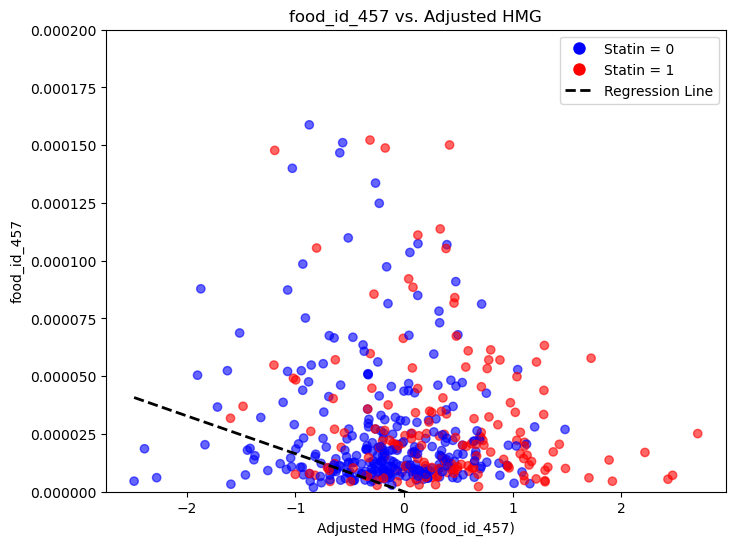

In [400]:
def plot_adjusted_values(adjusted_df, feature, beta, xlim=None, ylim=None):
    """
    Plot food feature vs. adjusted HMG using residuals, colored by Statin use, with customizable axis limits.
    Adds a regression line using the beta values from the linear regression.
    
    Parameters:
        adjusted_df (pd.DataFrame): DataFrame containing the adjusted HMG values.
        feature (str): Name of the independent food feature to plot.
        beta (float): Slope coefficient (beta) from the regression.
        xlim (tuple, optional): Limits for the x-axis.
        ylim (tuple, optional): Limits for the y-axis.
    """
    plt.figure(figsize=(8, 6))

    # Define colors based on Statin use
    colors = adjusted_df["Statin"].map({0: "blue", 1: "red"})
    
    # Scatter plot
    plt.scatter(adjusted_df[f"adjusted_HMG_{feature}"], adjusted_df[feature], c=colors, alpha=0.6, label="Data Points")

    # Compute regression line (Y = beta * X)
    x_vals = np.linspace(adjusted_df[f"adjusted_HMG_{feature}"].min(), adjusted_df[f"adjusted_HMG_{feature}"].max(), 100)
    y_vals = beta * x_vals  # No intercept included
    plt.plot(x_vals, y_vals, color="black", linestyle="dashed", linewidth=2, label="Regression Line")

    # Labels and title
    plt.xlabel(f"Adjusted HMG ({feature})")
    plt.ylabel(feature)
    plt.title(f"{feature} vs. Adjusted HMG")

    # Apply custom axis limits if provided
    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)

    # Create legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Statin = 0', markerfacecolor='blue', markersize=10),
        Line2D([0], [0], marker='o', color='w', label='Statin = 1', markerfacecolor='red', markersize=10),
        Line2D([0], [0], color='black', linestyle='dashed', linewidth=2, label='Regression Line')
    ]
    plt.legend(handles=legend_elements, loc="best")

    plt.show()
# Extract beta from regression results
feature = "food_id_457"
beta_value = diet_statins_hmg_regression.loc[diet_statins_hmg_regression["independent_feature"] == feature, "beta"].values[0]

# Plot
plot_adjusted_values(adjusted_df, feature, beta_value, xlim=None, ylim=(0,0.0002))


In [471]:
# save to csv
diet_statins_hmg_regression.to_csv("diet_statins_hmg_regression.csv", index=False)
# read the csv
diet_statins_hmg_regression = pd.read_csv("diet_statins_hmg_regression.csv")
# only keep rows where p < 0.5 and interaction_p < 0.5
#significant_diet_statins_hmg = diet_statins_hmg_regression[(diet_statins_hmg_regression["p"] < .1) & (diet_statins_hmg_regression["interaction_p"] < 1)]
# only keep rows where p
# print significant_diet_statins_hmg
#print(significant_diet_statins_hmg)
# compute the q values for the significant_diet_statins_hmg
##significant_diet_statins_hmg["q"] = multipletests(significant_diet_statins_hmg["p"], method="fdr_bh")[1]
# and interaction_q values for the significant_diet_statins_hmg
#significant_diet_statins_hmg["interaction_q"] = multipletests(significant_diet_statins_hmg["interaction_p"], method="fdr_bh")[1]
# sort by q value
diet_statins_hmg_regression = diet_statins_hmg_regression.sort_values(by="q")
# save to csv
diet_statins_hmg_regression.to_csv("diet_statins_hmg_regression.csv", index=False)
#significant_diet_statins_hmg.to_csv("significant_diet_statins_hmg.csv", index=False)


# HbA1c-statins-diet regressions
HbA1c is a biomarker for insulin resistance
in clients as a percentage currently as HbA1c (%)

In [232]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multitest import multipletests
import pandas as pd
import numpy as np
import os
# read metacardis_merged_microbes.csv
diet_df = pd.read_csv("biomarkers_diet_cov.csv")
# first check microbes
df = diet_df
test_df = diet_df
# define list of features
independent_features = food_features_95
dependent_features = ["hba1c"]
#formula_string = "{dependent_feature} ~ C(Gender) + Age + BMI + C(Nationality) + C(Status) + Activity + Microbial_load + Statin*{independent_feature}"

def linear_regression_results(dependent_features, independent_features, df, test_df):
    """Get a single association for a specific combination of features."""
    # Initialize an empty list to store the results
    all_results = []
    # Iterate through all combinations of dependent and independent features
    for dependent_feature in dependent_features:
        for independent_feature in independent_features:
            # Define the formula using the provided dependent and independent variables
            formula = f"{dependent_feature} ~ Activity + Age + Microbial_load + Statin +{independent_feature} +Statin:{independent_feature}"

            fitted = ols(formula, data=df).fit()
            # Compute R2 for the fitted model on the holdout test df
            # Get the residuals and calculate their sum of squares
            y_test = test_df[dependent_feature]
            predictions = fitted.predict(test_df)
            residuals = y_test - predictions
            RSS = np.sum(residuals**2)
            # Calculate the total sum of squares
            y_mean = np.mean(y_test)
            TSS = np.sum((y_test - y_mean)**2)
            # Calculate R-squared
            r2_test = 1 - (RSS / TSS)
            # Create a Series with the results
            result_series = pd.Series({
                "dependent_feature": dependent_feature,
                "independent_feature": independent_feature,
                "beta": fitted.params.get(independent_feature, np.nan),
                "t_statistic": fitted.tvalues.get(independent_feature, np.nan),
                "p": fitted.pvalues.get(independent_feature, np.nan),
                "interaction_beta": fitted.params.get(f"Statin:{independent_feature}", np.nan),
                "interaction_t_statistic": fitted.tvalues.get(f"Statin:{independent_feature}", np.nan),
                "interaction_p": fitted.pvalues.get(f"Statin:{independent_feature}", np.nan),
                "n": fitted.nobs,
                "r2_train": fitted.rsquared,
                "r2_test": r2_test,
                "formula": formula
            })
            all_results.append(result_series)
    
    # Convert results to DataFrame
    tests = pd.DataFrame(all_results)
    
    # Perform multiple testing correction
    tests["q"] = multipletests(tests["p"], method="fdr_bh")[1]
    tests["interaction_q"] = multipletests(tests["interaction_p"], method="fdr_bh")[1]
    
    return tests

diet_statins_hba1c_regression = linear_regression_results(dependent_features, independent_features, diet_df, diet_df)


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [234]:
# keep rows where q < 0.05
significant_diet_statins_hba1c = diet_statins_hba1c_regression[(diet_statins_hba1c_regression["q"] < 0.05)]
# print shape
print(significant_diet_statins_hba1c.shape)
#print(significant_diet_statins_hba1c)
# new variable where rows where interaction_q < 0.05
significant_diet_statins_hba1c_interaction = diet_statins_hba1c_regression[(diet_statins_hba1c_regression["interaction_q"] < 0.05)]
# print shape
print(significant_diet_statins_hba1c_interaction.shape)
# print significant_diet_statins_hba1c_interaction
#print(significant_diet_statins_hba1c_interaction)
# new variable called diet_hits with q < 0.05 and interaction_q < 0.05
diet_hits = diet_statins_hba1c_regression[(diet_statins_hba1c_regression["q"] < 0.05) & (diet_statins_hba1c_regression["interaction_q"] < 0.05)]
# print shape
print(diet_hits)



(13, 14)
(8, 14)
   dependent_feature independent_feature      beta  t_statistic  \
0              hba1c          food_id_16  0.001550     7.030699   
4              hba1c          food_id_94  0.000833     8.433973   
7              hba1c         food_id_105  0.000284    13.768770   
19             hba1c         food_id_334 -0.000116    -9.425778   
20             hba1c         food_id_348  0.000284    13.768770   
22             hba1c         food_id_457  0.000165    28.032009   
23             hba1c         food_id_465  0.000223     2.972838   
25             hba1c         food_id_748  0.000165    28.032009   

                p  interaction_beta  interaction_t_statistic  interaction_p  \
0    4.814012e-08         -0.000182                -4.418509   1.011528e-04   
4    9.689503e-11          0.000153                 5.144822   5.967912e-06   
7    6.740650e-29          0.000086                 7.206622   2.178649e-11   
19   1.145235e-14         -0.000197                -9.182432   

In [473]:
# save to csv
diet_statins_hba1c_regression.to_csv("diet_statins_hba1c_regression.csv", index=False)
# read the csv
diet_statins_hba1c_regression = pd.read_csv("diet_statins_hba1c_regression.csv")

In [29]:
# read metacardis_merged_microbes.csv
diet_df = pd.read_csv("biomarkers_diet_cov.csv")
# read statin_users.csv
statin_df = pd.read_csv("statin_microbes.csv")
# only keep rows where ID is in statin_df
diet_df = diet_df[diet_df['ID'].isin(statin_df['ID'])]
# first check microbes
df = diet_df
test_df = diet_df
# define list of features
independent_features = food_features_95
dependent_features = ["diazepam"]
#formula_string = "{dependent_feature} ~ C(Gender) + Age + BMI + C(Nationality) + C(Status) + Activity + Microbial_load + Statin*{independent_feature}"

def linear_regression_results(dependent_features, independent_features, df, test_df):
    """Get a single association for a specific combination of features."""
    # Initialize an empty list to store the results
    all_results = []
    residuals_df = test_df[['ID', 'diazepam',]].copy()  # Store residuals with ID and HMG
    # Iterate through all combinations of dependent and independent features
    for dependent_feature in dependent_features:
        for independent_feature in independent_features:
            # Define the formula using the provided dependent and independent variables
            formula = f"{dependent_feature} ~ C(Nationality) + Age + Microbial_load + {independent_feature}"

            fitted = ols(formula, data=df).fit()
            # Compute R2 for the fitted model on the holdout test df
            # Get the residuals and calculate their sum of squares
            y_test = test_df[dependent_feature]
            predictions = fitted.predict(test_df)
            residuals = y_test - predictions
            residuals_df[f"residual_{independent_feature}"] = residuals  # Store residuals

            RSS = np.sum(residuals**2)
            # Calculate the total sum of squares
            y_mean = np.mean(y_test)
            TSS = np.sum((y_test - y_mean)**2)
            # Calculate R-squared
            r2_test = 1 - (RSS / TSS)
            # Create a Series with the results
            result_series = pd.Series({
                "dependent_feature": dependent_feature,
                "independent_feature": independent_feature,
                "beta": fitted.params.get(independent_feature, np.nan),
                "t_statistic": fitted.tvalues.get(independent_feature, np.nan),
                "p": fitted.pvalues.get(independent_feature, np.nan),
                #"interaction_beta": fitted.params.get(f"hba1c:{independent_feature}", np.nan),
                #"interaction_t_statistic": fitted.tvalues.get(f"hba1c:{independent_feature}", np.nan),
                #"interaction_p": fitted.pvalues.get(f"hba1c:{independent_feature}", np.nan),
                "n": fitted.nobs,
                "r2_train": fitted.rsquared,
                "r2_test": r2_test,
                "formula": formula
            })
            all_results.append(result_series)
    
    # Convert results to DataFrame
    tests = pd.DataFrame(all_results)
    
    # Perform multiple testing correction
    tests["q"] = multipletests(tests["p"], method="fdr_bh")[1]
    #tests["interaction_q"] = multipletests(tests["interaction_p"], method="fdr_bh")[1]
    
    return tests, residuals_df

diet_statins_diazepam_regression, residuals = linear_regression_results(dependent_features, independent_features, diet_df, diet_df)

# Merge residuals back to dataset
adjusted_df = diet_df.copy()
for feature in independent_features:
    adjusted_df[f"adjusted_diaz_{feature}"] = adjusted_df["diazepam"] + residuals[f"residual_{feature}"]




Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/amobrian/anaconda3/envs/Winter2025/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/Users/amobrian/anaconda3/envs/Winter2025/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/Users/amobrian/anaconda3/envs/Winter2025/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/Users/amobrian/anaconda3/envs/Winter2025/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/Users/amobrian/anaconda3/envs/Winter2025/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divi

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/amobrian/anaconda3/envs/Winter2025/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/Users/amobrian/anaconda3/envs/Winter2025/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/Users/amobrian/anaconda3/envs/Winter2025/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/Users/amobrian/anaconda3/envs/Winter2025/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/Users/amobrian/anaconda3/envs/Winter2025/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divi

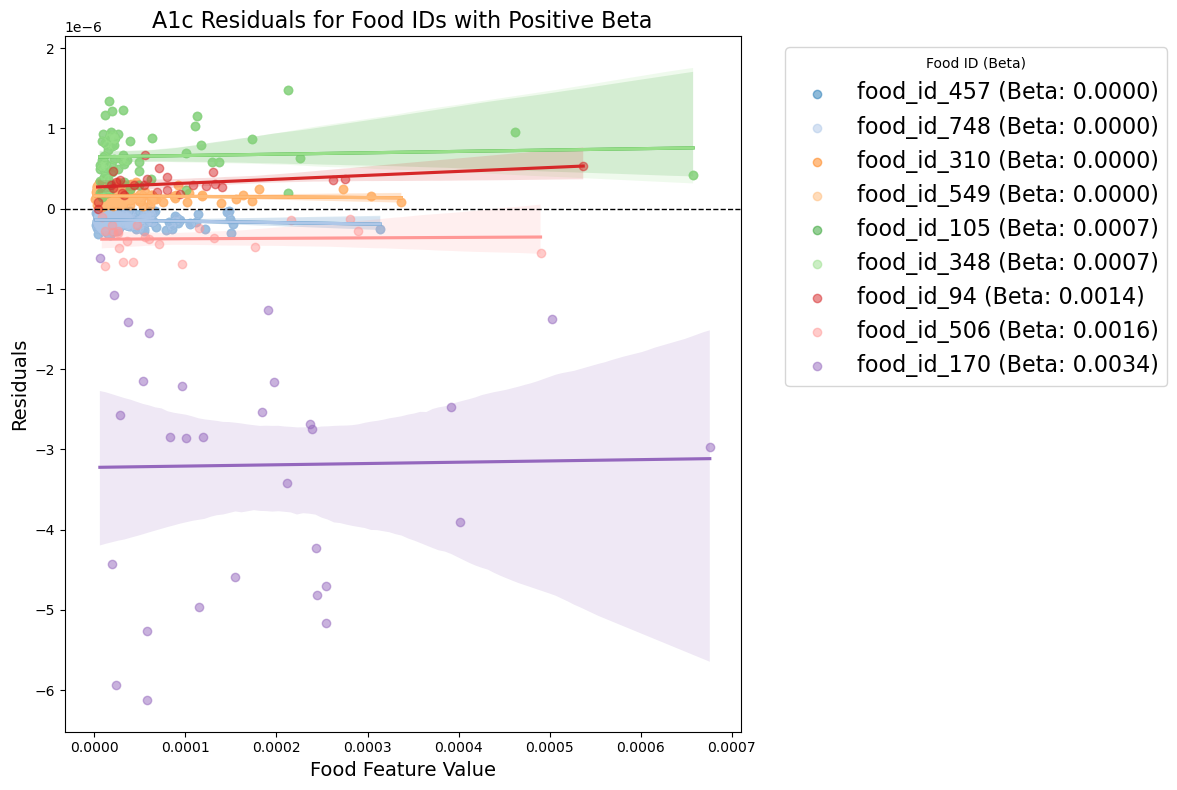

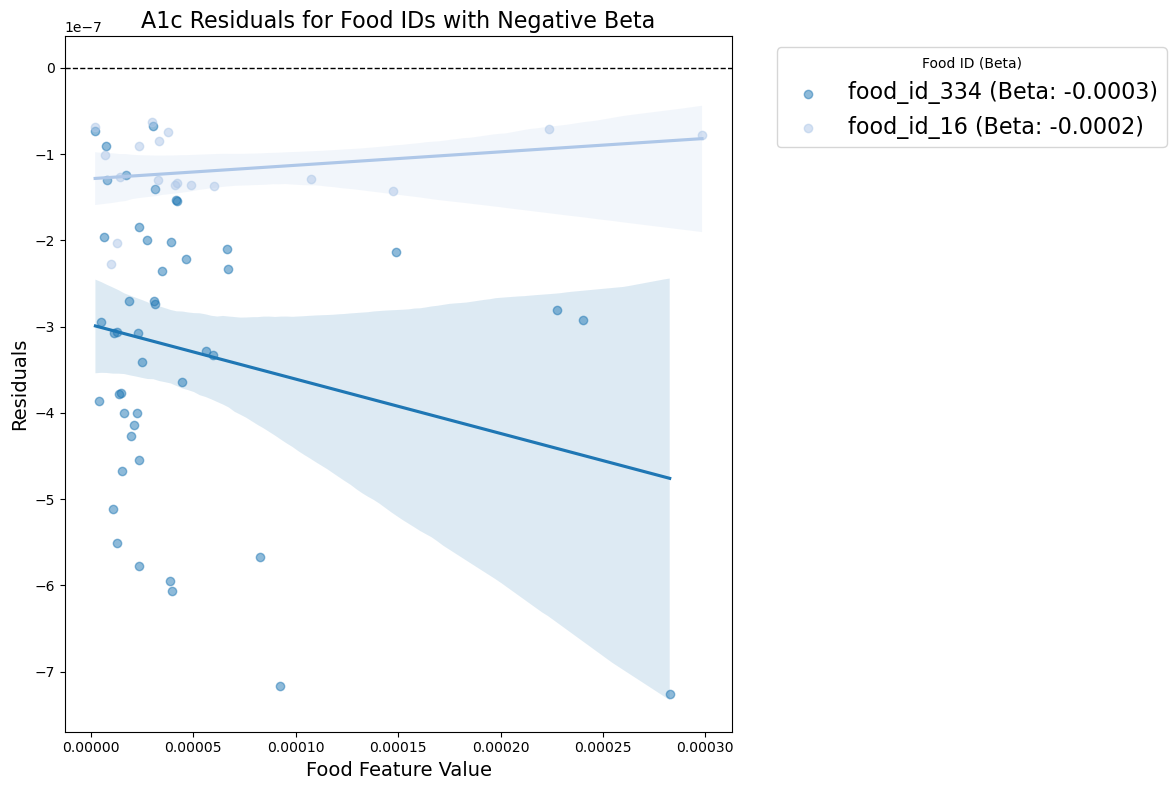

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter food IDs with significant q and interaction_q < 0.05
significant_food_ids = diet_statins_hba1c_regression[
    (diet_statins_hba1c_regression["q"] < 0.05) & 
    (diet_statins_hba1c_regression["interaction_q"] < 0.05)
]

# Check if there are any significant food IDs
if len(significant_food_ids) == 0:
    print("No food IDs have significant q and interaction_q < 0.05.")
else:
    # Extract beta values and sort food IDs by beta
    significant_food_ids = significant_food_ids[["independent_feature", "beta"]].sort_values(by="beta")
    
    # Separate food IDs into positive and negative beta groups
    positive_beta_food_ids = significant_food_ids[significant_food_ids["beta"] > 0]["independent_feature"]
    negative_beta_food_ids = significant_food_ids[significant_food_ids["beta"] < 0]["independent_feature"]

    # Merge residuals with diet_df to get food IDs
    residuals_df = residuals.merge(diet_df[['ID'] + list(positive_beta_food_ids) + list(negative_beta_food_ids)], on='ID', how='left')

    # Function to plot residuals for a group of food IDs
    def plot_residuals(food_ids, title):
        plt.figure(figsize=(12, 8))
        
        # Use the 'tab20' palette for distinct colors
        colors = plt.cm.tab20.colors  # Get the 'tab20' color palette
        
        for i, food_id in enumerate(food_ids):
            color = colors[i % len(colors)]  # Cycle through colors if there are more food IDs than colors
            sns.regplot(
                x=residuals_df[food_id], 
                y=residuals_df[f"residual_{food_id}"], 
                label=f"{food_id} (Beta: {significant_food_ids.set_index('independent_feature').loc[food_id, 'beta']:.4f})",
                scatter_kws={'alpha': 0.5, 'color': color},  # Set scatter plot color
                line_kws={'color': color}                    # Set regression line color
            )

        # Add labels, title, and legend
        plt.title(title, fontsize=16)
        plt.xlabel("Food Feature Value", fontsize=14)
        plt.ylabel("Residuals", fontsize=14)
        plt.axhline(0, color='black', linestyle='--', linewidth=1)  # Add a horizontal line at 0 for reference
        plt.legend(title="Food ID (Beta)", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=16)  # Place legend outside the plot

        plt.tight_layout()
        plt.show()

    # Plot positive beta food IDs
    if len(positive_beta_food_ids) > 0:
        plot_residuals(positive_beta_food_ids, "A1c Residuals for Food IDs with Positive Beta")

    # Plot negative beta food IDs
    if len(negative_beta_food_ids) > 0:
        plot_residuals(negative_beta_food_ids, "A1c Residuals for Food IDs with Negative Beta")

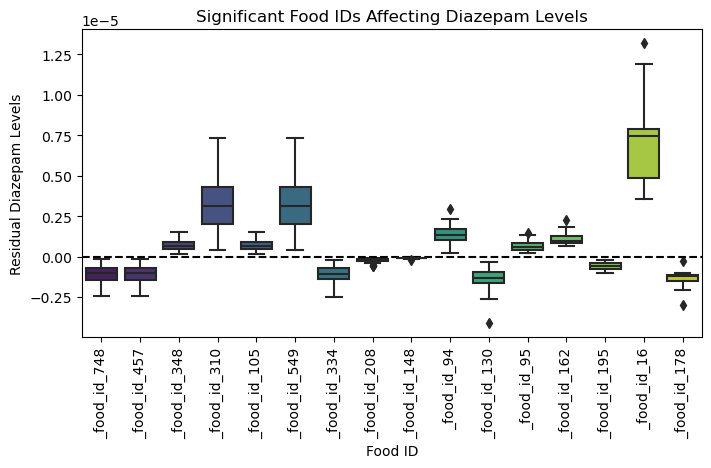

In [629]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract only the food IDs with significant q-values
significant_foods = diet_statins_diazepam_regression[diet_statins_diazepam_regression["q"] < 0.05]["independent_feature"].tolist()
# sort by q value
diet_statins_diazepam_regression = diet_statins_diazepam_regression.sort_values(by="q")

# Filter the residuals to only include significant food features
significant_residuals = residuals[["ID", "diazepam"] + [f"residual_{food}" for food in significant_foods]]

# Reshape for plotting: Convert wide format to long format
plot_df = significant_residuals.melt(id_vars=["ID", "diazepam"], var_name="food_id", value_name="residual_diazepam")

# Clean up food_id column (remove 'residual' prefix)
plot_df["food_id"] = plot_df["food_id"].str.replace("residual", "")

# Plot diazepam residuals against significant food IDs
plt.figure(figsize=(8, 4))
sns.boxplot(x="food_id", y="residual_diazepam", data=plot_df, palette="viridis")
plt.axhline(0, color="black", linestyle="--")  # Reference line at zero
plt.xlabel("Food ID")
plt.ylabel("Residual Diazepam Levels")
plt.title("Significant Food IDs Affecting Diazepam Levels")
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.show()


In [595]:
# keep rows where q < 0.05
significant_diet_statins = diet_statins_diazepam_regression[(diet_statins_diazepam_regression["q"] < 0.05)]
# order by beta value
significant_diet_statins = significant_diet_statins.sort_values("beta")
# print shape
print(significant_diet_statins.shape)
print(significant_diet_statins)
#print(significant_diet_statins_creatine)
# new variable where rows where interaction_q < 0.05
#significant_diet_statins_creatine_interaction = diet_statins_creatine_regression[(diet_statins_creatine_regression["interaction_q"] < 0.05)]
# print shape
#print(significant_diet_statins_creatine_interaction.shape)
# new variable called diet_hits where q < 0.05 and interaction_q < 0.05
#A1c_hits = diet_statins_creatine_regression[(diet_statins_creatine_regression["q"] < 0.1) & (diet_statins_creatine_regression["interaction_q"] < 0.1)]
# print shape
# save diazepam_hits to csv
significant_diet_statins.to_csv("diazepam_hits.csv", index=False)


(16, 10)
   dependent_feature independent_feature      beta   t_statistic  \
4           diazepam          food_id_94 -0.000491 -7.929490e+05   
7           diazepam         food_id_105 -0.000339 -2.159911e+06   
23          diazepam         food_id_348 -0.000339 -2.159911e+06   
0           diazepam          food_id_16 -0.000330 -7.128863e+04   
11          diazepam         food_id_162 -0.000234 -3.548984e+05   
25          diazepam         food_id_457 -0.000024 -3.081722e+06   
28          diazepam         food_id_748 -0.000024 -3.081722e+06   
19          diazepam         food_id_195 -0.000012 -1.355026e+06   
21          diazepam         food_id_310 -0.000002 -3.065987e+05   
27          diazepam         food_id_549 -0.000002 -3.065987e+05   
5           diazepam          food_id_95  0.000016  9.480449e+05   
10          diazepam         food_id_148  0.000031  8.976856e+06   
22          diazepam         food_id_334  0.000080  1.188903e+06   
8           diazepam         food_id_13

In [20]:
# Read input files
diet_df = pd.read_csv("biomarkers_diet_cov.csv")
statin_df = pd.read_csv("statin_microbes.csv")

# Only keep rows where ID is in statin_df
diet_df = diet_df[diet_df['ID'].isin(statin_df['ID'])]

# Define list of features
independent_features = food_features_95
dependent_features = ["hba1c"]

def linear_regression_results(dependent_features, independent_features, df, test_df):
    """Perform linear regression and store residuals for visualization."""
    
    all_results = []
    residuals_df = test_df[['ID', 'hba1c']].copy()  # Store residuals with ID and HMG

    for dependent_feature in dependent_features:
        for independent_feature in independent_features:
            # Define the formula
            formula = f"{dependent_feature} ~ C(Nationality) + Age + Microbial_load + HMG + {independent_feature} + HMG:{independent_feature}"
            fitted = ols(formula, data=df).fit()
            
            # Compute residuals
            y_test = test_df[dependent_feature]
            predictions = fitted.predict(test_df)
            residuals = y_test - predictions
            residuals_df[f"residual_{independent_feature}"] = residuals  # Store residuals
            
            # Compute R2
            RSS = np.sum(residuals**2)
            y_mean = np.mean(y_test)
            TSS = np.sum((y_test - y_mean)**2)
            r2_test = 1 - (RSS / TSS)
            
            # Store regression results
            result_series = pd.Series({
                "dependent_feature": dependent_feature,
                "independent_feature": independent_feature,
                "beta": fitted.params.get(independent_feature, np.nan),
                "t_statistic": fitted.tvalues.get(independent_feature, np.nan),
                "p": fitted.pvalues.get(independent_feature, np.nan),
                "interaction_beta": fitted.params.get(f"HMG:{independent_feature}", np.nan),
                "interaction_t_statistic": fitted.tvalues.get(f"HMG:{independent_feature}", np.nan),
                "interaction_p": fitted.pvalues.get(f"HMG:{independent_feature}", np.nan),
                "n": fitted.nobs,
                "r2_train": fitted.rsquared,
                "r2_test": r2_test,
                "formula": formula
            })
            all_results.append(result_series)
    
    # Convert results to DataFrame
    tests = pd.DataFrame(all_results)
    
    # Perform multiple testing correction
    tests["q"] = multipletests(tests["p"], method="fdr_bh")[1]
    tests["interaction_q"] = multipletests(tests["interaction_p"], method="fdr_bh")[1]
    
    return tests, residuals_df

# Run regression and get residuals
diet_statins_hba1c_regression, residuals = linear_regression_results(dependent_features, independent_features, diet_df, diet_df)

# take only rows where q < 0.05 and interaction_q < 0.05
sig_diet_statins_hba1c = diet_statins_hba1c_regression[(diet_statins_hba1c_regression["q"] < 0.05) & (diet_statins_hba1c_regression["interaction_q"] < 0.05)]
# save to csv
sig_diet_statins_hba1c.to_csv("A1c_diet_hits.csv", index=False)
# Merge residuals back to dataset
#adjusted_df = diet_df.copy()
#for feature in independent_features:
#    adjusted_df[f"adjusted_hba1c_{feature}"] = adjusted_df["hba1c"] + residuals[f"residual_{feature}"]


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


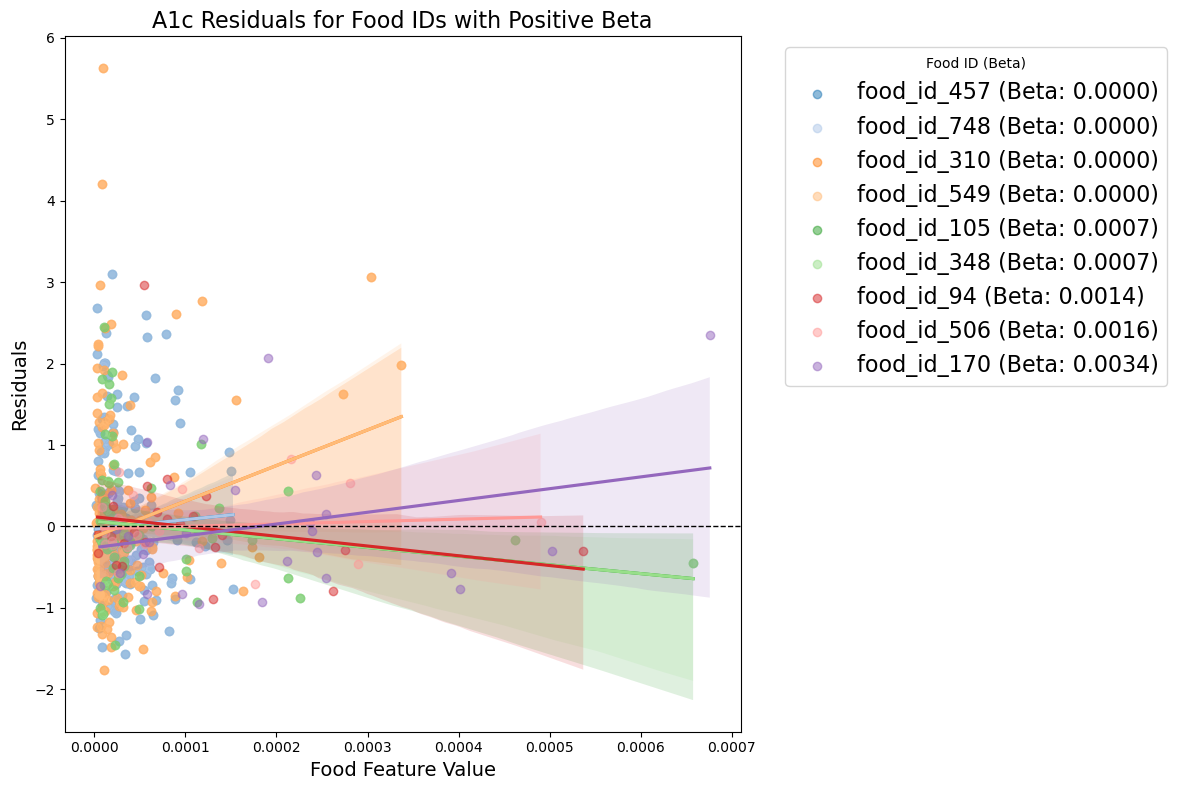

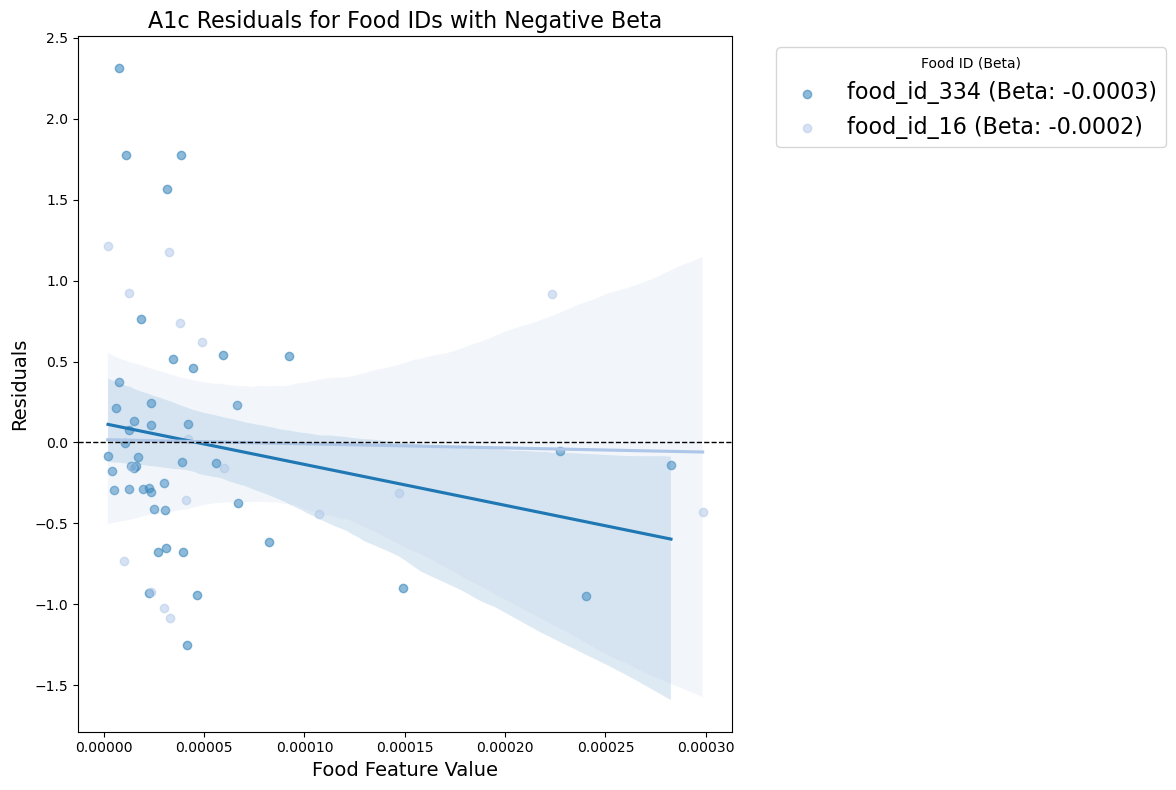

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter food IDs with significant q and interaction_q < 0.05
significant_food_ids = diet_statins_hba1c_regression[
    (diet_statins_hba1c_regression["q"] < 0.05) & 
    (diet_statins_hba1c_regression["interaction_q"] < 0.05)
]

# Check if there are any significant food IDs
if len(significant_food_ids) == 0:
    print("No food IDs have significant q and interaction_q < 0.05.")
else:
    # Extract beta values and sort food IDs by beta
    significant_food_ids = significant_food_ids[["independent_feature", "beta"]].sort_values(by="beta")
    
    # Separate food IDs into positive and negative beta groups
    positive_beta_food_ids = significant_food_ids[significant_food_ids["beta"] > 0]["independent_feature"]
    negative_beta_food_ids = significant_food_ids[significant_food_ids["beta"] < 0]["independent_feature"]

    # Merge residuals with diet_df to get food IDs
    residuals_df = residuals.merge(diet_df[['ID'] + list(positive_beta_food_ids) + list(negative_beta_food_ids)], on='ID', how='left')

    # Function to plot residuals for a group of food IDs
    def plot_residuals(food_ids, title):
        plt.figure(figsize=(12, 8))
        
        # Use the 'tab20' palette for distinct colors
        colors = plt.cm.tab20.colors  # Get the 'tab20' color palette
        
        for i, food_id in enumerate(food_ids):
            color = colors[i % len(colors)]  # Cycle through colors if there are more food IDs than colors
            sns.regplot(
                x=residuals_df[food_id], 
                y=residuals_df[f"residual_{food_id}"], 
                label=f"{food_id} (Beta: {significant_food_ids.set_index('independent_feature').loc[food_id, 'beta']:.4f})",
                scatter_kws={'alpha': 0.5, 'color': color},  # Set scatter plot color
                line_kws={'color': color}                    # Set regression line color
            )

        # Add labels, title, and legend
        plt.title(title, fontsize=16)
        plt.xlabel("Food Feature Value", fontsize=14)
        plt.ylabel("Residuals", fontsize=14)
        plt.axhline(0, color='black', linestyle='--', linewidth=1)  # Add a horizontal line at 0 for reference
        plt.legend(title="Food ID (Beta)", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=16)  # Place legend outside the plot

        plt.tight_layout()
        plt.show()

    # Plot positive beta food IDs
    if len(positive_beta_food_ids) > 0:
        plot_residuals(positive_beta_food_ids, "A1c Residuals for Food IDs with Positive Beta")

    # Plot negative beta food IDs
    if len(negative_beta_food_ids) > 0:
        plot_residuals(negative_beta_food_ids, "A1c Residuals for Food IDs with Negative Beta")

/var/folders/0p/3l67fvd177l7t51yqw473srr0000gn/T/ipykernel_18577/850153849.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Food_ID', y='Residual', data=residuals_long, palette='viridis')


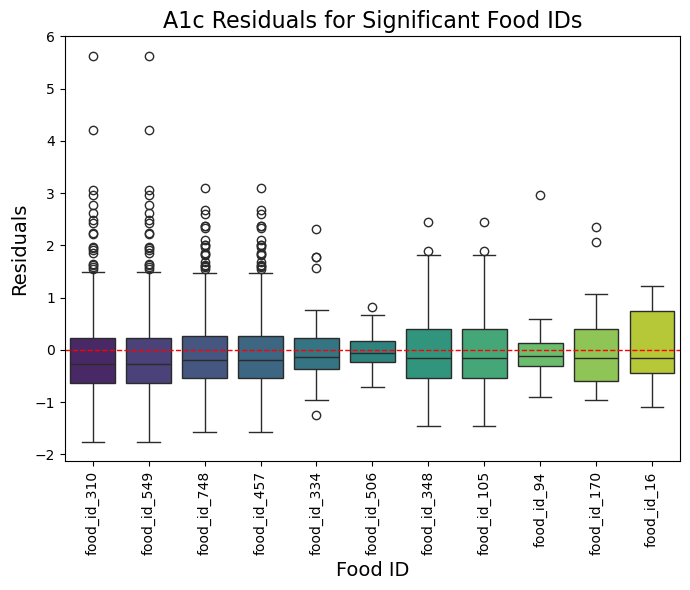

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Filter food IDs with significant q and interaction_q < 0.05
significant_food_ids = diet_statins_hba1c_regression[
    (diet_statins_hba1c_regression["q"] < 0.05) & 
    (diet_statins_hba1c_regression["interaction_q"] < 0.05)
]["independent_feature"].unique()

# Check if there are any significant food IDs
if len(significant_food_ids) == 0:
    print("No food IDs have significant q and interaction_q < 0.05.")
else:
    # Filter residuals for only significant food IDs
    significant_residuals = residuals_df[['ID'] + [f"residual_{food_id}" for food_id in significant_food_ids]]

    # Melt the residuals_df to long format for boxplot
    residuals_long = pd.melt(
        significant_residuals, 
        id_vars=['ID'], 
        value_vars=[f"residual_{food_id}" for food_id in significant_food_ids], 
        var_name='Food_ID', 
        value_name='Residual'
    )

    # Extract the food ID from the column name (e.g., "residual_food1" -> "food1")
    residuals_long['Food_ID'] = residuals_long['Food_ID'].str.replace('residual_', '')

    # Create the box plot
    plt.figure(figsize=(7, 6))
    sns.boxplot(x='Food_ID', y='Residual', data=residuals_long, palette='viridis')

    # Add labels and title
    plt.title("A1c Residuals for Significant Food IDs", fontsize=16)
    plt.xlabel("Food ID", fontsize=14)
    plt.ylabel("Residuals", fontsize=14)
    plt.xticks(rotation=90)  # Rotate x-axis labels for better readability

    # Add a horizontal line at 0 for reference
    plt.axhline(0, color='red', linestyle='--', linewidth=1)

    plt.tight_layout()
    plt.show()

['food_id_310', 'food_id_549', 'food_id_748', 'food_id_457', 'food_id_334', 'food_id_506', 'food_id_348', 'food_id_105', 'food_id_94', 'food_id_130', 'food_id_170', 'food_id_16', 'food_id_195']


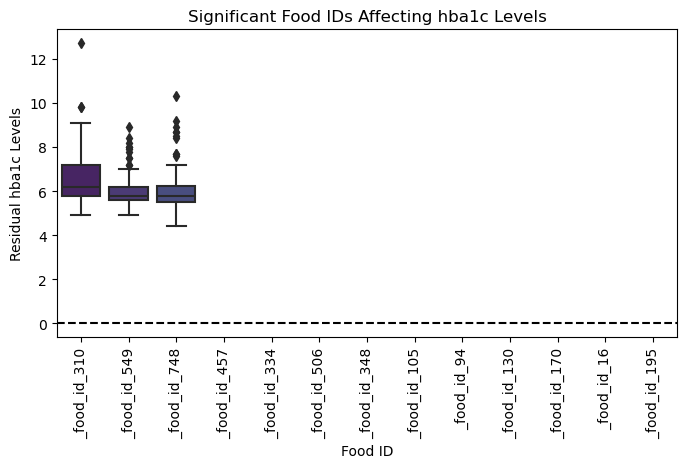

In [641]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_adjusted_values(adjusted_df, feature, xlim=None, ylim=None):
    """
    Plot food feature vs. adjusted HBA1c using Seaborn's regplot.
    
    Parameters:
        adjusted_df (pd.DataFrame): DataFrame containing adjusted HBA1c values.
        feature (str): Name of the independent food feature to plot.
        xlim (tuple, optional): Limits for the x-axis.
        ylim (tuple, optional): Limits for the y-axis.
    """
    plt.figure(figsize=(8, 6))

    # Filter out NaN values
    filtered_df = adjusted_df[[f"adjusted_HMG_{feature}", feature]].dropna()

    # Plot using Seaborn regplot
    sns.regplot(x=filtered_df[f"adjusted_HMG_{feature}"], 
                y=filtered_df[feature], 
                scatter=True, 
                )  # Removes confidence interval

    # Labels and title
    plt.xlabel(f"Adjusted HMG ({feature})")
    plt.ylabel(feature)

    # Apply custom axis limits if provided
    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)

    plt.show()

feature = "food_id_748"
#plot_adjusted_values(adjusted_df, feature)


import matplotlib.pyplot as plt
import seaborn as sns
# Extract only the food IDs with significant q-values and interaction q-values
significant_foods = diet_statins_hba1c_regression[diet_statins_hba1c_regression["q"] < 0.05]["independent_feature"].tolist()
significant_foods = diet_statins_hba1c_regression[diet_statins_hba1c_regression["q"] < 0.05]["independent_feature"].tolist()
# sort by q value
diet_statins_hba1c_regression = diet_statins_hba1c_regression.sort_values(by="q")
#print(diet_statins_hba1c_regression)
print(significant_foods)

# Filter the residuals to only include significant food features
significant_residuals = residuals[["ID", "hba1c"] + [f"residual_{food}" for food in significant_foods]]

# Reshape for plotting: Convert wide format to long format
plot_df = significant_residuals.melt(id_vars=["ID", "hba1c"], var_name="food_id", value_name="residual_hba1c")

# Clean up food_id column (remove 'residual' prefix)
plot_df["food_id"] = plot_df["food_id"].str.replace("residual", "")
# extract origional hba1c from diet_df
plot_df["hba1c"] = diet_df["hba1c"]

# Plot diazepam residuals against significant food IDs
plt.figure(figsize=(8, 4))
sns.boxplot(x="food_id", y="hba1c", data=plot_df, palette="viridis")
plt.axhline(0, color="black", linestyle="--")  # Reference line at zero
plt.xlabel("Food ID")
plt.ylabel("Residual hba1c Levels")
plt.title("Significant Food IDs Affecting hba1c Levels")
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.show()



In [635]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multitest import multipletests
import pandas as pd
import numpy as np

# Read input files
diet_df = pd.read_csv("biomarkers_diet_cov.csv")
statin_df = pd.read_csv("statin_microbes.csv")

# Only keep rows where ID is in statin_df
diet_df = diet_df[diet_df['ID'].isin(statin_df['ID'])]

# Define list of features
independent_features = food_features_95
dependent_features = ["hba1c"]

def linear_regression_results(dependent_features, independent_features, df, test_df):
    """Perform linear regression and store residuals for visualization."""
    
    all_results = []
    residuals_df = test_df[['ID', 'hba1c', 'HMG']].copy()  # Store residuals with ID and HMG

    for dependent_feature in dependent_features:
        for independent_feature in independent_features:
            # Define the formula
            formula = f"{dependent_feature} ~ C(Nationality) + Age + Microbial_load + HMG + {independent_feature} + HMG:{independent_feature}"
            fitted = ols(formula, data=df).fit()
            
            # Compute residuals
            y_test = test_df[dependent_feature]
            predictions = fitted.predict(test_df)
            residuals = y_test - predictions
            residuals_df[f"residual_{independent_feature}"] = residuals  # Store residuals
            
            # Compute R2
            RSS = np.sum(residuals**2)
            y_mean = np.mean(y_test)
            TSS = np.sum((y_test - y_mean)**2)
            r2_test = 1 - (RSS / TSS)
            
            # Store regression results
            result_series = pd.Series({
                "dependent_feature": dependent_feature,
                "independent_feature": independent_feature,
                "beta": fitted.params.get(independent_feature, np.nan),
                "t_statistic": fitted.tvalues.get(independent_feature, np.nan),
                "p": fitted.pvalues.get(independent_feature, np.nan),
                "interaction_beta": fitted.params.get(f"HMG:{independent_feature}", np.nan),
                "interaction_t_statistic": fitted.tvalues.get(f"HMG:{independent_feature}", np.nan),
                "interaction_p": fitted.pvalues.get(f"HMG:{independent_feature}", np.nan),
                "n": fitted.nobs,
                "r2_train": fitted.rsquared,
                "r2_test": r2_test,
                "formula": formula
            })
            all_results.append(result_series)
    
    # Convert results to DataFrame
    tests = pd.DataFrame(all_results)
    
    # Perform multiple testing correction
    tests["q"] = multipletests(tests["p"], method="fdr_bh")[1]
    tests["interaction_q"] = multipletests(tests["interaction_p"], method="fdr_bh")[1]
    
    return tests, residuals_df

# Run regression and get residuals
diet_statins_hba1c_regression, residuals = linear_regression_results(dependent_features, independent_features, diet_df, diet_df)

# Merge residuals back to dataset
adjusted_df = diet_df.copy()
for feature in independent_features:
    adjusted_df[f"adjusted_hba1c_{feature}"] = adjusted_df["hba1c"] + residuals[f"residual_{feature}"]


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


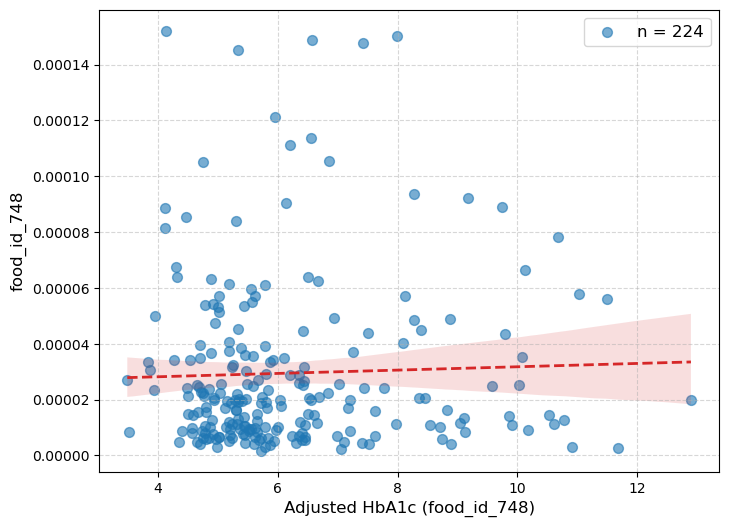

<Figure size 640x480 with 0 Axes>

In [636]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_adjusted_values(adjusted_df, feature, xlim=None, ylim=None):
    """
    Plot food feature vs. adjusted HBA1c using Seaborn's regplot with a legend displaying sample size (n).
    
    Parameters:
        adjusted_df (pd.DataFrame): DataFrame containing adjusted HBA1c values.
        feature (str): Name of the independent food feature to plot.
        xlim (tuple, optional): Limits for the x-axis.
        ylim (tuple, optional): Limits for the y-axis.
    """
    plt.figure(figsize=(8, 6))

    # Filter out NaN values
    filtered_df = adjusted_df[[f"adjusted_hba1c_{feature}", feature]].dropna()

    # Define colors
    scatter_color = "#1f77b4"  # Muted blue
    line_color = "#d62728"  # Deep red for regression line

    # Plot using Seaborn regplot
    ax = sns.regplot(
        x=filtered_df[f"adjusted_hba1c_{feature}"], 
        y=filtered_df[feature], 
        scatter=True, 
        color=scatter_color,  # Scatter plot color
        scatter_kws={"alpha": 0.6, "s": 50},  # Adjust transparency and size
        line_kws={"color": line_color, "linestyle": "dashed", "linewidth": 2},  # Regression line style
    )

    # Labels and title
    plt.xlabel(f"Adjusted HbA1c ({feature})", fontsize=12)
    plt.ylabel(feature, fontsize=12)

    # Apply custom axis limits if provided
    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)

    # Add legend showing sample size (n)
    n = len(filtered_df)
    legend_text = f"n = {n}"
    plt.legend([legend_text], loc="best", frameon=True, fontsize=12)

    plt.grid(True, linestyle="--", alpha=0.5)  # Add subtle grid lines
    plt.show()

feature = "food_id_748"
plot_adjusted_values(adjusted_df, feature, xlim=None, ylim=None)
# save plot to png with feature name
plt.savefig(f"{feature}_adjusted_hba1c.png")


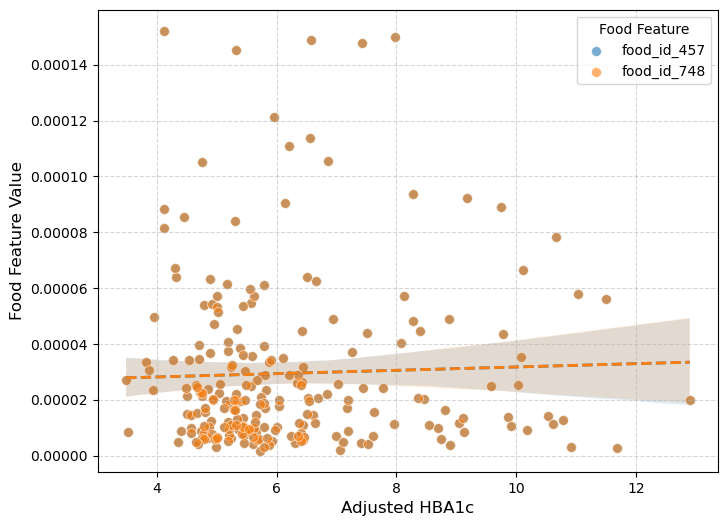

In [543]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_multiple_food_features(adjusted_df, features, xlim=None, ylim=None):
    """
    Plot multiple food features vs. adjusted HBA1c using Seaborn.
    
    Parameters:
        adjusted_df (pd.DataFrame): DataFrame containing adjusted HBA1c values.
        features (list): List of independent food features to plot (up to 4 for clarity).
        xlim (tuple, optional): Limits for the x-axis.
        ylim (tuple, optional): Limits for the y-axis.
    """
    plt.figure(figsize=(8, 6))

    # Define colors for different food features (up to 4)
    colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]  # Blue, Orange, Green, Red

    # Ensure only 4 features max for clarity
    features = features[:4]  # Take only the first 4 elements

    # Loop through each food feature and plot it
    for i, feature in enumerate(features):
        # Filter out NaN values
        filtered_df = adjusted_df[[f"adjusted_hba1c_{feature}", feature]].dropna()

        # Scatter plot for data points
        sns.scatterplot(
            x=filtered_df[f"adjusted_hba1c_{feature}"], 
            y=filtered_df[feature], 
            label=f"{feature}",
            alpha=0.6, 
            s=50, 
            color=colors[i]
        )

        # Regression line
        sns.regplot(
            x=filtered_df[f"adjusted_hba1c_{feature}"], 
            y=filtered_df[feature], 
            scatter=False, 
            color=colors[i], 
            line_kws={"linestyle": "dashed", "linewidth": 2}
        )

    # Labels and title
    plt.xlabel("Adjusted HBA1c", fontsize=12)
    plt.ylabel("Food Feature Value", fontsize=12)

    # Apply custom axis limits if provided
    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)

    plt.legend(title="Food Feature")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()


food_features = ["food_id_457","food_id_748"]
plot_multiple_food_features(adjusted_df, food_features)
# save figure to png
#plt.savefig("meat_food_features.png")

# microbe ~ HMG*A1c in only statin users

In [642]:
# read biomarkers_microbes_cov.csv
microbes = pd.read_csv("biomarkers_microbes_cov.csv")
# make a list of ID where statin = 1
statin_users = microbes[microbes['Statin'] == 1]['ID']
# check shape
print(statin_users.shape)
# save a csv of microbes that only has statin_users as ID
microbes[microbes['ID'].isin(statin_users)].to_csv("statin_microbes.csv", index=False)

(381,)


In [643]:
# perform CLR transform on statin_microbes.csv
# read metacardis_microbes_edited.csv
microbes = pd.read_csv("metacardis_microbes_edited.csv")
# only use microbes where ID = values in statin_users
microbes = microbes[microbes['ID'].isin(statin_users)]
#save a copy of the untransformed df so that you can reference it to find the 0s after the CLR transform
microbes_original = microbes.copy()

#Add 0.0000001 to each cell for gmean calculation and log transform (pseudocount)
microbes[microbe_features] = microbes[microbe_features] + 0.0000001

microbes['gmean'] = microbes[microbe_features].apply(scipy.stats.mstats.gmean, axis=1,
                                                             nan_policy='raise')

#finish the CLR transform: divide by gmean and log transform
microbes[list(microbe_features) + ["gmean"]] = np.log(microbes[list(microbe_features) + ["gmean"]].divide(microbes["gmean"], axis=0))

# check that the CLR worked, summing the gmean column should print 0 since ln(1) = 0
print(microbes.gmean.sum())
microbes.drop(columns='gmean', inplace=True)

# reference the untransformed measure_microbe_original to find the zeroes
# make a boolean mask that we can use to identify the zeroes in the transformed
# data after imputing pseudocount and doing the CLR transform
zero_mask = microbes_original[microbe_features] == 0

# use the zero_mask to replace anywhere that was originally a 0 with np.nan
microbes[microbe_features] = microbes[microbe_features].mask(zero_mask, np.nan)

# drop microbe column names from microbe_features that have more than 75% Nan
print(len(microbe_features))
bad = microbes[microbe_features].isna().sum() / microbes.shape[0] > 0.70
microbe_features_90 = bad[~bad].index.tolist()
print(len(microbe_features_90))
# save microbes dataframe to csv
microbes.to_csv("metacardis_microbes_clr.csv", index=False)
print(microbe_features_90)

/var/folders/0p/3l67fvd177l7t51yqw473srr0000gn/T/ipykernel_37659/3313215854.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  microbes['gmean'] = microbes[microbe_features].apply(scipy.stats.mstats.gmean, axis=1,


0.0
729
308
['clostridium_bolteae_cag00008', 'escherichia_coli_cag00011', 'unclassified_clostridiales_cag00013', 'eisenbergiella_tayi_cag00014', 'hungatella_hathewayi_2_cag00015', 'clostridium_sp__kle_1755___clostridiales_bacterium_ve202_27_cag00020', 'bacteroides_fragilis_1_cag00024', 'hungatella_hathewayi_1_cag00025', 'oscillibacter_sp__er4___firmicutes_bacterium_cag_129_59_24_cag01028', 'ruminococcus_sp__cag_177_cag00760', 'blautia_wexlerae_cag00164', 'clostridium_innocuum_cag00036', 'unclassified_clostridiales_cag00039', 'unclassified_gemmiger_cag00042', 'clostridium_symbiosum_cag00044', 'bacteroides_caccae_cag00049', 'bacteroides_thetaiotaomicron_cag00050', 'parabacteroides_goldsteinii_cag00052', 'ruminococcus_bromii_2_cag00611', 'coprococcus_eutactus_2_cag00490', 'gemmiger_formicilis_cag00601', 'firmicutes_bacterium_cag_176_cag00766', 'akkermansia_muciniphila_cag00301', 'eubacterium_siraeum_cag00653', 'oscillibacter_sp__57_20_cag01051', 'bacteroides_cellulosilyticus_cag00071', 'b

In [666]:

# read statin_microbes.csv
microbes = pd.read_csv("statin_microbes.csv")


# define list of features
independent_features = microbe_features_90
dependent_features = ['hba1c']
#formula_string = "{dependent_feature} ~ C(Gender) + Age + BMI + C(Nationality) + C(Status) + Activity + Microbial_load + Statin*{independent_feature}"

def linear_regression_results(dependent_features, independent_features, df, test_df):
    """Get a single association for a specific combination of features."""
    # Initialize an empty list to store the results
    all_results = []
    # Iterate through all combinations of dependent and independent features
    for dependent_feature in dependent_features:
        for independent_feature in independent_features:
            # Define the formula using the provided dependent and independent variables
            formula = f"{dependent_feature} ~ Age + C(Gender) + Microbial_load +  + HMG +{independent_feature} + HMG:{independent_feature}"

            fitted = ols(formula, data=df).fit()
            # Compute R2 for the fitted model on the holdout test df
            # Get the residuals and calculate their sum of squares
            y_test = test_df[dependent_feature]
            predictions = fitted.predict(test_df)
            residuals = y_test - predictions
            RSS = np.sum(residuals**2)
            # Calculate the total sum of squares
            y_mean = np.mean(y_test)
            TSS = np.sum((y_test - y_mean)**2)
            # Calculate R-squared
            r2_test = 1 - (RSS / TSS)
            # Create a Series with the results
            result_series = pd.Series({
                "dependent_feature": dependent_feature,
                "independent_feature": independent_feature,
                "beta": fitted.params.get(independent_feature, np.nan),
                "t_statistic": fitted.tvalues.get(independent_feature, np.nan),
                "p": fitted.pvalues.get(independent_feature, np.nan),
                "interaction_beta": fitted.params.get(f"HMG:{independent_feature}", np.nan),
                "interaction_t_statistic": fitted.tvalues.get(f"HMG:{independent_feature}", np.nan),
                "interaction_p": fitted.pvalues.get(f"HMG:{independent_feature}", np.nan),
                "n": fitted.nobs,
                "r2_train": fitted.rsquared,
                "r2_test": r2_test,
                "formula": formula
            })
            all_results.append(result_series)
    
    # Convert results to DataFrame
    tests = pd.DataFrame(all_results)
    
    # Perform multiple testing correction
    tests["q"] = multipletests(tests["p"], method="fdr_bh")[1]
    tests["interaction_q"] = multipletests(tests["interaction_p"], method="fdr_bh")[1]
    
    return tests

biomarkers_microbes = linear_regression_results(dependent_features, independent_features, microbes, microbes)



Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [672]:
# keep rows where q < 0.05 in biomarkers_microbes
significant_biomarkers_microbes = biomarkers_microbes[(biomarkers_microbes["q"] < 0.05)]
# print shape
print(significant_biomarkers_microbes.shape)
# new variable where interaction_q < 0.05
significant_biomarkers_microbes_interaction = biomarkers_microbes[(biomarkers_microbes["interaction_q"] < 0.05)]
# print shape
print(significant_biomarkers_microbes_interaction.shape)
# new variable called diet_hits where q < 0.05 and interaction_q < 0.05
biomarkers_hits = biomarkers_microbes[(biomarkers_microbes["q"] < 0.05) & (biomarkers_microbes["interaction_q"] < 0.1)]
# print shape
print(biomarkers_hits.shape)
print(biomarkers_hits)
# save biomarkers_hits as csv called hmgxa1c_microbes.csv
#biomarkers_hits.to_csv("a1cxHMG_microbes.csv", index=False)
significant_biomarkers_microbes.to_csv("sig_alc_microbe.csv", index=False)
print(significant_biomarkers_microbes)




(50, 14)
(0, 14)
(0, 14)
Empty DataFrame
Columns: [dependent_feature, independent_feature, beta, t_statistic, p, interaction_beta, interaction_t_statistic, interaction_p, n, r2_train, r2_test, formula, q, interaction_q]
Index: []
    dependent_feature                                independent_feature  \
0               hba1c                       clostridium_bolteae_cag00008   
1               hba1c                          escherichia_coli_cag00011   
2               hba1c                unclassified_clostridiales_cag00013   
3               hba1c                       eisenbergiella_tayi_cag00014   
4               hba1c                    hungatella_hathewayi_2_cag00015   
6               hba1c                    bacteroides_fragilis_1_cag00024   
10              hba1c                          blautia_wexlerae_cag00164   
11              hba1c                      clostridium_innocuum_cag00036   
15              hba1c                        bacteroides_caccae_cag00049   
16        

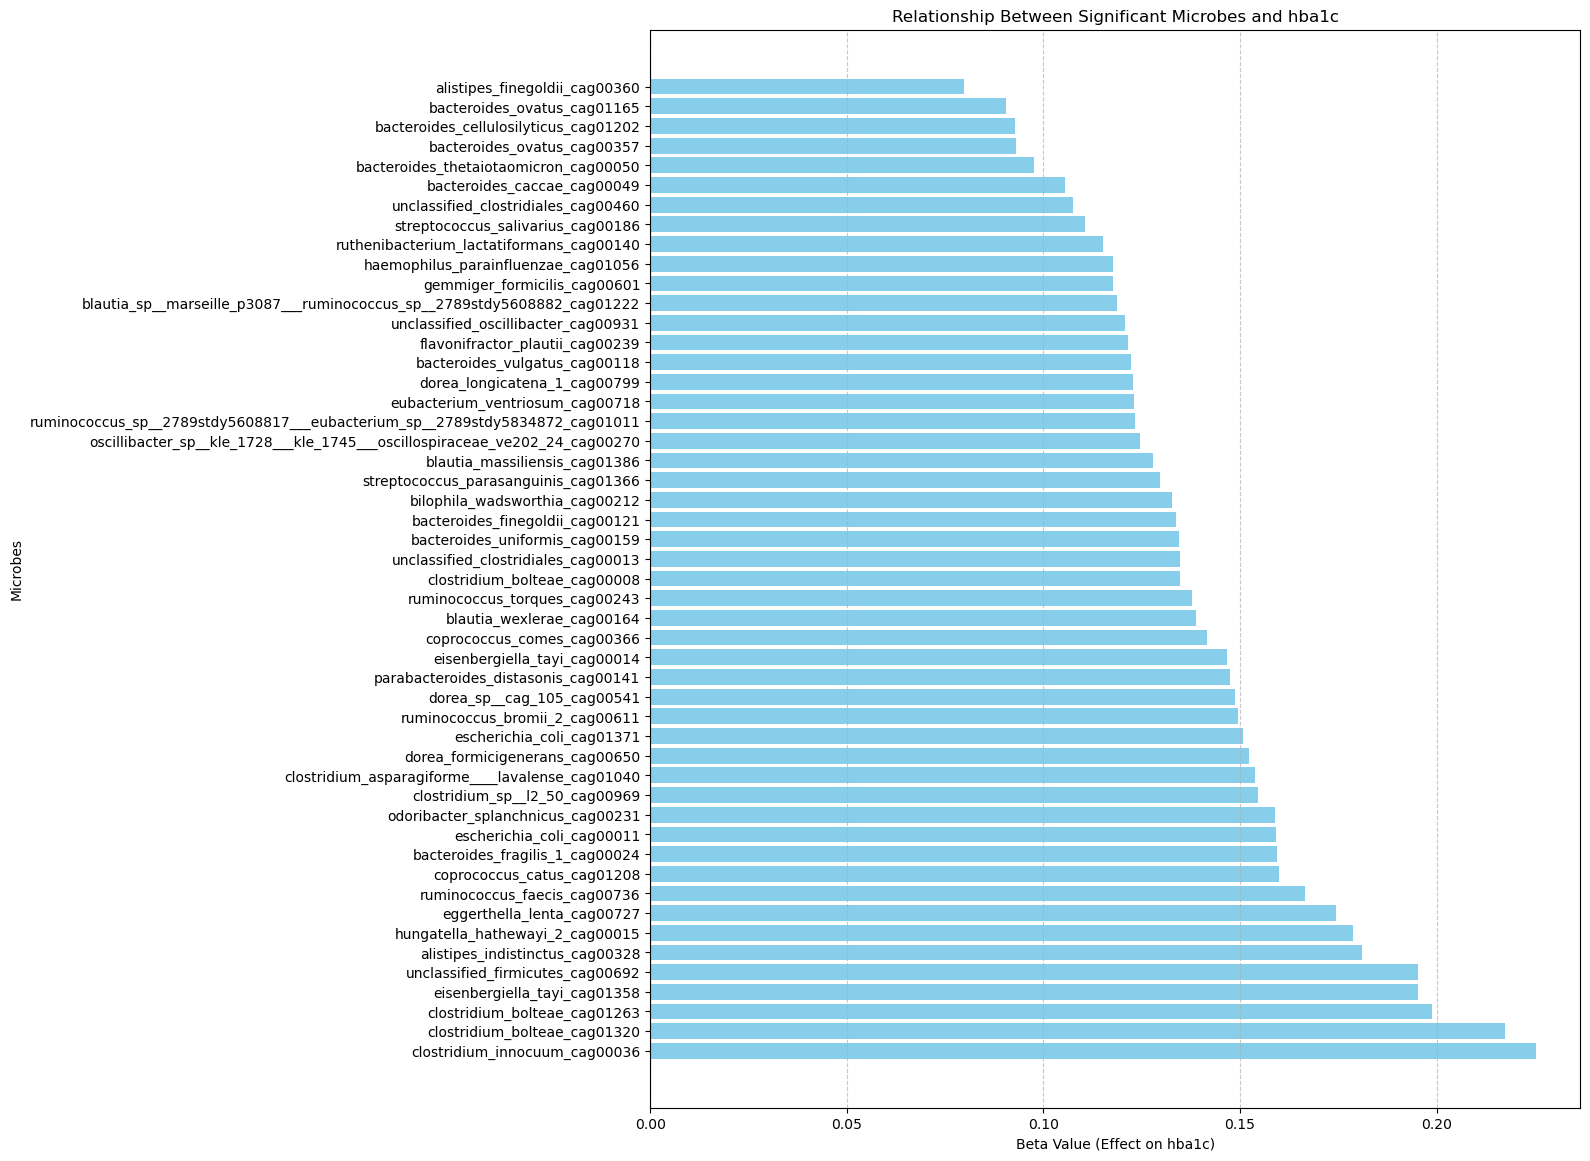

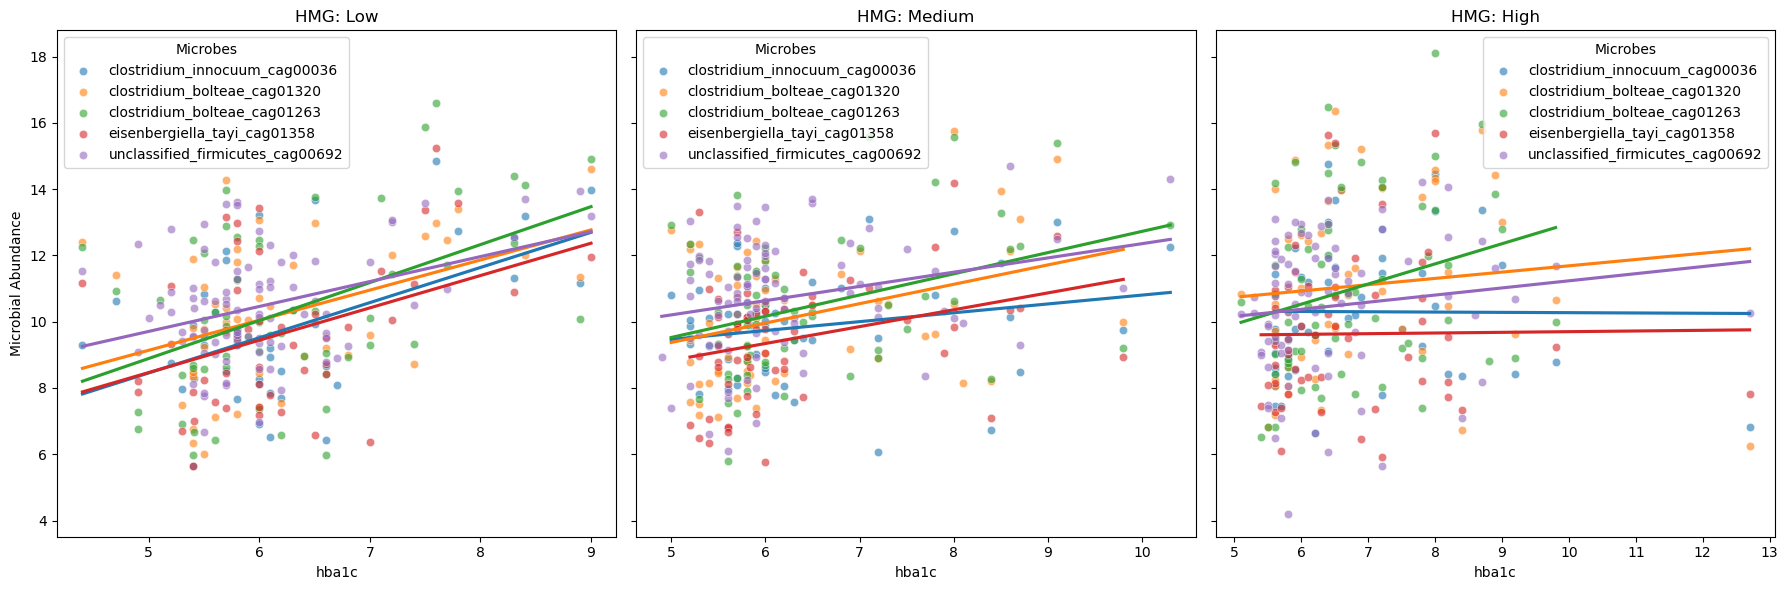

In [677]:
import matplotlib.pyplot as plt

# read microbes hba1c regression
df = pd.read_csv("sig_alc_microbe.csv")

# Sort microbes by beta values for better visualization
df_sorted = df.sort_values(by="beta", ascending=False)

# Plot beta values for each microbe
plt.figure(figsize=(12, 14))
plt.barh(df_sorted["independent_feature"], df_sorted["beta"], color="skyblue")
plt.xlabel("Beta Value (Effect on hba1c)")
plt.ylabel("Microbes")
plt.title("Relationship Between Significant Microbes and hba1c")
plt.axvline(x=0, color="gray", linestyle="--")  # Reference line at zero
plt.grid(axis="x", linestyle="--", alpha=0.7)

# Show the plot
plt.show()

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Bin HMG into "Low", "Medium", and "High"
microbes["HMG_bin"] = pd.qcut(microbes["HMG"], q=3, labels=["Low", "Medium", "High"])

# Get the top 5 microbes based on the higest beta values from df
top_microbes = df_sorted["independent_feature"].head(5).tolist()

# Create scatter plots for each HMG bin
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for i, (bin_label, ax) in enumerate(zip(["Low", "Medium", "High"], axes)):
    # Filter data for the current bin
    bin_data = microbes[microbes["HMG_bin"] == bin_label]
    
    # Create scatter plots with regression lines for each of the top 5 microbes
    for microbe in top_microbes:
        sns.scatterplot(x=bin_data["hba1c"], y=bin_data[microbe], label=microbe, ax=ax, alpha=0.6)
        sns.regplot(x="hba1c", y=microbe, data=bin_data, scatter=False, ax=ax, ci=None)

    ax.set_title(f"HMG: {bin_label}")
    ax.set_xlabel("hba1c")
    ax.set_ylabel("Microbial Abundance")
    ax.legend(title="Microbes")

plt.tight_layout()
plt.show()





/var/folders/0p/3l67fvd177l7t51yqw473srr0000gn/T/ipykernel_37659/2379168276.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_statin[food_features_95] = df_statin[food_features_95].applymap(lambda x: 1 if x > 0 else 0)


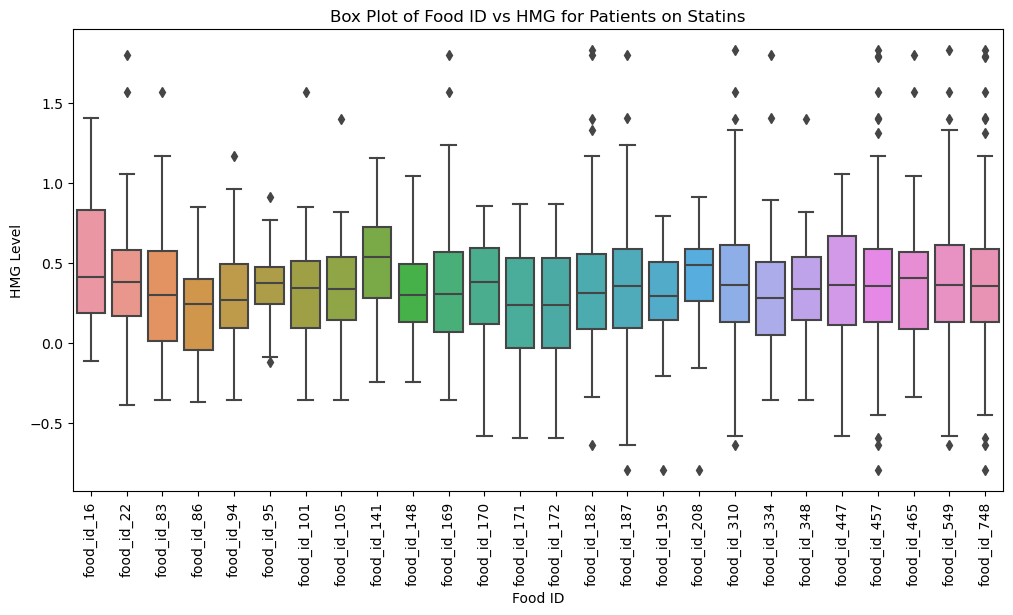

/var/folders/0p/3l67fvd177l7t51yqw473srr0000gn/T/ipykernel_37659/2379168276.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_statin[food_columns] = df_statin[food_columns].applymap(lambda x: 1 if x > 0 else 0)


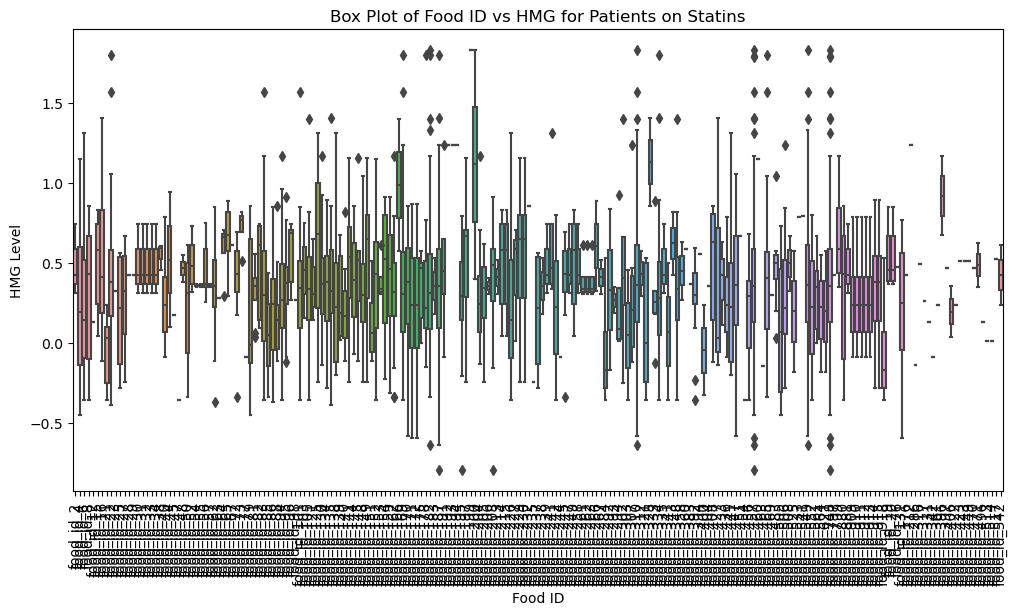

In [235]:
# Read the dataset
diet_df = pd.read_csv("biomarkers_diet_cov.csv")
# New Box Plot for Patients with Statin = 1
# Filter dataset for patients with Statin = 1
df_statin = diet_df[diet_df['Statin'] == 1].copy()

# Convert food_id_* values greater than 0 to 1 (only for food_features_95)
df_statin[food_features_95] = df_statin[food_features_95].applymap(lambda x: 1 if x > 0 else 0)

# Melt the dataframe for visualization
df_melted = df_statin.melt(id_vars=['HMG'], value_vars=food_features_95, var_name='Food ID', value_name='Presence')

# Filter only presence values
df_melted = df_melted[df_melted['Presence'] == 1]

# Create the box plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='Food ID', y='HMG', data=df_melted)
plt.xticks(rotation=90)
plt.xlabel("Food ID")
plt.ylabel("HMG Level")
plt.title("Box Plot of Food ID vs HMG for Patients on Statins")
plt.show()

# Convert food_id_* values greater than 0 to 1
food_columns = [col for col in df_statin.columns if col.startswith('food_id_')]
df_statin[food_columns] = df_statin[food_columns].applymap(lambda x: 1 if x > 0 else 0)

# Melt the dataframe for visualization
df_melted = df_statin.melt(id_vars=['HMG'], value_vars=food_columns, var_name='Food ID', value_name='Presence')

# Filter only presence values
df_melted = df_melted[df_melted['Presence'] == 1]

# Create the box plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='Food ID', y='HMG', data=df_melted)
plt.xticks(rotation=90)
plt.xlabel("Food ID")
plt.ylabel("HMG Level")
plt.title("Box Plot of Food ID vs HMG for Patients on Statins")
plt.show()


/Users/amobrian/anaconda3/envs/Winter2025/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/amobrian/anaconda3/envs/Winter2025/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/amobrian/anaconda3/envs/Winter2025/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/var/folders/0p/3l67fvd177l7t51yqw473srr0000gn/T/ipykernel_10217/846681

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/amobrian/anaconda3/envs/Winter2025/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/amobrian/anaconda3/envs/Winter2025/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


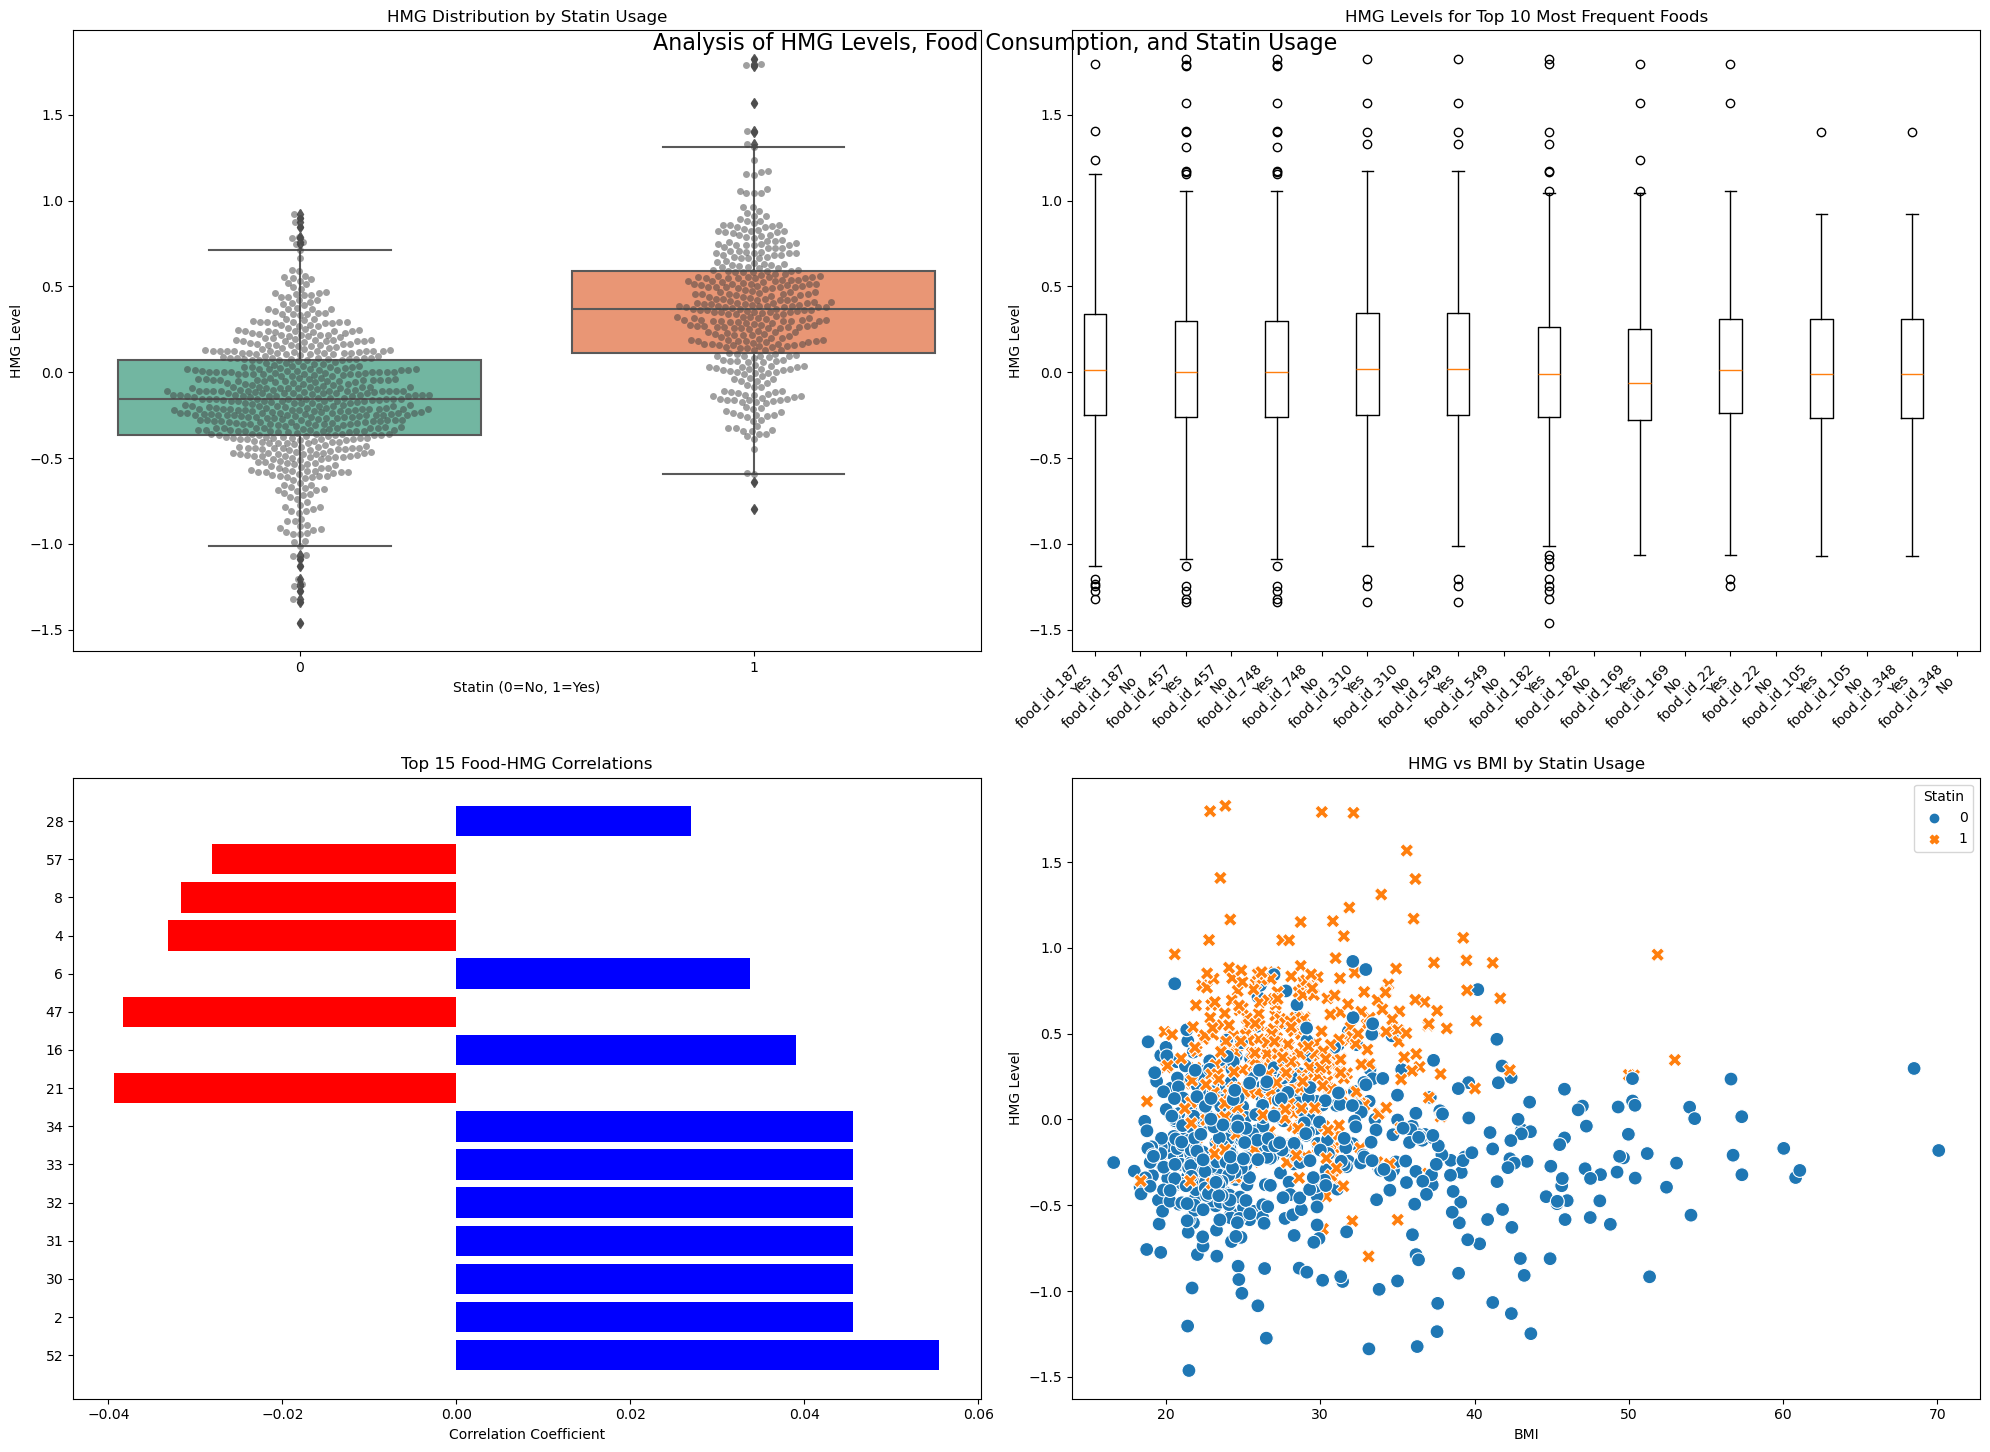


Statistical Summary:
                        Metric               Value
           Mean HMG (Statin=1)                0.37
           Mean HMG (Statin=0)               -0.16
            Most frequent food         food_id_187
Strongest positive correlation  food_id_465: 0.108
Strongest negative correlation food_id_182: -0.089


In [458]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Read the dataset
diet_df = pd.read_csv("biomarkers_diet_cov.csv")
food_columns = [col for col in diet_df.columns if col.startswith('food_id_')]

# Create a figure with multiple subplots

fig = plt.figure(figsize=(20, 15))
fig.suptitle('Analysis of HMG Levels, Food Consumption, and Statin Usage', fontsize=16, y=0.95)

# 1. Top left: Distribution of HMG levels by Statin usage
ax1 = plt.subplot(2, 2, 1)
sns.boxplot(x='Statin', y='HMG', data=diet_df, palette='Set2')
sns.swarmplot(x='Statin', y='HMG', data=diet_df, color='0.25', alpha=0.5)
plt.title('HMG Distribution by Statin Usage')
plt.xlabel('Statin (0=No, 1=Yes)')
plt.ylabel('HMG Level')

# 2. Top right: Top 10 most frequent foods and their impact on HMG
# Calculate food frequency
food_freq = diet_df[food_columns].applymap(lambda x: 1 if x > 0 else 0).sum()
top_10_foods = food_freq.nlargest(10).index

# Create boxplot for top 10 foods
ax2 = plt.subplot(2, 2, 2)
plot_data = []
labels = []
for food in top_10_foods:
    has_food = diet_df[diet_df[food] > 0]['HMG']
    no_food = diet_df[diet_df[food] == 0]['HMG']
    plot_data.extend([has_food, no_food])
    labels.extend([f'{food}\nYes', f'{food}\nNo'])

plt.boxplot(plot_data, labels=labels)
plt.xticks(rotation=45, ha='right')
plt.title('HMG Levels for Top 10 Most Frequent Foods')
plt.ylabel('HMG Level')

# 3. Bottom left: Correlation between food consumption and HMG
ax3 = plt.subplot(2, 2, 3)
# Calculate correlation between food consumption and HMG
correlations = []
for food in food_columns:
    corr = np.corrcoef(diet_df[food] > 0, diet_df['HMG'])[0,1]
    correlations.append((food, corr))

# Plot top absolute correlations
top_correlations = sorted(correlations, key=lambda x: abs(x[1]), reverse=True)[:15]
foods, corrs = zip(*top_correlations)
colors = ['red' if c < 0 else 'blue' for c in corrs]
plt.barh(range(len(foods)), corrs, color=colors)
plt.yticks(range(len(foods)), [f.replace('food_id_', '') for f in foods])
plt.title('Top 15 Food-HMG Correlations')
plt.xlabel('Correlation Coefficient')

# 4. Bottom right: Scatter plot of HMG vs BMI with Statin indication
ax4 = plt.subplot(2, 2, 4)
if 'BMI' in diet_df.columns:  # Check if BMI exists in the dataset
    sns.scatterplot(data=diet_df, x='BMI', y='HMG', hue='Statin', style='Statin', s=100)
    plt.title('HMG vs BMI by Statin Usage')
    plt.xlabel('BMI')
    plt.ylabel('HMG Level')
else:
    # Alternative plot if BMI is not available
    sns.histplot(data=diet_df, x='HMG', hue='Statin', multiple="layer", alpha=.5)
    plt.title('Distribution of HMG Levels by Statin Usage')
    plt.xlabel('HMG Level')
    plt.ylabel('Count')

# Adjust layout
plt.tight_layout()
plt.show()

# Additional statistical summary
summary_stats = pd.DataFrame({
    'Metric': [
        'Mean HMG (Statin=1)',
        'Mean HMG (Statin=0)',
        'Most frequent food',
        'Strongest positive correlation',
        'Strongest negative correlation'
    ],
    'Value': [
        f"{diet_df[diet_df['Statin']==1]['HMG'].mean():.2f}",
        f"{diet_df[diet_df['Statin']==0]['HMG'].mean():.2f}",
        food_freq.idxmax(),
        f"{max(correlations, key=lambda x: x[1])[0]}: {max(correlations, key=lambda x: x[1])[1]:.3f}",
        f"{min(correlations, key=lambda x: x[1])[0]}: {min(correlations, key=lambda x: x[1])[1]:.3f}"
    ]
})
print("\nStatistical Summary:")
print(summary_stats.to_string(index=False))

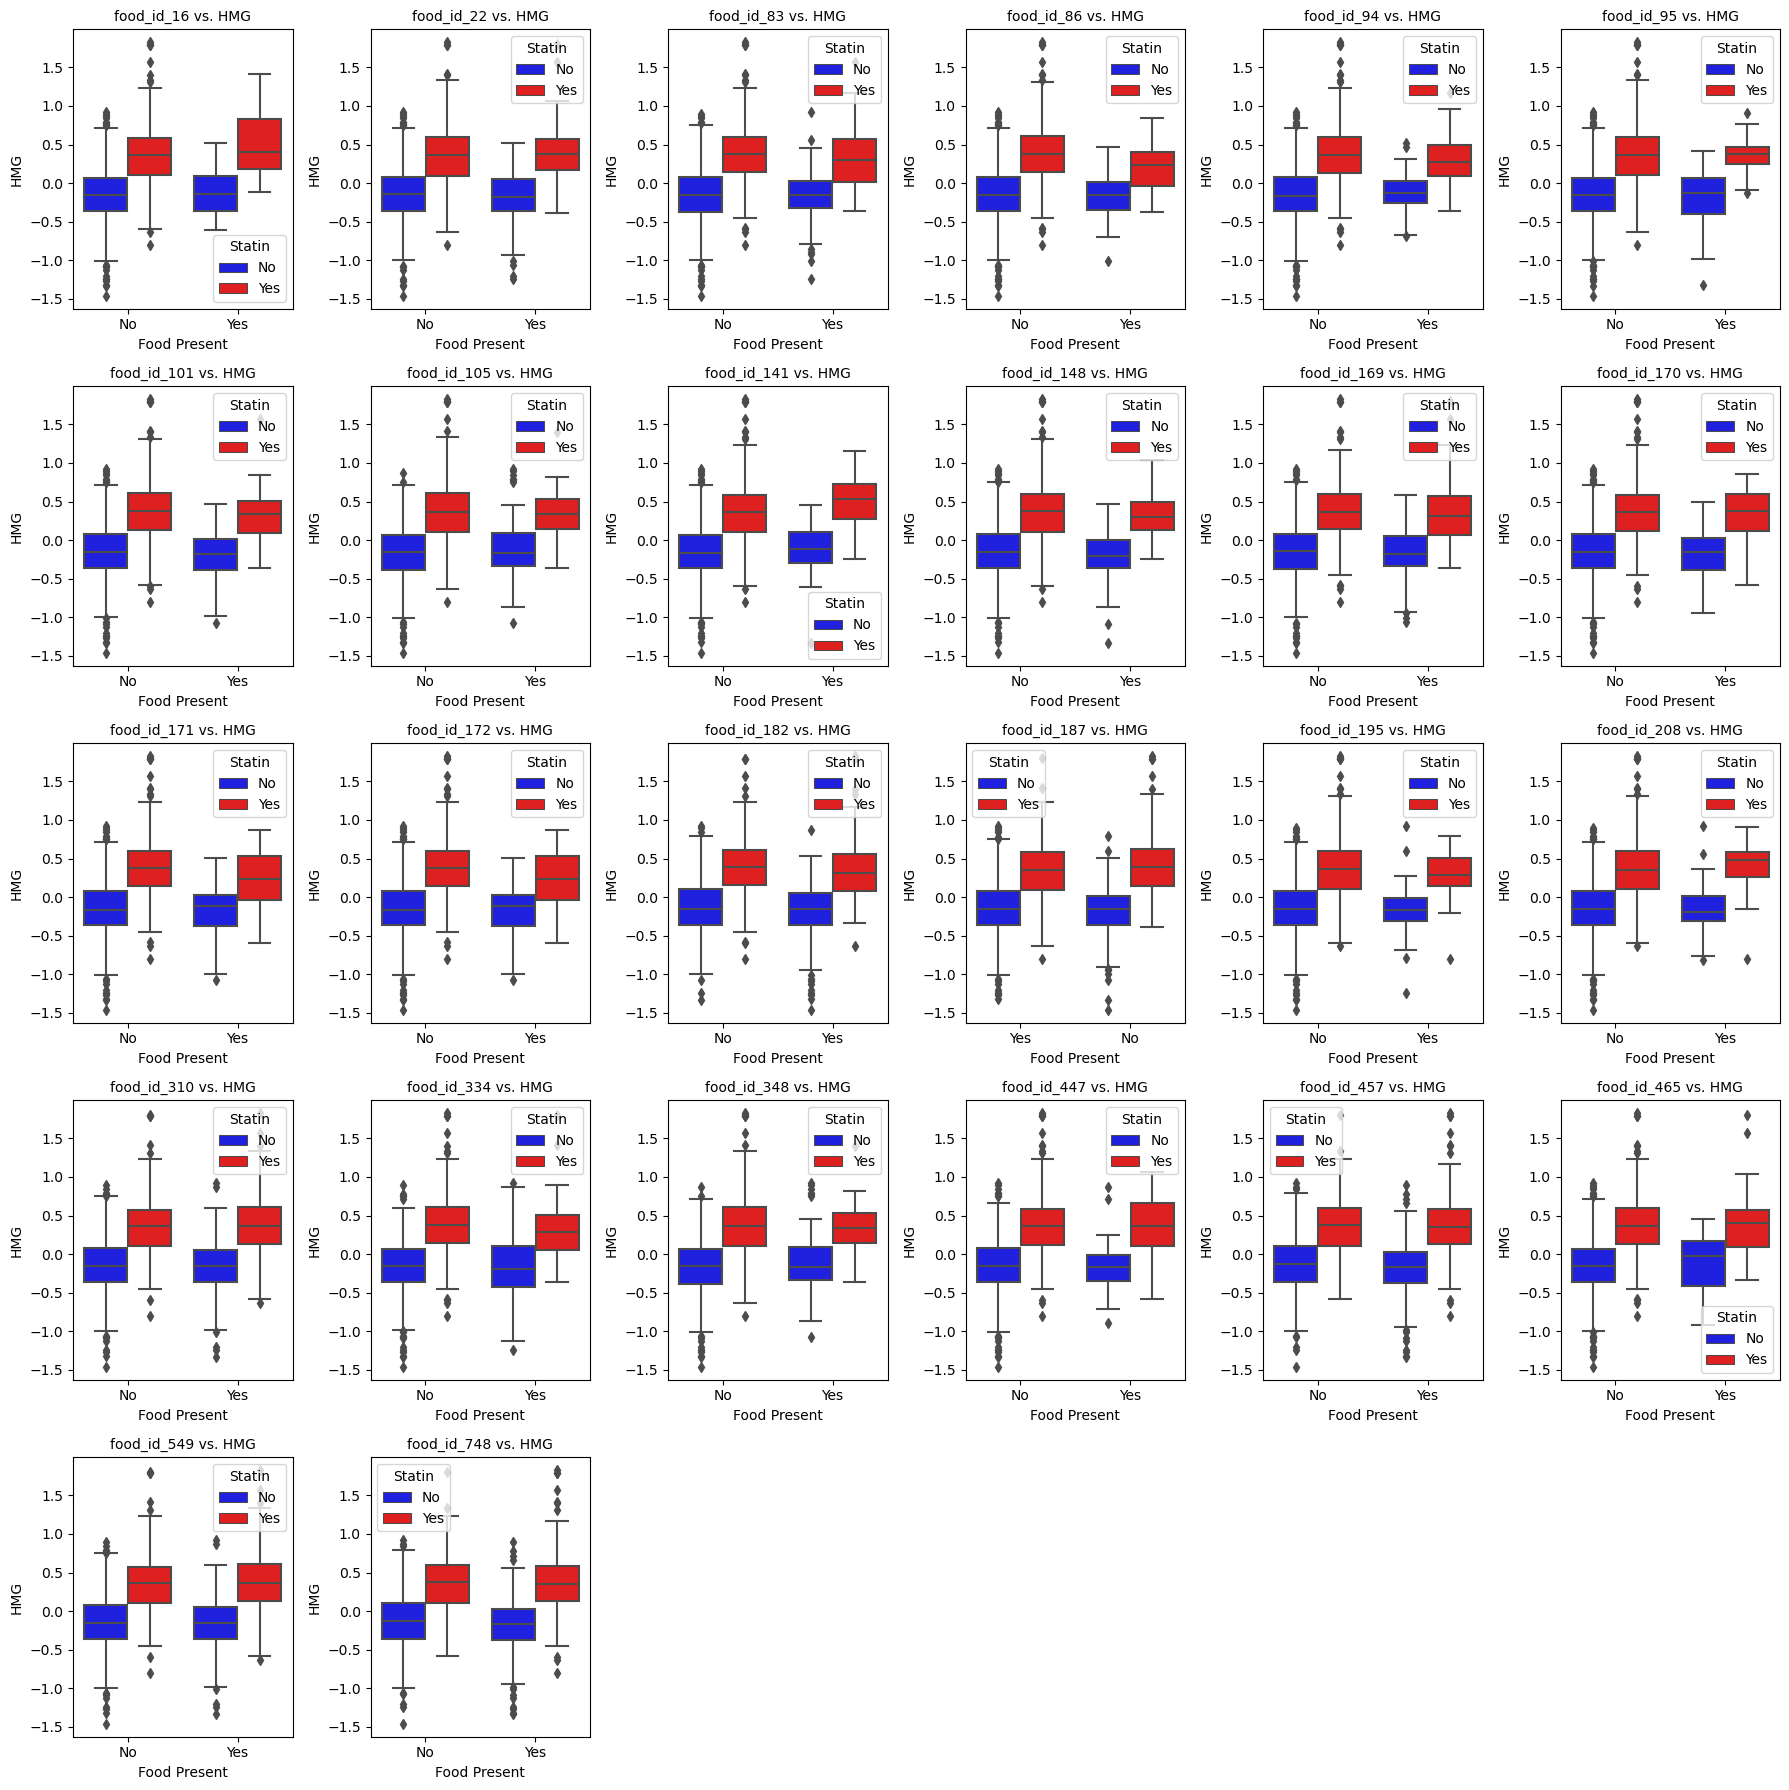

In [315]:
# Read the dataset
diet_df = pd.read_csv("biomarkers_diet_cov.csv")

# Convert Statin values to Yes/No
diet_df["Statin"] = diet_df["Statin"].map({1: "Yes", 0: "No"})

# Determine subplot grid size
num_plots = len(food_features_95)
cols = 6  # Number of columns in the subplot grid
rows = int(np.ceil(num_plots / cols))

# Create a figure with multiple subplots
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(18, 18))
axes = axes.flatten()

# Loop through each food ID and generate box plots
for i, food_id in enumerate(food_features_95):
    ax = axes[i]

    # Create a binary variable: whether the food item was consumed (Yes/No)
    diet_df["Food_Present"] = np.where(diet_df[food_id] > 0, "Yes", "No")

    # Create the boxplot
    sns.boxplot(x="Food_Present", y="HMG", hue="Statin", data=diet_df, ax=ax, palette={"Yes": "red", "No": "blue"})
    
    # Set labels and title
    ax.set_xlabel("Food Present")
    ax.set_ylabel("HMG")
    ax.set_title(f"{food_id} vs. HMG", fontsize=10)

    # Adjust legend
    ax.legend(title="Statin")

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout for clarity
plt.tight_layout()
plt.show()

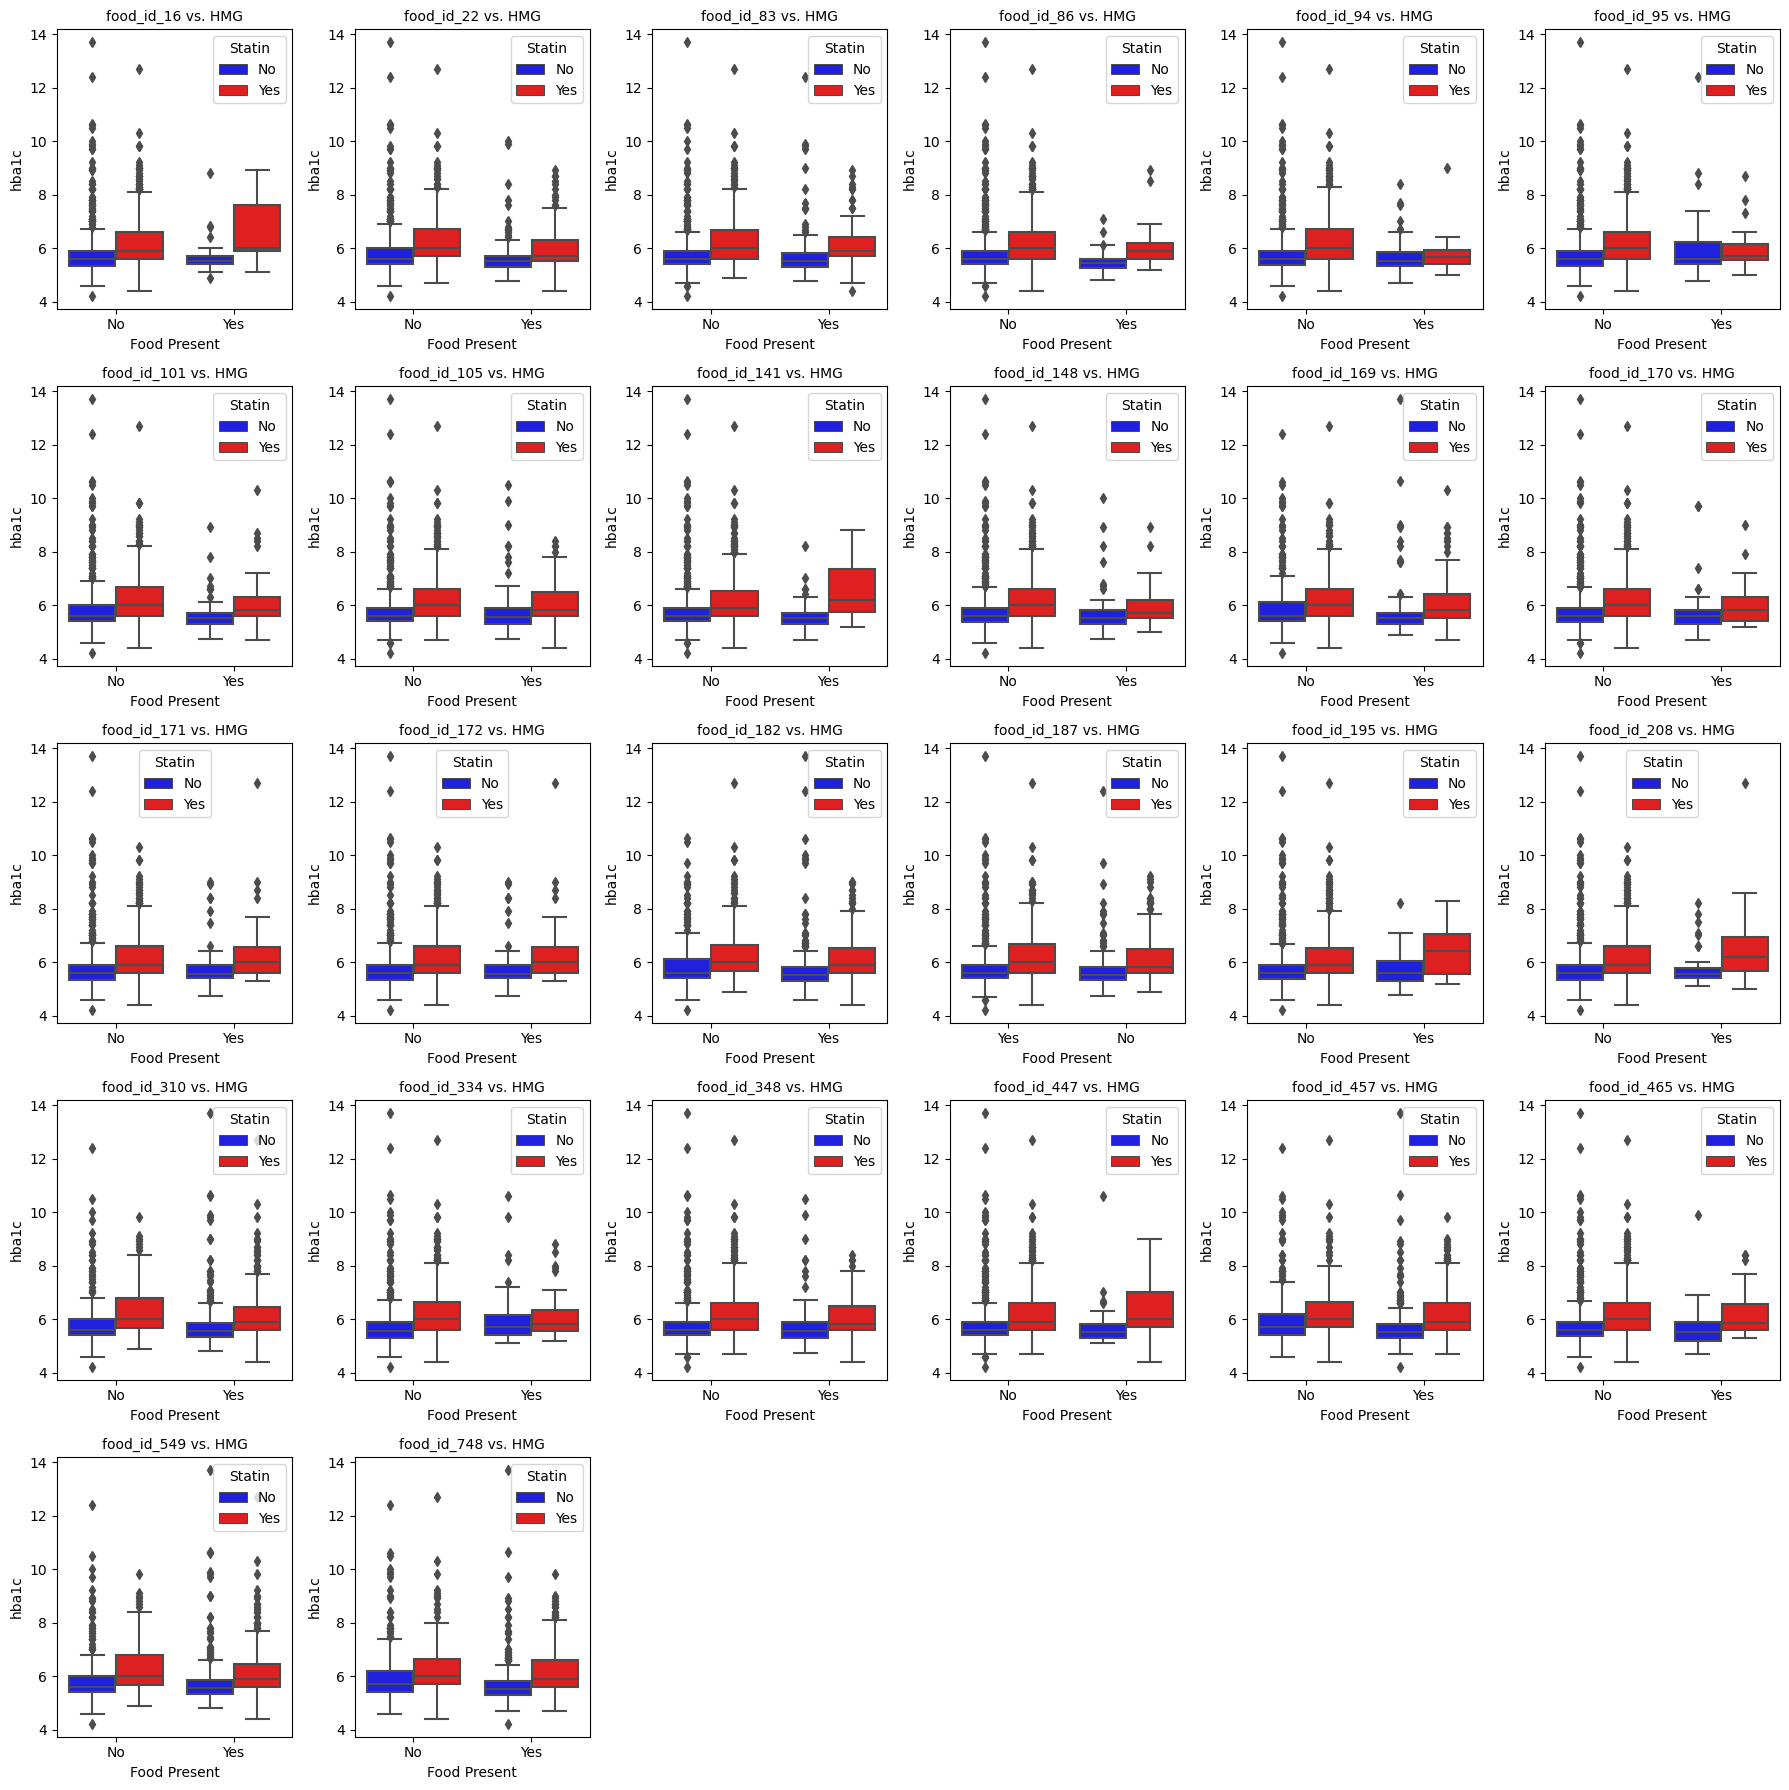

In [316]:
# Read the dataset
diet_df = pd.read_csv("biomarkers_diet_cov.csv")

# Convert Statin values to Yes/No
diet_df["Statin"] = diet_df["Statin"].map({1: "Yes", 0: "No"})

# Determine subplot grid size
num_plots = len(food_features_95)
cols = 6  # Number of columns in the subplot grid
rows = int(np.ceil(num_plots / cols))

# Create a figure with multiple subplots
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(18, 18))
axes = axes.flatten()

# Loop through each food ID and generate box plots
for i, food_id in enumerate(food_features_95):
    ax = axes[i]

    # Create a binary variable: whether the food item was consumed (Yes/No)
    diet_df["Food_Present"] = np.where(diet_df[food_id] > 0, "Yes", "No")

    # Create the boxplot
    sns.boxplot(x="Food_Present", y="hba1c", hue="Statin", data=diet_df, ax=ax, palette={"Yes": "red", "No": "blue"})
    
    # Set labels and title
    ax.set_xlabel("Food Present")
    ax.set_ylabel("hba1c")
    ax.set_title(f"{food_id} vs. HMG", fontsize=10)

    # Adjust legend
    ax.legend(title="Statin")

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout for clarity
plt.tight_layout()
plt.show()

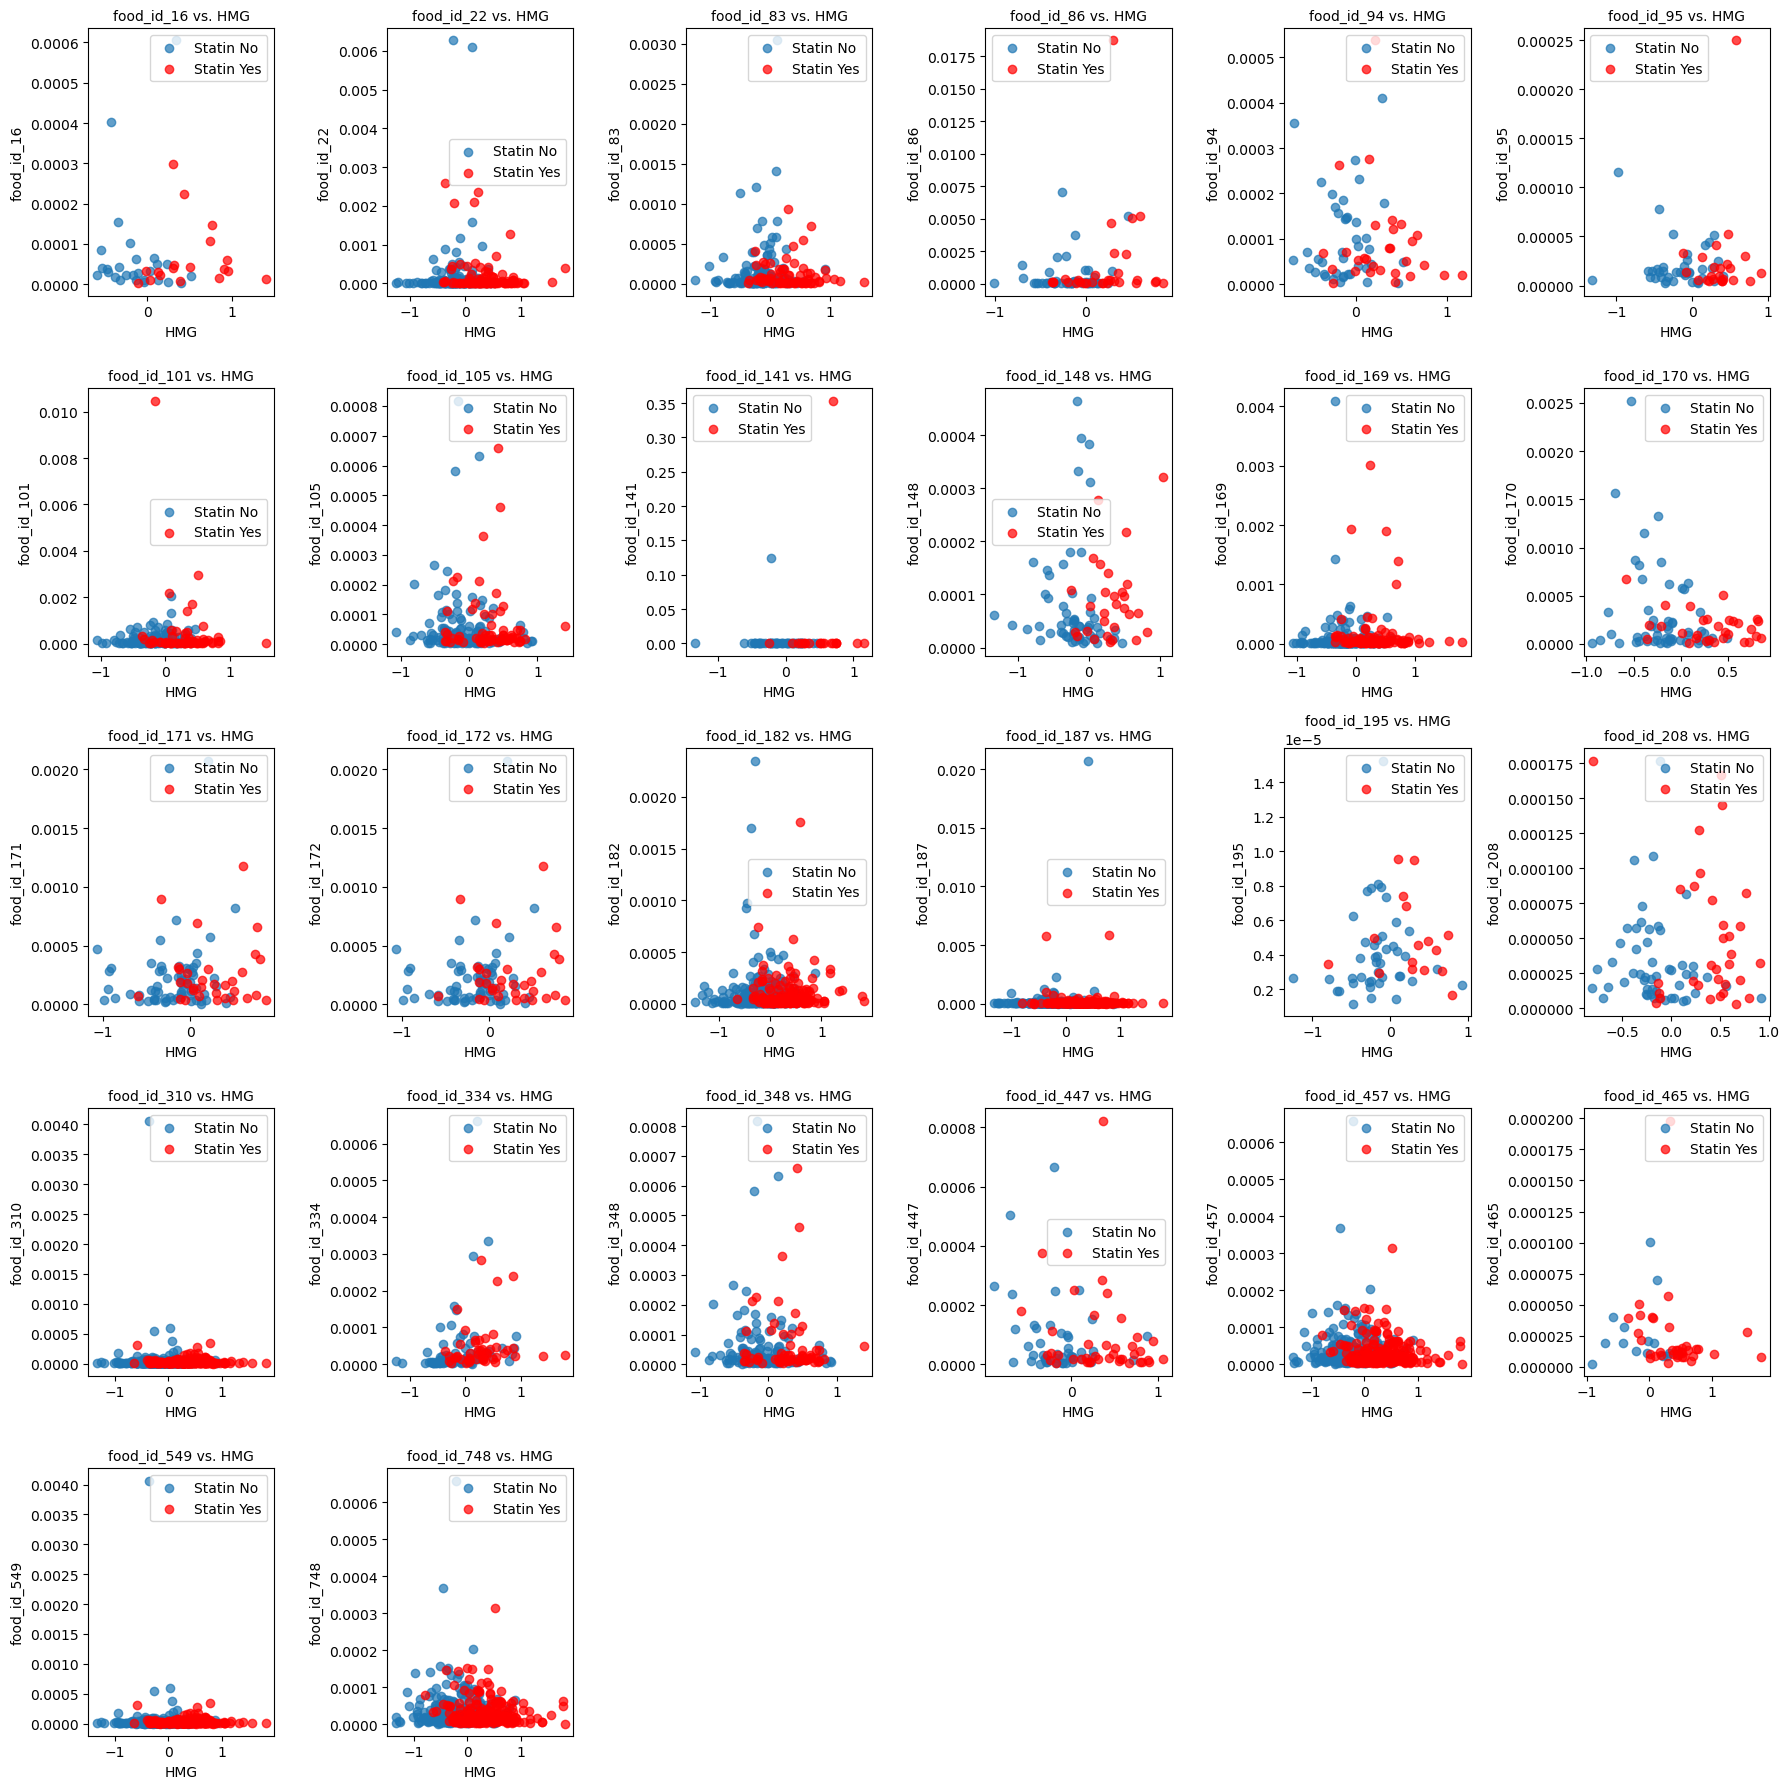

In [484]:
# Read the dataset
diet_df = pd.read_csv("biomarkers_diet_cov.csv")

# Convert Statin values to Yes/No
diet_df["Statin"] = diet_df["Statin"].map({1: "Yes", 0: "No"})

# Determine subplot grid size
num_plots = len(food_features_95)
cols = 6
rows = int(np.ceil(num_plots / cols))

# Create a single figure with multiple subplots
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(18, 18))
axes = axes.flatten()

# Loop through each food ID and generate scatter plots
for i, food_id in enumerate(food_features_95):
    ax = axes[i]
    ax.scatter(diet_df[diet_df["Statin"] == "No"]["HMG"], diet_df[diet_df["Statin"] == "No"][food_id], 
               label="Statin No", alpha=0.7)
    ax.scatter(diet_df[diet_df["Statin"] == "Yes"]["HMG"], diet_df[diet_df["Statin"] == "Yes"][food_id], 
               color="red", label="Statin Yes", alpha=0.7)
    
    # Set labels and title
    ax.set_xlabel("HMG")
    ax.set_ylabel(food_id)
    ax.set_title(f"{food_id} vs. HMG", fontsize=10)
    ax.legend()

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout for clarity
plt.tight_layout()
plt.show()


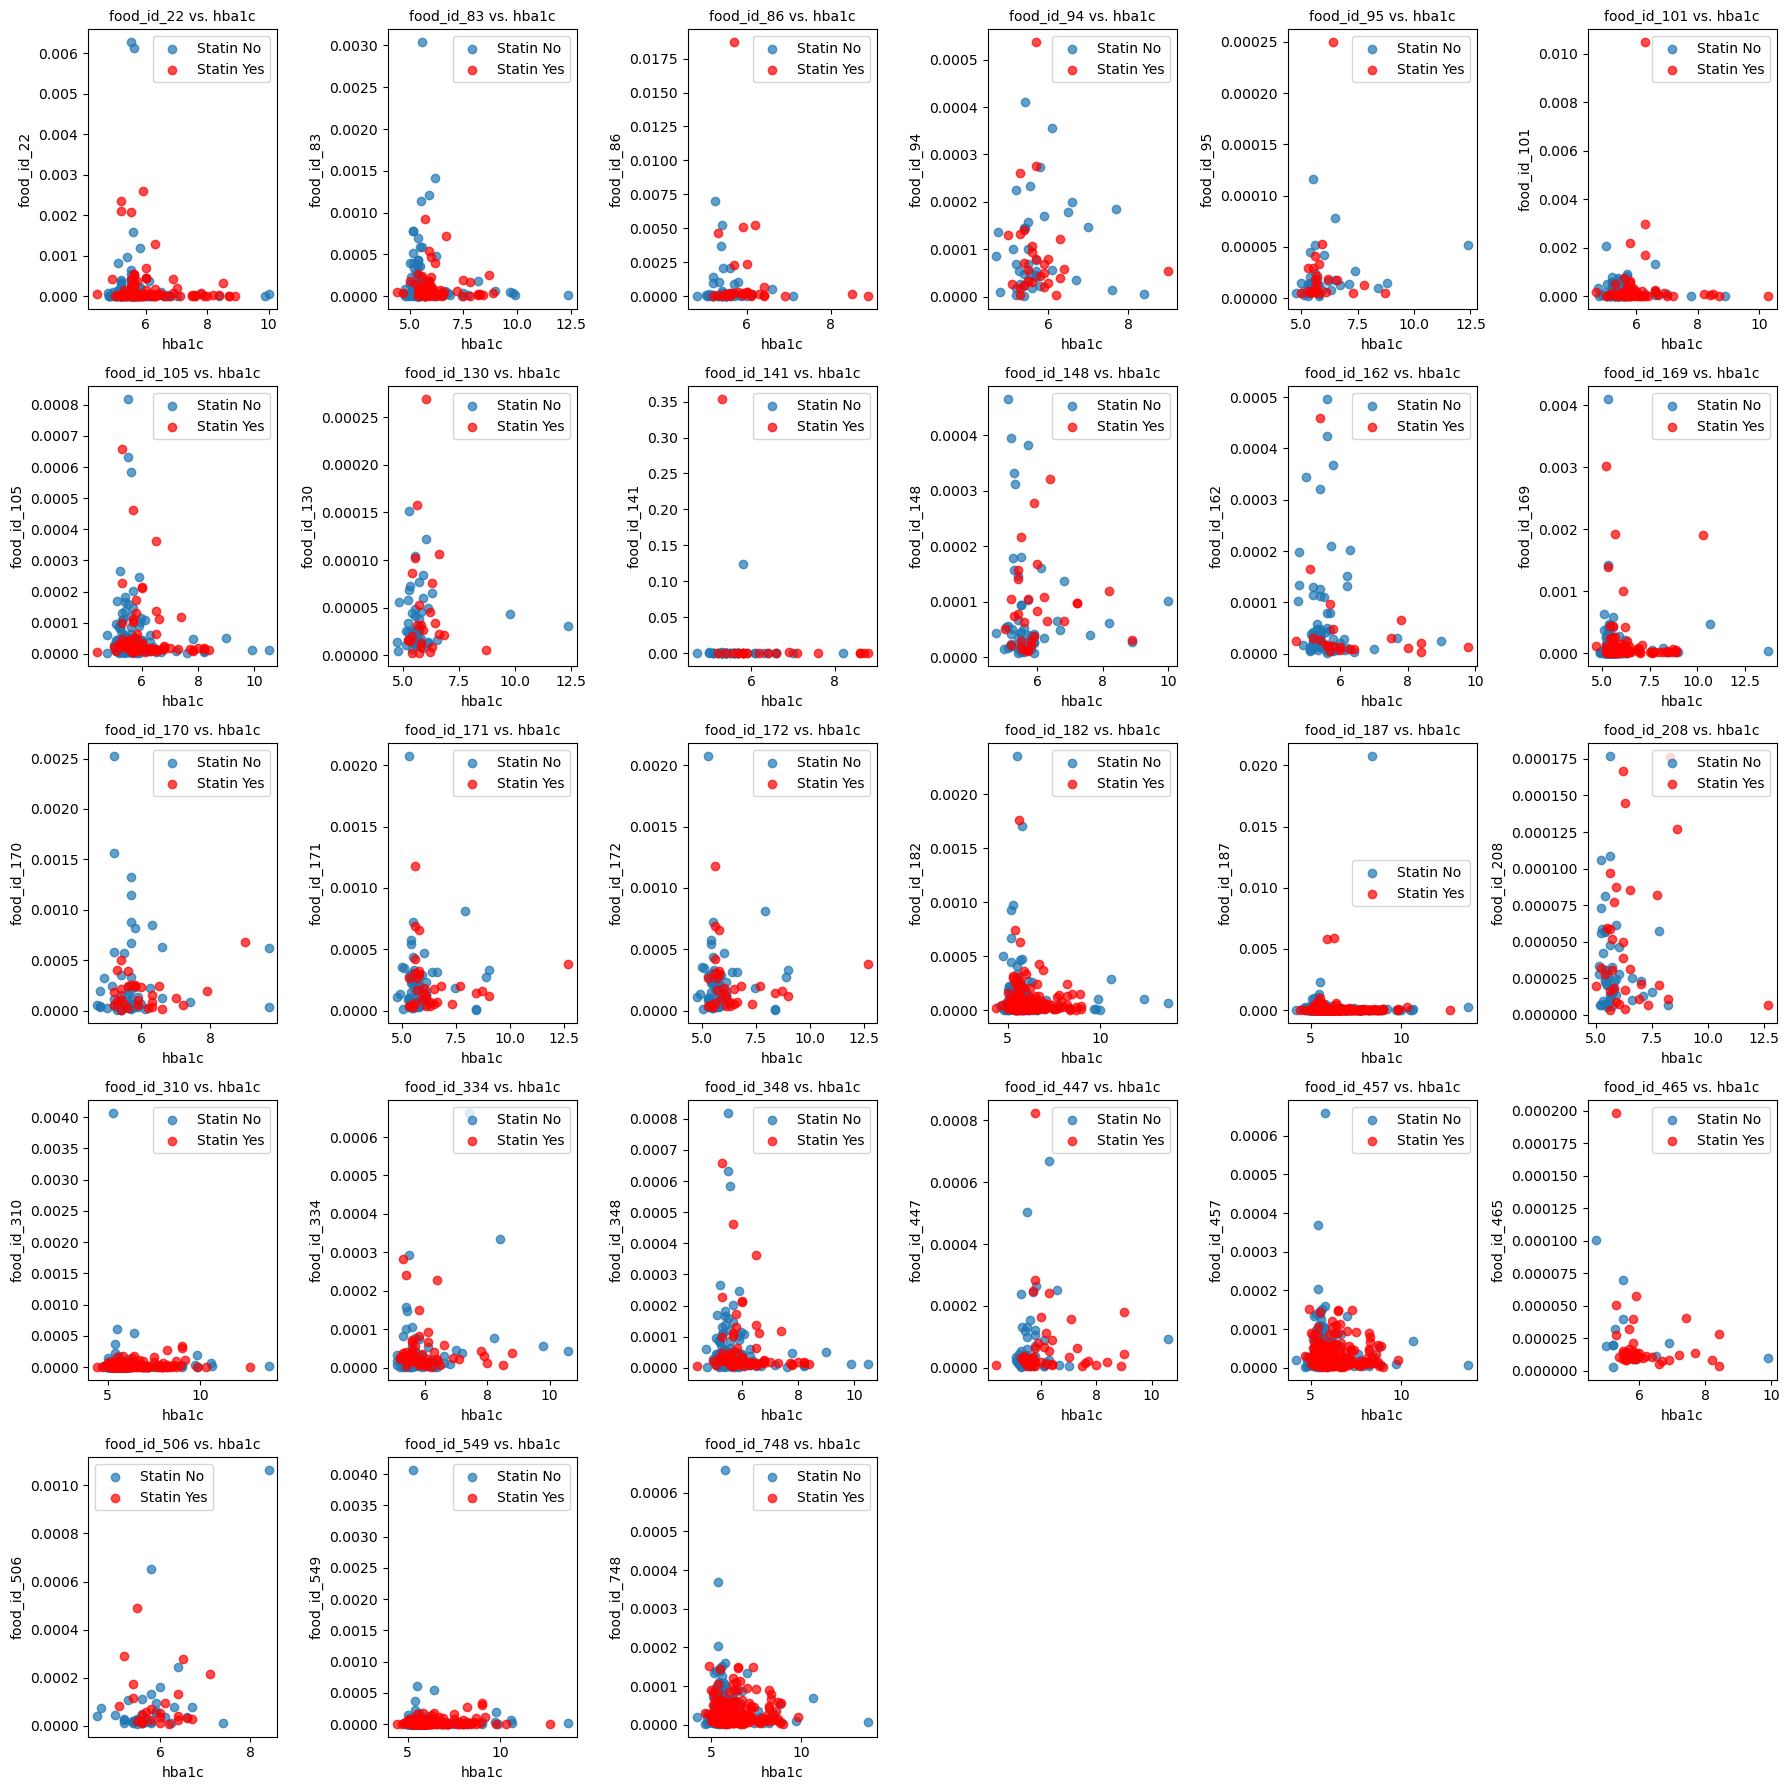

In [475]:
# Read the dataset
diet_df = pd.read_csv("biomarkers_diet_cov.csv")

# Convert Statin values to Yes/No
diet_df["Statin"] = diet_df["Statin"].map({1: "Yes", 0: "No"})

# Determine subplot grid size
num_plots = len(food_features_95)
cols = 6
rows = int(np.ceil(num_plots / cols))

# Create a single figure with multiple subplots
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(18, 18))
axes = axes.flatten()

# Loop through each food ID and generate scatter plots
for i, food_id in enumerate(food_features_95):
    ax = axes[i]
    ax.scatter(diet_df[diet_df["Statin"] == "No"]["hba1c"], diet_df[diet_df["Statin"] == "No"][food_id], 
               label="Statin No", alpha=0.7)
    ax.scatter(diet_df[diet_df["Statin"] == "Yes"]["hba1c"], diet_df[diet_df["Statin"] == "Yes"][food_id], 
               color="red", label="Statin Yes", alpha=0.7)
    
    # Set labels and title
    ax.set_xlabel("hba1c")
    ax.set_ylabel(food_id)
    ax.set_title(f"{food_id} vs. hba1c", fontsize=10)
    ax.legend()

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout for clarity
plt.tight_layout()
plt.show()

/Users/amobrian/anaconda3/envs/Winter2025/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


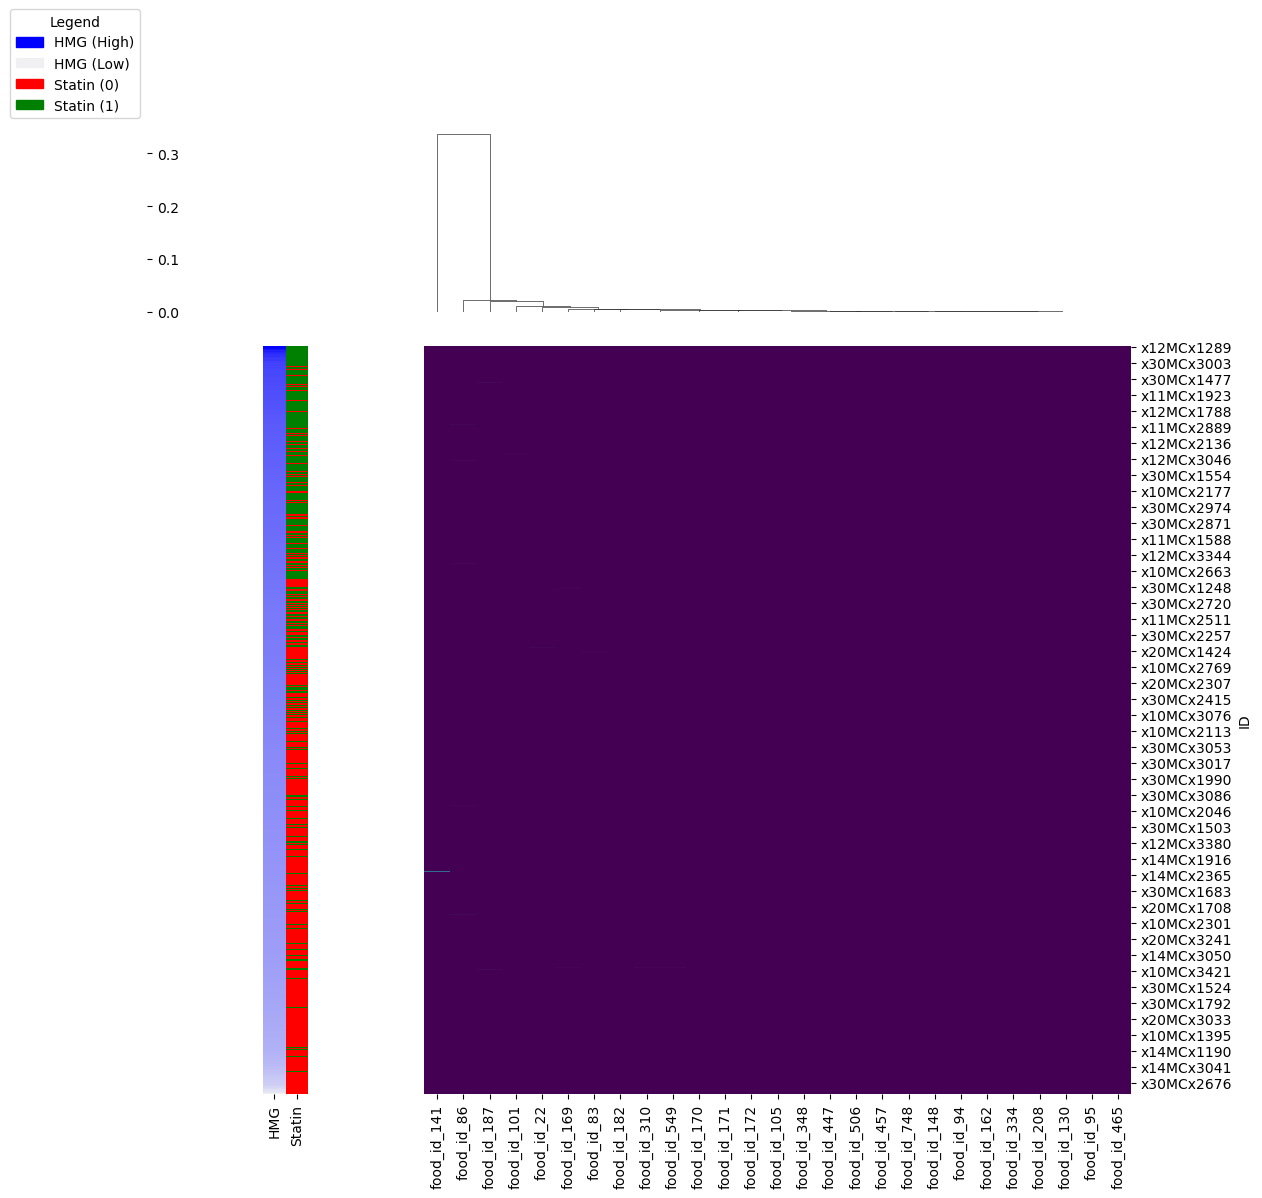

In [478]:
import matplotlib.patches as mpatches
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv('biomarkers_diet_cov.csv')

# Selecting the relevant columns: ID, HMG, Statin, and food_id_95-related columns
selected_columns = ['ID', 'HMG', 'Statin'] + food_features_95

# Filtering the dataset with selected columns
df_selected = data[selected_columns].set_index("ID")

# Convert all values to numeric for clustering, filling NaNs with 0
df_selected = df_selected.apply(pd.to_numeric, errors='coerce').fillna(0)

# Sort the dataset by HMG values (High to Low)
df_selected = df_selected.sort_values(by='HMG', ascending=False)

# Extract HMG and Statin for row colors
hmg_colors = df_selected['HMG']
statin_colors = df_selected['Statin']

# Normalize HMG for coloring
hmg_colors_normalized = (hmg_colors - hmg_colors.min()) / (hmg_colors.max() - hmg_colors.min())

# Create color palettes
hmg_palette = sns.light_palette("blue", as_cmap=True)
hmg_colors_mapped = hmg_colors_normalized.apply(lambda x: hmg_palette(x))
statin_palette = {0: 'red', 1: 'green'}
statin_colors_mapped = statin_colors.map(statin_palette)

# Combine colors into a DataFrame for row_colors
row_colors = pd.DataFrame({
    'HMG': hmg_colors_mapped,
    'Statin': statin_colors_mapped
})

# Drop HMG and Statin from the heatmap data but keep the HMG-sorted order
df_heatmap = df_selected.drop(columns=['HMG', 'Statin'])

# Disable row clustering to maintain HMG-based sorting
g = sns.clustermap(
    df_heatmap,
    method='average',
    metric='euclidean',
    z_score=None,
    standard_scale=None,
    figsize=(12, 12),
    row_cluster=False,  # Disable row clustering to maintain HMG-based sort
    col_cluster=True,
    cbar_pos=(0.02, 0.8, 0.05, 0.18),
    cmap='viridis',
    row_colors=row_colors,
    dendrogram_ratio=(0, 0.2),  # Adjust ratio since row clustering is disabled
    colors_ratio=0.03
)

# Create legend patches
hmg_low_patch = mpatches.Patch(color=hmg_palette(0.0), label='HMG (Low)')
hmg_high_patch = mpatches.Patch(color=hmg_palette(1.0), label='HMG (High)')
statin_0_patch = mpatches.Patch(color='red', label='Statin (0)')
statin_1_patch = mpatches.Patch(color='green', label='Statin (1)')

# Add legend
plt.legend(
    handles=[hmg_high_patch, hmg_low_patch, statin_0_patch, statin_1_patch],
    bbox_to_anchor=(1.05, 1),
    loc='lower right',
    title='Legend'
)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

/Users/amobrian/anaconda3/envs/Winter2025/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


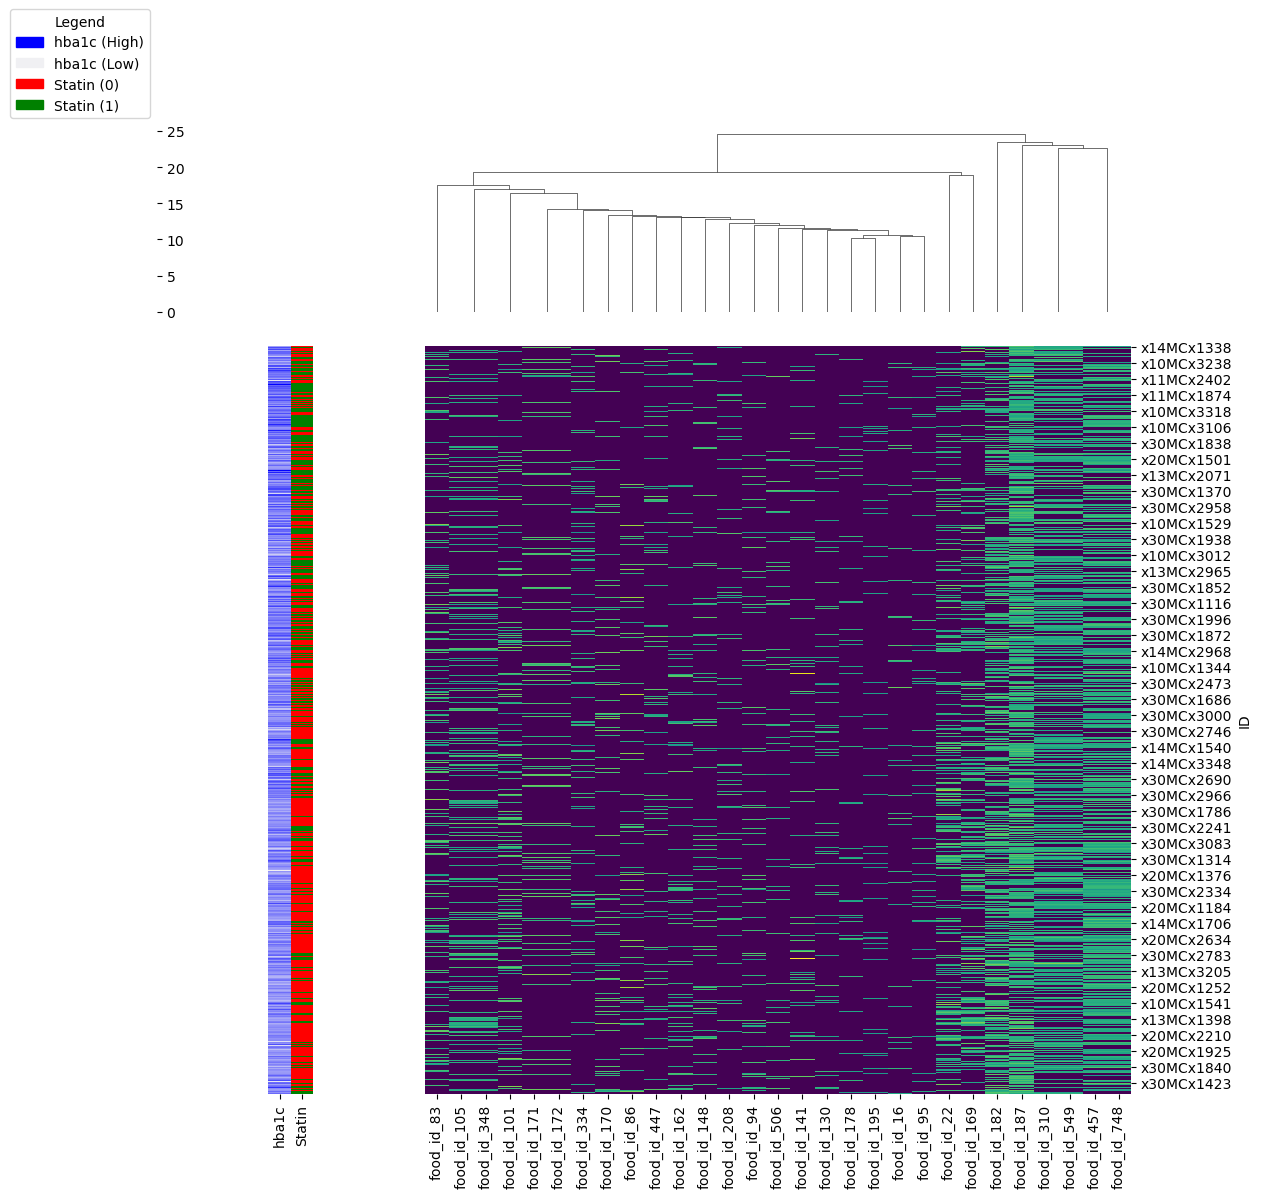

In [451]:
import matplotlib.patches as mpatches
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv('biomarkers_diet_cov.csv')

# Selecting the relevant columns: ID, HMG, Statin, and food_id_95-related columns
selected_columns = ['ID', 'hba1c', 'Statin'] + food_features_95

# Filtering the dataset with selected columns
df_selected = data[selected_columns].set_index("ID")

# Convert all values to numeric for clustering, filling NaNs with 0
df_selected = df_selected.apply(pd.to_numeric, errors='coerce').fillna(0)

# Sort the dataset by HMG values (High to Low)
df_selected = df_selected.sort_values(by='hba1c', ascending=False)

# Extract HMG and Statin for row colors
hba1c_colors = df_selected['hba1c']
statin_colors = df_selected['Statin']

# Normalize hba1c for coloring
hba1c_colors_normalized = (hba1c_colors - hba1c_colors.min()) / (hba1c_colors.max() - hba1c_colors.min())

# Create color palettes
hba1c_palette = sns.light_palette("blue", as_cmap=True)
hba1c_colors_mapped = hmg_colors_normalized.apply(lambda x: hmg_palette(x))
statin_palette = {0: 'red', 1: 'green'}
statin_colors_mapped = statin_colors.map(statin_palette)

# Combine colors into a DataFrame for row_colors
row_colors = pd.DataFrame({
    'hba1c': hba1c_colors_mapped,
    'Statin': statin_colors_mapped
})

# Drop HMG and Statin from the heatmap data but keep the HMG-sorted order
df_heatmap = df_selected.drop(columns=['hba1c', 'Statin'])

# Disable row clustering to maintain HMG-based sorting
g = sns.clustermap(
    df_heatmap,
    method='average',
    metric='euclidean',
    z_score=None,
    standard_scale=None,
    figsize=(12, 12),
    row_cluster=False,  # Disable row clustering to maintain HMG-based sort
    col_cluster=True,
    cbar_pos=(0.02, 0.8, 0.05, 0.18),
    cmap='viridis',
    row_colors=row_colors,
    dendrogram_ratio=(0, 0.2),  # Adjust ratio since row clustering is disabled
    colors_ratio=0.03
)

# Create legend patches
hba1c_low_patch = mpatches.Patch(color=hba1c_palette(0.0), label='hba1c (Low)')
hba1c_high_patch = mpatches.Patch(color=hba1c_palette(1.0), label='hba1c (High)')
statin_0_patch = mpatches.Patch(color='red', label='Statin (0)')
statin_1_patch = mpatches.Patch(color='green', label='Statin (1)')

# Add legend
plt.legend(
    handles=[hba1c_high_patch, hba1c_low_patch, statin_0_patch, statin_1_patch],
    bbox_to_anchor=(1.05, 1),
    loc='lower right',
    title='Legend'
)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

/Users/amobrian/anaconda3/envs/Winter2025/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/amobrian/anaconda3/envs/Winter2025/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


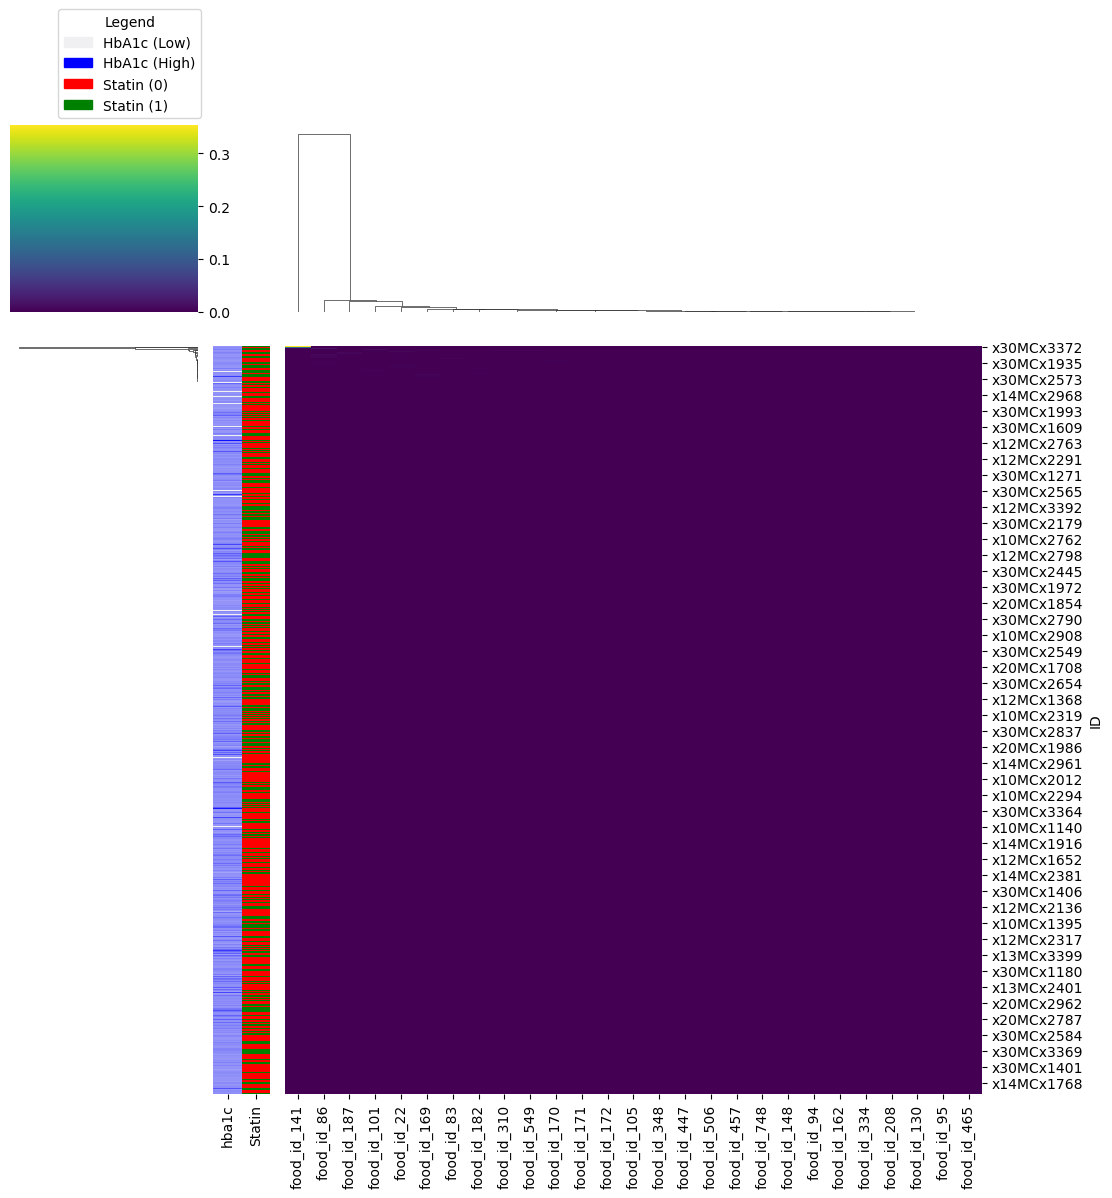

In [479]:
import matplotlib.patches as mpatches
# Load the data
data = pd.read_csv('biomarkers_diet_cov.csv')

# Selecting the relevant columns: ID, HMG, Statin, and food_id_95-related columns
selected_columns = ['ID', 'hba1c', 'Statin'] + food_features_95

# Filtering the dataset with selected columns
df_selected = df[selected_columns].set_index("ID")

# Convert all values to numeric for clustering, filling NaNs with 0
df_selected = df_selected.apply(pd.to_numeric, errors='coerce').fillna(0)

# Extract HMG and Statin for row colors
hba1c_colors = df_selected['hba1c']
statin_colors = df_selected['Statin']

# Normalize HMG for coloring (optional, to make the color scale meaningful)
hba1c_colors_normalized = (hba1c_colors - hba1c_colors.min()) / (hba1c_colors.max() - hba1c_colors.min())

# Create a color palette for HMG (e.g., a gradient from light to dark blue)
hba1c_palette = sns.light_palette("blue", as_cmap=True)
hba1c_colors_mapped = hba1c_colors_normalized.apply(lambda x: hba1c_palette(x))

# Create a color palette for Statin (e.g., binary: red for 0, green for 1)
statin_palette = {0: 'red', 1: 'green'}
statin_colors_mapped = statin_colors.map(statin_palette)

# Combine HMG and Statin colors into a DataFrame for row_colors
row_colors = pd.DataFrame({
    'hba1c': hba1c_colors_mapped,
    'Statin': statin_colors_mapped
})

# Drop HMG and Statin from the main heatmap data
df_heatmap = df_selected.drop(columns=['hba1c', 'Statin'])

# Generate the cluster map
g = sns.clustermap(
    df_heatmap,
    method='average',  # Clustering method
    metric='euclidean',  # Distance metric
    z_score=None,  # No row/column normalization
    standard_scale=None,  # No scaling
    figsize=(12, 12),  # Figure size
    row_cluster=True,  # Cluster rows
    col_cluster=True,  # Cluster columns
    cbar_pos=(0.02, 0.8, 0.05, 0.18),  # Position of the color bar
    cmap='viridis',  # Color map for the heatmap
    row_colors=row_colors,  # Add HMG and Statin as row colors
    dendrogram_ratio=0.2,  # Adjust dendrogram size
    colors_ratio=0.03  # Adjust row colors size
)

# Add a legend for HMG and Statin colors
# Create legend patches
hba1c_low_patch = mpatches.Patch(color=hmg_palette(0.0), label='HbA1c (Low)')
hba1c_high_patch = mpatches.Patch(color=hmg_palette(1.0), label='HbA1c (High)')
statin_0_patch = mpatches.Patch(color='red', label='Statin (0)')
statin_1_patch = mpatches.Patch(color='green', label='Statin (1)')

# Add legend to the plot
plt.legend(
    handles=[hba1c_low_patch, hba1c_high_patch, statin_0_patch, statin_1_patch],
    bbox_to_anchor=(1.05, 1),  # Position the legend outside the plot
    loc='lower right',
    title='Legend'
)

# Adjust layout to make room for the legend
plt.tight_layout()

# Show the plot
plt.show()